#### Import Libraries

In [1]:
import os, sys
import yfinance as yf
# import ta
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import date, timedelta, datetime
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as plt
from csv import writer
import warnings
import talib as ta
import math
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/telegram/utils/request.py:49: UserWarning: python-telegram-bot is using upstream urllib3. This is allowed but not supported by python-telegram-bot maintainers.
  warnings.warn(


In [2]:
def print_exception_detail(err, *args, **kwargs):
    exc_type, exc_obj, exc_tb = sys.exc_info()
    if len(args):
        for _arg in args:
            print(_arg)
    print(f"Error Message: {err}")
    print(f"Error at line number: {exc_tb.tb_lineno}")

#### Tickers of S&P100 and Treasury Bond Rates of 1day frequency

In [3]:
treasury_bond = ["^TYX"]
smp100 = ["^OEX"]

# ticker = ["NVDA","AAPL","MSFT","AMZN","GOOGL","GOOG","META","TSLA","AVGO","COST","NFLX","ASML","TMUS","AMD","CSCO","PEP","ADBE","LIN","AZN","TXN","QCOM	","INTU","ISRG","AMGN	","CMCSA","PDD","BKNG","AMAT","ARM","HON","VRTX","PANW","ADP","MU","GILD","ADI","SBUX","MELI","INTC","LRCX","KLAC","MDLZ","ABNB","REGN","CTAS","SNPS","CDNS","PYPL","CRWD","MRVL","MAR","CEG","CSX","ORLY","DASH","WDAY","CHTR","ADSK","FTNT","TTD","ROP","PCAR","NXPI","TEAM","FANG","MNST","CPRT","PAYX","AEP","ODFL","ROST","FAST","KDP","DDOG","EA","BKR","KHC","MCHP","VRSK","GEHC","CTSH","LULU","EXC","XEL","CCEP","IDXX","ON","CSGP","ZS","TTWO","ANSS","CDW","DXCM","BIIB","GFS","ILMN","MDB","WBD","MRNA","DLTR","WBA"]
ticker = ["NVDA","AAPL","MSFT","AMZN","GOOGL","GOOG","META","TSLA","AVGO","COST","NFLX","ASML","TMUS","AMD","CSCO","PEP","ADBE","LIN","AZN","TXN","QCOM	","INTU","ISRG","AMGN	","CMCSA","PDD","BKNG","AMAT","ARM","HON","VRTX","PANW","ADP","MU","GILD","ADI","SBUX","MELI","INTC","LRCX","KLAC","MDLZ","ABNB","REGN","CTAS","SNPS","CDNS","PYPL","CRWD","MRVL","MAR","CEG","CSX","ORLY","DASH","WDAY","CHTR","ADSK","FTNT","TTD","ROP","PCAR","NXPI","TEAM","FANG","MNST","CPRT","PAYX","AEP","ODFL","ROST","FAST","KDP","DDOG","EA","BKR","KHC","MCHP","VRSK","GEHC","CTSH","LULU","EXC","XEL","CCEP","IDXX","ON","CSGP","ZS","TTWO","ANSS","CDW","DXCM","BIIB","GFS","ILMN","MDB","WBD","MRNA","DLTR","WBA"]
ticker = [_t.strip() for _t in ticker if _t.strip() not in ["ARM","ABNB","CEG","DASH","GEHC","GFS"]]

##### Methods to download data

In [4]:
def download_data(ticker, interval='1d'):

    end_date = datetime.now() #- timedelta(days=30)
    start_date = end_date - timedelta(days=1855)

    # extract data from yahoo finanace\
    btc_price = vbt.YFData.download(
    ticker,
    interval=interval,
    start = start_date,
    end = end_date,
    missing_index='drop').get("Close")
    df = pd.DataFrame(btc_price)
    df.rename(columns={"Close":ticker}, inplace=True)
    df.head()
    df.index=df.index.strftime("%Y-%m-%d")
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
df = pd.DataFrame()
for _t in ticker:
    try:
        if df.empty:
            df=download_data(_t)
        else:
            df1 = pd.DataFrame()
            df1 = download_data(_t)
            # per_chg = len(df.index.difference(df2.index)) #/len(df.index))*100
            # print(per_chg)
            # if per_chg<518:
            # df = pd.merge(df, df1, left_index=True, right_index=True, how='inner')  # Only keep matching rows
            df = df.join(df1, how='outer')
    except Exception as err:
        print_exception_detail(err)

In [38]:
# Check columns with nan
df.isna().sum()[df.isna().sum() >0]

^TYX_pct_change_20                20
NVDA_mean_20                      19
AAPL_mean_20                      19
MSFT_mean_20                      19
AMZN_mean_20                      19
                                  ..
WBA_shift7                         7
WBA_slope                          7
WBA_expected_upward_movement      19
WBA_expected_downward_movement    19
WBA_std_by_mean                   19
Length: 2566, dtype: int64

In [9]:
# # Treasury bill data downloaded and percentage change on a window of 20
df_treasury = download_data(treasury_bond[0])

# # SMP 100 data download
df_smp100 = download_data(smp100[0])

In [11]:
# # # Merge ticker price with treasury bill and smp100 

df = pd.merge(df, df_treasury, left_index=True, right_index=True, how="inner")
df = pd.merge(df, df_smp100, left_index=True, right_index=True, how="inner")

In [12]:
# if "^TYX_x" in df.columns:
#     df.drop(columns=["^TYX_x"], inplace=True)
# if "^TYX_y" in df.columns:
#     df.drop(columns=["^TYX_y"], inplace=True)

# df_treasury[f"{treasury_bond[0]}_pct_change_20"] = df_treasury[f"{treasury_bond[0]}"].pct_change(20)
df[f"{treasury_bond[0]}_pct_change_20"] = df[f"{treasury_bond[0]}"].pct_change(20)

##### Percentile Method

$
 \frac{rank of an element}{total number of element}\,* 100 
$

In [13]:
def percentile(window):
    index = window.index[-1]
    window = window.rank(method="min", ascending=True).apply(lambda x: (x/20)*100)
    return window.loc[index]

### Indicator

##### There are two sets of indicators used
1. ##### For timing the entry and exit; RSI, Stochastic and Bollingier
2. ##### For selection of best stocks; Performance Rank and Sharpe Ratio
3. ##### As an additional support to our decision; Sentiment of S&P and Slope of the assets for last 1 or 2 weeks

#### Stochastic Indicator

Stochastic indicator is a momentum indicator that uses support and resistance levels as an oscillator

%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K

We will focus on the stock with %D-Slow turnaround in the bottom as they will signal an entry. 
For normalization of the historic %D, the percentile of value wrt last 20 days is evaluated.

#### RSI Indicator


#### Bollingier

In [14]:
def stochastic_k(price, period):
    index = price.index[-1]
    sorted_price = price.sort_values(ascending=True)
    closing_price = price.loc[index]
    highest_high = sorted_price.iloc[-1]
    lowest_low = sorted_price.iloc[0]
    per_k = (closing_price - lowest_low)/(highest_high-lowest_low)*100
    return per_k

In [15]:
# To evaluate zscore using a penalized version error function
def zscore(x):
    return (math.erf(6-(12*(x/100))))

In [16]:
def rank_asset(row):
    size = len(row)
    sorted_row = row.sort_values(ascending=True) 
    buy_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[math.floor(size*.75):].index)]
    sell_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[:math.floor(size*.25)].index)]
    return buy_recom, sell_recom

In [17]:
def return_interval(window, ticker, mov):
    if mov=="up":
        # print(window[f"{ticker}_std_20"].div(window[f"{ticker}_mean_20"]))
        return ((window[f"{ticker}_expected_upward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_upward_movement"]+window[f"{ticker}_std_by_mean"]))
    else:
        return ((window[f"{ticker}_expected_downward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_downward_movement"]+window[f"{ticker}_std_by_mean"]))

In [19]:
# print(df.head(1))
# print(df.tail(1))

In [74]:
window_size=20
rsi_slow=3
per_rank_day=7
holding_period=20

In [34]:
for _t in ticker:
    try:
        # Technical Indicator
        # -------------------

        mean
        df[f"{_t}_mean_{window_size}"]=df[f"{_t}"].rolling(window=window_size).mean()
        
        # RSI of last n days
        df[f"{_t}_rsi_{window_size}"] = ta.RSI(df[_t], timeperiod=window_size)
        # Percentile of RSI value wrt last n days. This will give us the respective position
        df[f"{_t}_rsi_{window_size}_percentile_last_{window_size}"]=df[f"{_t}_rsi_{window_size}"].rolling(window=window_size).apply(percentile)

        # Stochastic of last n days
        df[f"{_t}_sto_fast_{window_size}"]=df[f"{_t}"].rolling(window=window_size).apply(lambda x: stochastic_k(x, window_size))
        df[f"{_t}_sto_slow_{window_size}"]=ta.SMA(df[f"{_t}_sto_fast_{window_size}"],rsi_slow)
        # Percentile of Stochastic slow value wrt last n days. This will give us the respective position
        df[f"{_t}_sto_slow_{window_size}_percentile_last_{window_size}"]=df[f"{_t}_sto_slow_{window_size}"].rolling(window=window_size).apply(percentile)

        # Bollingier Indicator for last n days
        df[f"{_t}_sma_{window_size}"] = ta.SMA(df[f"{_t}"],window_size)
        df[f"{_t}_std_{window_size}"] = df[f"{_t}"].rolling(window=window_size).std()
        # Lamda = (P(t) - SMA_20)/Std_20
        df[f"{_t}_lamda_{window_size}"] = (df[f"{_t}"] - df[f"{_t}_sma_{window_size}"])/df[f"{_t}_std_{window_size}"]
        # Percentile of lambda value wrt last n days. This will give us the respective position
        df[f"{_t}_lamda_{window_size}_percentile_lst_{window_size}"] = df[f"{_t}_lamda_{window_size}"].rolling(window=window_size).apply(percentile)

        # z- scores
        # ---------

        # z-score of RSI
        df[f"{_t}_rsi_{window_size}_zscore"] = df[f"{_t}_rsi_{window_size}_percentile_last_{window_size}"].apply(zscore)
        # z-score of Stochastic Slow
        df[f"{_t}_sto_slow_{window_size}_zscore"] = df[f"{_t}_sto_slow_{window_size}_percentile_last_{window_size}"].apply(zscore)
        # z-score of Lambda - a derived bollinger value
        df[f"{_t}_lamda_{window_size}_zscore"] = df[f"{_t}_lamda_{window_size}_percentile_lst_{window_size}"].apply(zscore)

        # Mean of z-scores of RSI, Stochastic slow and Lambda
        # z-score tends to 1 means indication of reversal at the bottom 
        df[f"{_t}_mean_zscore"] = (df[f"{_t}_rsi_{window_size}_zscore"] + df[f"{_t}_sto_slow_{window_size}_zscore"] + df[f"{_t}_lamda_{window_size}_zscore"])/3

        # Selection Indicators
        # --------------------

        # Sharpe Ratio - This will be evaluated for long period
        df[f"{_t}_pct_change_{window_size}"] = df[f"{_t}"].pct_change(window_size)
        df[f"{_t}_return_std_{window_size}"] = df[f"{_t}_pct_change_{window_size}"].rolling(window=window_size).std()
        df[f"{_t}_sharpe_ratio_t"] = (df[f"{_t}_pct_change_{window_size}"] - df[f"{treasury_bond[0]}_pct_change_{window_size}"])/df[f"{_t}_return_std_{window_size}"]
        df[f"{_t}_sharpe_ratio"] = ((1 - (df[f"{_t}_sharpe_ratio_t"] - df[f"{_t}_sharpe_ratio_t"].min())/(df[f"{_t}_sharpe_ratio_t"].max() - df[f"{_t}_sharpe_ratio_t"].min()))*100).apply(zscore)

        # Performance Rank - This will be evaluated for last 7 days
        df[f"{_t}_performance_rank_t"] = ((df[f"{_t}"] - df[f"{_t}"].shift(per_rank_day))/df[f"{_t}"])*100
        df[f"{_t}_performance_rank"] = ((1 - (df[f"{_t}_performance_rank_t"] - df[f"{_t}_performance_rank_t"].min())/(df[f"{_t}_performance_rank_t"].max() - df[f"{_t}_performance_rank_t"].min()))*100).apply(zscore)

        # Slope of stock at each timestamp; evaluated {[(P(t)+P(t-1))-(P(t-7)+P(t-8))]/2*P(t)}
        df[f"{_t}_shift1"] = df[f"{_t}"].shift(1)
        df[f"{_t}_shift6"] = df[f"{_t}"].shift(6)
        df[f"{_t}_shift7"] = df[f"{_t}"].shift(7)
        df[f"{_t}_slope"] = ((df[f"{_t}"] + df[f"{_t}_shift1"])-(df[f"{_t}_shift6"] + df[f"{_t}_shift7"]))/(2*df[f"{_t}"] )

        #Percentage expected increase wrt to upper bollingier band
        df[f"{_t}_expected_upward_movement"] = (((df[f"{_t}_sma_{window_size}"] + 2 * df[f"{_t}_std_{window_size}"])-(df[f"{_t}"]))/(df[f"{_t}"]))
        df[f"{_t}_expected_downward_movement"] = (((df[f"{_t}"]) - (df[f"{_t}_sma_{window_size}"] - 2 * df[f"{_t}_std_{window_size}"]))/(df[f"{_t}"]))

        # confidence interval i.e 1 std deviation
        df[f"{_t}_std_by_mean"] = df[f"{_t}_std_{window_size}"].div(df[f"{_t}_mean_{window_size}"])
        df[f"{_t}_expected_upward_movement_interval"] = df.apply(return_interval, args=(_t, "up"), axis=1)
        df[f"{_t}_expected_downward_movement_interval"] = df.apply(return_interval, args=(_t, "down"), axis=1)

        # Create three separate set : Top quartile set for buy and low quartile set for sell

        # Set of stocks on mean z-score
        df[["buy_recom_zscore", "sell_recom_zscore"]] = \
                df[[col for col in df.columns if re.search(".*mean_zscore$", col)]].apply(rank_asset, axis=1, \
                        result_type='expand')
        
        # Set of stocks on the sharpe ratio
        df[["buy_recom_sharpe", "sell_recom_sharpe"]] = \
                df[[col for col in df.columns if re.search(".*sharpe_ratio$", col)]].apply(rank_asset, axis=1, result_type='expand')
        
        # Set of stocks on the sharpe ratio
        df[["buy_recom_perf", "sell_recom_perf"]] = \
                df[[col for col in df.columns if re.search(".*performance_rank$", col)]].apply(rank_asset, axis=1, result_type='expand')
    except Exception as err:
        print_exception_detail(err)
        sys.exit()
    

NVDA
AAPL
MSFT
AMZN
GOOGL
GOOG
META
TSLA
AVGO
COST
NFLX
ASML
TMUS
AMD
CSCO
PEP
ADBE
LIN
AZN
TXN
QCOM
INTU
ISRG
AMGN
CMCSA
PDD
BKNG
AMAT
HON
VRTX
PANW
ADP
MU
GILD
ADI
SBUX
MELI
INTC
LRCX
KLAC
MDLZ
REGN
CTAS
SNPS
CDNS
PYPL
CRWD
MRVL
MAR
CSX
ORLY
WDAY
CHTR
ADSK
FTNT
TTD
ROP
PCAR
NXPI
TEAM
FANG
MNST
CPRT
PAYX
AEP
ODFL
ROST
FAST
KDP
DDOG
EA
BKR
KHC
MCHP
VRSK
CTSH
LULU
EXC
XEL
CCEP
IDXX
ON
CSGP
ZS
TTWO
ANSS
CDW
DXCM
BIIB
ILMN
MDB
WBD
MRNA
DLTR
WBA


In [35]:
for col in df.columns:
    if "NVDA" in col:
        print(col)

NVDA
NVDA_mean_20
NVDA_rsi_20
NVDA_rsi_20_percentile_last_20
NVDA_sto_fast_20
NVDA_sto_slow_20
NVDA_sto_slow_20_percentile_last_20
NVDA_sma_20
NVDA_std_20
NVDA_lamda_20
NVDA_lamda_20_percentile_lst_20
NVDA_rsi_20_zscore
NVDA_sto_slow_20_zscore
NVDA_lamda_20_zscore
NVDA_mean_zscore
NVDA_pct_change_20
NVDA_return_std_20
NVDA_sharpe_ratio_t
NVDA_sharpe_ratio
NVDA_performance_rank_t
NVDA_performance_rank
NVDA_shift1
NVDA_shift6
NVDA_shift7
NVDA_slope
NVDA_expected_upward_movement
NVDA_expected_downward_movement
NVDA_std_by_mean
NVDA_expected_upward_movement_interval
NVDA_expected_downward_movement_interval


In [36]:
# # Save the file
df.to_csv("out_2024_11_16_2049.csv")

In [749]:
# df = pd.read_csv('out_2024_11_13_1251.csv', index_col='Date', parse_dates=True)
# df.to_csv("out_en_utf.csv", encoding='utf-8', index=False, header=True)

In [39]:
df.dropna(inplace=True)

#### -------------------data preperation complete------------------------------------

### Selection of Stocks
### ----------------------------------------------------

#### set selected for portfolio stocks

In [40]:
df["set_tech"] = df["buy_recom_zscore"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_sharpe"] = df["buy_recom_sharpe"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_perf"] = df["buy_recom_perf"].apply(lambda x : {list(_d.keys())[0] for _d in x})

In [41]:
df["tech_inter_sharpe"] = df[["set_tech", "set_sharpe"]].apply(lambda x : x["set_tech"].intersection(x["set_sharpe"]), axis=1)
df["tech_inter_perf"] = df[["set_tech", "set_perf"]].apply(lambda x : x["set_tech"].intersection(x["set_perf"]), axis=1)
df["sharpe_inter_perf"] = df[["set_sharpe", "set_perf"]].apply(lambda x : x["set_sharpe"].intersection(x["set_perf"]), axis=1)
df["tech_inter_sharpe_inter_perf"] = df[["set_tech","set_sharpe","set_perf"]].apply(lambda x : (x["set_tech"].intersection(x["set_perf"]).intersection(x["set_sharpe"])), axis=1)

#### set of randomly selected stocks

In [42]:
import random

def return_rand_ticker(window, ticker, num_of_rand):
    return random.sample(ticker, num_of_rand)
    
df["random_selection"] = df.apply(return_rand_ticker, args=(ticker, 10), axis=1)

In [43]:
df.dropna(inplace=True)

#### Backtesting

In [46]:
blacklit_df = df.copy()

In [47]:
buy_recom_col = [col for col in df.columns if re.search(".*buy_recom.*", col)]
set_col = [col for col in df.columns if re.search(".*set.*", col)]
set_inter_col = [col for col in df.columns if re.search(".*inter.*", col)]
score_col = [col for col in df.columns if re.search(".*_mean_zscore.*|.*_performance_rank$|.*_sharpe_ratio$|.*slope$|.*expected.*", col)]

In [48]:
blacklit_df = blacklit_df[buy_recom_col+set_col+set_inter_col+score_col+ticker+smp100+["random_selection"]]

Hierarchy of sets to be seen while searching for stocks:

1. tech_inter_sharpe_inter_perf
2. tech_inter_sharpe
3. sharpe_inter_perf
4. tech_inter_perf
5. set_sharpe

If User wants a portfolio of 10 stocks, the portfolio building logic would be

1. find the number of stocks in the given hierarchy of sets, starting from top if we get stocks say `n`
2. if `n`>10 : find the top 10 using cumulative score of (zscore + performance_rank + sharpe_ratio + slope + sentiment)
3. if `n`==10: no further search required
4. if `n`<10: take all the stocks from the current set, then look for the remaining stocks in the next set and repeat steps 1..4

In [49]:
from collections import OrderedDict

In [50]:
# check for 
num_of_stock = 10

def return_view_and_interval(list_of_stock, window):
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        if window[f"{k}_slope"]>0:
            score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
            score_dict[k] = window[f"{k}_expected_upward_movement"] * score_dict[k]/3
        else:
            del score_dict[k]
    return score_dict

In [51]:
def return_portfolio_view_dict(window):
    od = OrderedDict()
    od['tech_inter_sharpe_inter_perf'] = window["tech_inter_sharpe_inter_perf"]
    od['tech_inter_sharpe'] = window["tech_inter_sharpe"]
    od['sharpe_inter_perf'] = window["sharpe_inter_perf"]
    od['tech_inter_perf'] = window["tech_inter_perf"]
    od['set_sharpe'] = window["set_sharpe"]
    
    portfolio = []
    
    for key, value in od.items():
        if value:
            score_dict = return_view_and_interval(list(value), window)
            sorted_stock = sorted(score_dict, key=score_dict.get, reverse=True)

            if len(portfolio)>=10:
                portfolio_dict = return_view_and_interval(portfolio, window)
                return portfolio_dict
            else:
                len_diff = num_of_stock-len(portfolio)
                if len_diff:
                    portfolio.extend(sorted_stock[:len_diff])

In [52]:
blacklit_df = blacklit_df.loc[:,~blacklit_df.columns.duplicated()].copy()

In [53]:
def return_portfolio_interval_dict(window):
    interval = {}
    try:
        for k,v in window["portfolio_view_dict"].items():
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [54]:
# evaluating view dict and interval vector for recommended portfolio
blacklit_df["portfolio_view_dict"] = blacklit_df.apply(return_portfolio_view_dict, axis=1)
blacklit_df["portfolio_interval"] = blacklit_df.apply(return_portfolio_interval_dict, axis=1)
# blacklit_df["portfolio_interval"]==None

Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no att

In [55]:
def return_view_dict_rand(window):
    
    list_of_stock = window["random_selection"]
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
        score_dict[k] = window[f"{k}_expected_upward_movement"]*(score_dict[k]/3)
    return score_dict

In [56]:
def return_portfolio_interval_dict_rand(window):
    interval = {}
    try:
        for k,v in window["portfolio_rand_view_dict"].items():
            # print(k)
            # print(v)
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [57]:
# evaluating view dict and interval vector for random portfolio
blacklit_df["portfolio_rand_view_dict"] = blacklit_df.apply(return_view_dict_rand, axis=1)
blacklit_df["portfolio_rand_interval"] = blacklit_df.apply(return_portfolio_interval_dict_rand, axis=1)

In [58]:
blacklit_df = blacklit_df.mask(blacklit_df.eq('None')).dropna()

In [60]:
blacklit_df["portfolio_rand_interval"].head()

Date
2019-12-17    {'ADP': (0.008778636490936095, 0.0240439314373...
2019-12-18    {'ASML': (-0.019794229787655267, 0.05234913980...
2019-12-19    {'TEAM': (0.053367518117349105, 0.112278181169...
2019-12-20    {'INTU': (-0.015327028693893636, 0.02120505369...
2019-12-23    {'FANG': (-0.024866809990163982, 0.07866427772...
Name: portfolio_rand_interval, dtype: object

### Result comparision of recommended and random portfolio

In [105]:
portfolio = blacklit_df.copy()
portfolio_rand = blacklit_df.copy()

In [106]:
portfolio = portfolio[ticker+["portfolio_view_dict", "portfolio_interval"]+smp100]
portfolio_rand = portfolio_rand[ticker+smp100+["portfolio_rand_view_dict", "portfolio_rand_interval"]]

In [107]:
# portfolio = portfolio.iloc[::-1]
# portfolio_rand = portfolio_rand.iloc[::-1]

In [108]:
print(portfolio.shape)
print(portfolio_rand.shape)

(628, 98)
(628, 98)


In [109]:
# set(portfolio.index).intersection(set(portfolio_rand.index))

### Asset allocation

In [445]:
"""
The BL model takes a Bayesian approach to asset allocation. It combines a prior estimate of return with views on certain assets, to produce a 
posterior estimate of the expected returns.

Advantage of BL:

1. you can provide views on only a subset of assets and BL will propagate, taking into account the covariance with other assets.
2. you can provide confidence in your views
3. BL posterior returns results in much more stable portfolio than using mean historical return.


Black Litterman Allocation
https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

Interactive BL implementation by Thomas Kirschenman
https://github.com/thk3421-models/cardiel
"""
import pypfopt
from pypfopt import black_litterman, risk_models, objective_functions
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import DiscreteAllocation

# from Collector import YahooFin
import yfinance as yf


class BlackLitterman:
    
    all_ticker = None
    market_ticker = None
    all_mcaps = {}
    # price = None
    # market_price = None
    # cov_shrinkage = None
    # delta = None
    # prior = None

    def __init__(self, window, balance, port_type, portfolio_df):
        self.window = window
        self.delta = None
        self.prior = None
        self.mcaps = {}
        self.cov_shrinkage = None
        self.price = None # List of tickers to create a portfolio
        self.market_price = None # Any comparision ticker like S&P to refer the market return
        self.omega = None
        self.return_bl = None
        self.alloc = None
        self.weight = None
        self.viewdict = None
        self.cov_mat_bl = None
        self.ticker = None
        self.market_ticker = None
        # self.df = df
        self.index = None
        self.port_type = port_type
        self.portfolio_df = portfolio_df

    @classmethod
    def create_mcaps(cls):
        for t in cls.all_ticker:
            s = yf.Ticker(t)
            cls.all_mcaps[t] = s.info["marketCap"]

    def initialize_variables(self):
        if self.port_type=="portfolio":
            self.viewdict = self.window["portfolio_view_dict"]
            self.interval = self.window["portfolio_interval"]
        else:
            self.viewdict = self.window["portfolio_rand_view_dict"]
            self.interval = self.window["portfolio_rand_interval"]

        self.ticker = [k for k,v in self.viewdict.items()]
        print(self.ticker)
        self.price = self.portfolio_df[self.ticker]#[::-1]
        self.market_price = self.portfolio_df[smp100]#[::-1]
        self.mcaps = {k:BlackLitterman.all_mcaps[k] for k in BlackLitterman.all_mcaps.keys() if k in self.ticker}
        print(self.mcaps)
        self.window = self.window[self.ticker]

        self.cov_shrinkage = risk_models.CovarianceShrinkage(self.price).ledoit_wolf()
        self.delta = black_litterman.market_implied_risk_aversion(self.market_price).item()

    def evaluate_prior(self):
        """
            prior: N x 1 vector of prior expected return (by definition)
            Prior is quantified by the market-implied risk premium, which is the market's excess return divided by its variance:
            delta = ()
        """
        self.prior = black_litterman.market_implied_prior_returns(self.mcaps, self.delta, self.cov_shrinkage)

    def evaluate_view(self):
        """
        NOTE: We are using a absolute view for now. This will be replaced by the self.weighted metrics derived from
        the tuned FinLLM 

        viewdict = <call-back function>
        confidence = <call-back function>(viewdict)
        """
        variances = []
        _interval = [v for k, v in self.interval.items()]
        for lb, ub in _interval:
            sigma = (ub - lb)/2
            variances.append(sigma ** 2)

        self.omega = np.diag(variances)

    def evaluate_posterior(self):

        bl = BlackLittermanModel(self.cov_shrinkage, pi="market", \
                                 market_caps=self.mcaps, risk_aversion=self.delta,\
                                    absolute_views=self.viewdict, omega=self.omega)
        # Posterior estimate of returns
        self.return_bl = bl.bl_returns()
        return_df = pd.DataFrame([self.prior, self.return_bl, pd.Series(self.viewdict)], index=["Prior", "Posterior", "Views"]).T

        # rets_df.plot.bar(figsize=(12,8));

        self.cov_mat_bl = bl.bl_cov()

    def portfolio_allocation(self):

        ef = EfficientFrontier(self.return_bl, self.cov_mat_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_sharpe()
        self.weight = ef.clean_weights()
        # pd.Series(self.weight).plot.pie(figsize=(10,10));
        da = DiscreteAllocation(self.weight, pd.to_numeric(self.window, errors='coerce').astype('float64'), total_portfolio_value=20000)
        self.alloc, leftover = da.lp_portfolio()
        print(f"Leftover: ${leftover:.2f}")

In [446]:
# Inititalize class variables

BlackLitterman.all_ticker = ticker
BlackLitterman.market_ticker = smp100
BlackLitterman.all_mcaps = {}
BlackLitterman.create_mcaps()


In [447]:
# BlackLitterman.price = portfolio[BlackLitterman.ticker][::-1]
# BlackLitterman.market_price = portfolio[smp100][::-1]

In [448]:
# window = portfolio.loc[portfolio.index[0]]
# window_rand = portfolio_rand.loc[portfolio.index[0]]

In [120]:
def allocate_assets(window, port_type, portfolio):
    try:
        b = BlackLitterman(window, port_type, portfolio)
        b.initialize_variables()
        b.evaluate_prior()
        b.evaluate_view()
        b.evaluate_posterior()
        b.portfolio_allocation()
        return b.alloc
    except Exception as err:
        return np.NaN

In [121]:
portfolio["portfolio"] = portfolio.apply(allocate_assets, args=("portfolio", portfolio,), axis=1)

['INTC', 'WBD', 'REGN', 'NFLX', 'MCHP', 'TXN']
{'NFLX': 352208289792, 'TXN': 183465082880, 'INTC': 105021546496, 'REGN': 83165847552, 'MCHP': 33756448768, 'WBD': 22618226688}
Leftover: $7.04
['INTC', 'WBD', 'REGN', 'MCHP', 'LRCX', 'MU']
{'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'REGN': 83165847552, 'MCHP': 33756448768, 'WBD': 22618226688}
Leftover: $6.72
['DXCM', 'REGN', 'MCHP', 'INTC', 'WBD', 'ADI', 'ON', 'LRCX']
{'ADI': 102451331072, 'INTC': 105021546496, 'LRCX': 90132643840, 'REGN': 83165847552, 'MCHP': 33756448768, 'ON': 27574614016, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $20.26
['DXCM', 'SBUX', 'REGN', 'MCHP', 'LRCX', 'ON', 'MAR', 'MU']
{'MU': 106816004096, 'SBUX': 111559073792, 'LRCX': 90132643840, 'REGN': 83165847552, 'MAR': 77471006720, 'MCHP': 33756448768, 'ON': 27574614016, 'DXCM': 29638348800}
Leftover: $2.99
['DXCM', 'VRTX', 'REGN', 'GILD', 'MU', 'MAR', 'ON', 'NFLX']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'MU': 106816004096, 'GILD': 1

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $33.20
['MU', 'LIN', 'TXN', 'NFLX', 'DXCM', 'META', 'ADBE', 'ZS']
{'META': 1398769451008, 'NFLX': 352208289792, 'ADBE': 221583474688, 'LIN': 213842575360, 'TXN': 183465082880, 'MU': 106816004096, 'ZS': 30722160640, 'DXCM': 29638348800}
Leftover: $47.35
['MU', 'MDLZ', 'BKNG', 'NFLX', 'MCHP', 'META', 'DXCM', 'VRTX']
{'META': 1398769451008, 'NFLX': 352208289792, 'BKNG': 164662362112, 'VRTX': 119931256832, 'MU': 106816004096, 'MDLZ': 86235381760, 'MCHP': 33756448768, 'DXCM': 29638348800}
Leftover: $5.09
['MU', 'AMD', 'ROST', 'BKNG', 'WBD', 'DXCM', 'META', 'NFLX']
{'META': 1398769451008, 'NFLX': 352208289792, 'AMD': 218917060608, 'BKNG': 164662362112, 'MU': 106816004096, 'ROST': 46675595264, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $27.70
['INTC', 'TTD', 'DXCM', 'WBD', 'NFLX', 'VRTX', 'MSFT', 'AEP']
{'MSFT': 3085475250176, 'NFLX': 352208289792, 'VRTX': 119931256832, 'INTC': 105021546496, 'TTD': 58315771904, 'AEP': 51291332608, 'DXCM': 29638348800, 'WBD': 22618226688}
Lef

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $30.21
['ANSS', 'CPRT', 'CSGP', 'ROP', 'INTC', 'LRCX', 'CHTR', 'EXC', 'CCEP', 'ADBE']
{'ADBE': 221583474688, 'INTC': 105021546496, 'LRCX': 90132643840, 'CHTR': 55389908992, 'ROP': 58786152448, 'CPRT': 54594457600, 'EXC': 39298904064, 'CCEP': 35960168448, 'CSGP': 29209649152, 'ANSS': 29066631168}
Leftover: $10.67
['LRCX', 'CPRT', 'ANSS', 'INTC', 'EXC', 'CHTR', 'NFLX', 'ADBE', 'VRTX', 'AMZN']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'ADBE': 221583474688, 'VRTX': 119931256832, 'INTC': 105021546496, 'LRCX': 90132643840, 'CHTR': 55389908992, 'CPRT': 54594457600, 'EXC': 39298904064, 'ANSS': 29066631168}
Leftover: $34.04
['CPRT', 'ANSS', 'ADSK', 'ADBE', 'INTC', 'LRCX', 'NFLX', 'FAST', 'EXC', 'VRTX']
{'NFLX': 352208289792, 'ADBE': 221583474688, 'VRTX': 119931256832, 'INTC': 105021546496, 'LRCX': 90132643840, 'ADSK': 64469512192, 'CPRT': 54594457600, 'FAST': 46890721280, 'EXC': 39298904064, 'ANSS': 29066631168}
Leftover: $15.08
['VRTX', 'VRSK', 'INTC', 'NFLX', 'FAST', 'ODFL', 'NV

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $31.48
['AMAT', 'MU', 'DXCM', 'KLAC', 'VRTX', 'CSGP', 'WBA', 'EA', 'AZN', 'TTWO']
{'AZN': 202730553344, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'KLAC': 82190172160, 'EA': 42320371712, 'CSGP': 29209649152, 'TTWO': 31194867712, 'DXCM': 29638348800, 'WBA': 7331952128}
Leftover: $5.94
['MRNA', 'GILD', 'WBA', 'DLTR', 'NFLX', 'AMZN', 'ZS']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'GILD': 110170267648, 'ZS': 30722160640, 'MRNA': 14180542464, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $2.96
['MRNA', 'DXCM', 'GILD', 'MU', 'KDP', 'INTC']
{'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'KDP': 42945208320, 'DXCM': 29638348800, 'MRNA': 14180542464}
Leftover: $7.82
['DXCM', 'NFLX', 'GILD', 'VRTX', 'INTC', 'DLTR']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'GILD': 110170267648, 'INTC': 105021546496, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $6.64
['DXCM', 'NFLX', 'TTWO', 'INTC', 'ILMN', 'ZS']
{'NFLX': 352208289792, 'INTC': 105

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $53.09
['MU', 'INTC', 'MRNA', 'ZS', 'GILD', 'NFLX', 'VRTX']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'ZS': 30722160640, 'MRNA': 14180542464}
Leftover: $44.94
['VRTX', 'ZS', 'MRNA', 'DLTR', 'MU', 'MDLZ', 'INTC', 'TXN']
{'TXN': 183465082880, 'VRTX': 119931256832, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'ZS': 30722160640, 'MRNA': 14180542464, 'DLTR': 13802485760}
Leftover: $11.21
['LIN', 'ZS', 'MU', 'INTC', 'AMZN', 'AMAT', 'FAST']
{'AMZN': 2130444156928, 'LIN': 213842575360, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'FAST': 46890721280, 'ZS': 30722160640}
Leftover: $24.49
['MU', 'REGN', 'LIN', 'INTC', 'VRTX', 'TXN', 'ZS', 'FAST', 'AMD', 'NFLX']
{'NFLX': 352208289792, 'AMD': 218917060608, 'LIN': 213842575360, 'TXN': 183465082880, 'VRTX': 119931256832, 'MU': 106816004096, 'INTC': 105021546496, 'REGN': 83165847552, 'FAST': 46890721280, 'ZS': 30722160640}
Leftover: $29.27

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.97
['VRTX', 'EA', 'GILD', 'MRNA', 'NFLX', 'AMZN', 'DXCM', 'META']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'VRTX': 119931256832, 'GILD': 110170267648, 'EA': 42320371712, 'DXCM': 29638348800, 'MRNA': 14180542464}
Leftover: $37.44
['AMGN', 'DXCM', 'INTC', 'BKR', 'META', 'CTSH', 'TXN', 'MU', 'TTD', 'WBD']
{'META': 1398769451008, 'TXN': 183465082880, 'AMGN': 152449728512, 'MU': 106816004096, 'INTC': 105021546496, 'TTD': 58315771904, 'BKR': 42490245120, 'CTSH': 38232989696, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $19.28
['INTC', 'MU', 'CTSH', 'ODFL', 'TXN', 'TTD', 'META']
{'META': 1398769451008, 'TXN': 183465082880, 'MU': 106816004096, 'INTC': 105021546496, 'TTD': 58315771904, 'ODFL': 46023766016, 'CTSH': 38232989696}
Leftover: $15.72
['REGN', 'VRTX', 'META', 'NFLX', 'TEAM', 'MRNA', 'FAST', 'MDB', 'DXCM', 'DDOG']
{'META': 1398769451008, 'NFLX': 352208289792, 'VRTX': 119931256832, 'REGN': 83165847552, 'TEAM': 62514331648, 'FAST': 468907212

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $3.02
['MELI', 'PDD', 'META', 'PANW', 'MDB', 'BKR', 'INTC', 'FAST', 'LULU', 'XEL']
{'META': 1398769451008, 'PDD': 158319788032, 'PANW': 126646140928, 'MELI': 95311110144, 'INTC': 105021546496, 'FAST': 46890721280, 'BKR': 42490245120, 'LULU': 39289868288, 'XEL': 39886848000, 'MDB': 20666470400}
Leftover: $9.27
['DDOG', 'PDD', 'MELI', 'PANW', 'ILMN', 'VRTX', 'MDB', 'DLTR', 'LULU', 'MDLZ']
{'PDD': 158319788032, 'VRTX': 119931256832, 'PANW': 126646140928, 'MELI': 95311110144, 'MDLZ': 86235381760, 'DDOG': 42835673088, 'LULU': 39289868288, 'ILMN': 21418930176, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $31.04
['MDB', 'PDD', 'ILMN', 'VRTX', 'DLTR', 'BKR', 'LULU', 'MCHP']
{'PDD': 158319788032, 'VRTX': 119931256832, 'BKR': 42490245120, 'MCHP': 33756448768, 'LULU': 39289868288, 'ILMN': 21418930176, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $4.39
['MDB', 'PDD', 'MELI', 'DLTR', 'BKR', 'LULU', 'XEL', 'FAST', 'ON', 'ZS']
{'PDD': 158319788032, 'MELI': 95311110144, 'FAST': 4

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.46
['AMAT', 'ON', 'WBD', 'MU', 'TXN', 'CTSH', 'TTD', 'AMZN']
{'AMZN': 2130444156928, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'TTD': 58315771904, 'CTSH': 38232989696, 'ON': 27574614016, 'WBD': 22618226688}
Leftover: $8.84
['MCHP', 'TTD', 'LRCX', 'AMAT', 'DXCM', 'META', 'EA', 'VRTX', 'NFLX', 'PDD']
{'META': 1398769451008, 'NFLX': 352208289792, 'PDD': 158319788032, 'AMAT': 139225350144, 'VRTX': 119931256832, 'LRCX': 90132643840, 'TTD': 58315771904, 'EA': 42320371712, 'MCHP': 33756448768, 'DXCM': 29638348800}
Leftover: $31.03
['DLTR', 'MCHP', 'FAST', 'ON', 'MU', 'LRCX', 'DXCM', 'AMAT', 'META', 'VRTX']
{'META': 1398769451008, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'LRCX': 90132643840, 'FAST': 46890721280, 'MCHP': 33756448768, 'ON': 27574614016, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $3.94
['DLTR', 'LRCX', 'AMAT', 'SNPS', 'TTD', 'DXCM', 'EA', 'VRTX', 'META', 'AMZN']
{'AMZN': 2130444156928, 'META': 1398769451008, 'AMAT'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $22.10
['LIN', 'CHTR', 'WBD', 'META', 'ON', 'TXN', 'LULU', 'XEL', 'DLTR', 'BKR']
{'META': 1398769451008, 'LIN': 213842575360, 'TXN': 183465082880, 'CHTR': 55389908992, 'BKR': 42490245120, 'LULU': 39289868288, 'XEL': 39886848000, 'ON': 27574614016, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $8.23
['LULU', 'META', 'DLTR', 'BKR', 'TXN', 'CCEP', 'MAR', 'ON', 'ROST', 'WBD']
{'META': 1398769451008, 'TXN': 183465082880, 'MAR': 77471006720, 'ROST': 46675595264, 'BKR': 42490245120, 'LULU': 39289868288, 'CCEP': 35960168448, 'ON': 27574614016, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $44.38
['XEL', 'ROP', 'META', 'BKR', 'CCEP', 'LULU', 'ROST', 'DLTR', 'TXN', 'WBD']
{'META': 1398769451008, 'TXN': 183465082880, 'ROP': 58786152448, 'ROST': 46675595264, 'BKR': 42490245120, 'LULU': 39289868288, 'XEL': 39886848000, 'CCEP': 35960168448, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $62.00
['CCEP', 'BKR', 'KDP', 'LRCX', 'WBD', 'TMUS', 'CTAS', 'LULU']
{'TMUS': 273423040512

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $136.49
['NVDA', 'LULU', 'TXN', 'FAST', 'AMD', 'META', 'WDAY', 'NFLX', 'XEL', 'MAR']
{'NVDA': 3482769162240, 'META': 1398769451008, 'NFLX': 352208289792, 'AMD': 218917060608, 'TXN': 183465082880, 'MAR': 77471006720, 'WDAY': 68743651328, 'FAST': 46890721280, 'LULU': 39289868288, 'XEL': 39886848000}
Leftover: $10.35
['NVDA', 'QCOM', 'MCHP', 'INTC', 'XEL', 'CCEP', 'MAR', 'CRWD', 'CSX', 'CTAS']
{'NVDA': 3482769162240, 'QCOM': 178315509760, 'INTC': 105021546496, 'CTAS': 86789947392, 'CRWD': 82546180096, 'MAR': 77471006720, 'CSX': 67745394688, 'MCHP': 33756448768, 'XEL': 39886848000, 'CCEP': 35960168448}
Leftover: $10.74
['ROST', 'MDLZ', 'AVGO', 'CMCSA', 'META', 'NFLX', 'DXCM', 'DLTR', 'PEP', 'TTD']
{'META': 1398769451008, 'AVGO': 769898446848, 'NFLX': 352208289792, 'PEP': 217625051136, 'CMCSA': 164082040832, 'MDLZ': 86235381760, 'TTD': 58315771904, 'ROST': 46675595264, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $30.93
['CCEP', 'MRNA', 'SBUX', 'CTSH', 'CMCSA', 'META', 'CDW

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.10
['INTC', 'TTD', 'XEL', 'NFLX', 'DXCM', 'MDB', 'LRCX', 'TXN']
{'NFLX': 352208289792, 'TXN': 183465082880, 'INTC': 105021546496, 'LRCX': 90132643840, 'TTD': 58315771904, 'XEL': 39886848000, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $11.58
['KDP', 'MDLZ', 'DLTR', 'CTSH', 'NFLX', 'BKR', 'BIIB', 'KLAC', 'LIN', 'ADI']
{'NFLX': 352208289792, 'LIN': 213842575360, 'ADI': 102451331072, 'KLAC': 82190172160, 'MDLZ': 86235381760, 'KDP': 42945208320, 'BKR': 42490245120, 'CTSH': 38232989696, 'BIIB': 23313584128, 'DLTR': 13802485760}
Leftover: $8.57
['INTC', 'DXCM', 'BKR', 'BIIB', 'FAST', 'TXN', 'KLAC', 'LIN', 'ADI', 'LRCX']
{'LIN': 213842575360, 'TXN': 183465082880, 'ADI': 102451331072, 'INTC': 105021546496, 'LRCX': 90132643840, 'KLAC': 82190172160, 'FAST': 46890721280, 'BKR': 42490245120, 'DXCM': 29638348800, 'BIIB': 23313584128}
Leftover: $19.26
['DXCM', 'NFLX', 'META', 'REGN', 'CDW', 'MCHP', 'BKNG', 'LRCX', 'AMAT', 'ROST']
{'META': 1398769451008, 'NFLX': 352208289792, 'BKN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $24.75
['XEL', 'AMAT', 'ROST', 'MDLZ', 'MRNA', 'CMCSA', 'BKR', 'WBD', 'MU', 'WBA']
{'CMCSA': 164082040832, 'AMAT': 139225350144, 'MU': 106816004096, 'MDLZ': 86235381760, 'ROST': 46675595264, 'BKR': 42490245120, 'XEL': 39886848000, 'WBD': 22618226688, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $13.91
['BKR', 'AMAT', 'MU', 'TTD', 'MCHP', 'MRNA', 'NXPI', 'WBD']
{'AMAT': 139225350144, 'MU': 106816004096, 'TTD': 58315771904, 'NXPI': 55162015744, 'BKR': 42490245120, 'MCHP': 33756448768, 'WBD': 22618226688, 'MRNA': 14180542464}
Leftover: $2.56
['BKR', 'LRCX', 'MCHP', 'TTD', 'AMAT', 'MU', 'INTC', 'NXPI', 'DLTR', 'WBD']
{'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'TTD': 58315771904, 'NXPI': 55162015744, 'BKR': 42490245120, 'MCHP': 33756448768, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $15.05
['TTD', 'MU', 'MCHP', 'BKR', 'AMAT', 'CMCSA', 'NXPI', 'WBD', 'INTC', 'FANG']
{'CMCSA': 164082040832, 'AMAT': 139225350144, 'MU': 106816004

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $62.55
['DLTR', 'TSLA', 'MU', 'FANG', 'WBD', 'AMAT', 'TXN', 'ADI', 'ON', 'WBA']
{'TSLA': 1029530451968, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'ADI': 102451331072, 'FANG': 51565256704, 'ON': 27574614016, 'WBD': 22618226688, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $63.77
['DLTR', 'TSLA', 'WBD', 'FANG', 'MU', 'TXN', 'WBA', 'LRCX', 'ADI', 'ON']
{'TSLA': 1029530451968, 'TXN': 183465082880, 'MU': 106816004096, 'ADI': 102451331072, 'LRCX': 90132643840, 'FANG': 51565256704, 'ON': 27574614016, 'WBD': 22618226688, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $1.67
['TSLA', 'MDB', 'WBD', 'ON', 'FANG', 'MU', 'WBA', 'AMAT', 'INTC', 'ADI']
{'TSLA': 1029530451968, 'AMAT': 139225350144, 'MU': 106816004096, 'ADI': 102451331072, 'INTC': 105021546496, 'FANG': 51565256704, 'ON': 27574614016, 'MDB': 20666470400, 'WBD': 22618226688, 'WBA': 7331952128}
Leftover: $98.69
['WBD', 'FANG', 'INTC', 'WBA', 'ADI', 'ON', 'TXN', 'ZS', 'AMGN', 'MCHP']
{'TXN': 1834650828

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $105.02
['WBD', 'WBA', 'INTC', 'MRNA', 'ILMN', 'MDB']
{'INTC': 105021546496, 'ILMN': 21418930176, 'MDB': 20666470400, 'WBD': 22618226688, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $1.08
['WBD', 'WBA', 'ILMN', 'ON', 'INTC', 'FANG']
{'INTC': 105021546496, 'FANG': 51565256704, 'ON': 27574614016, 'ILMN': 21418930176, 'WBD': 22618226688, 'WBA': 7331952128}
Leftover: $16.35
['MU', 'ASML', 'TXN', 'AVGO', 'INTC', 'NFLX', 'ON', 'MDB', 'DXCM', 'WDAY']
{'AVGO': 769898446848, 'NFLX': 352208289792, 'ASML': 278961422336, 'TXN': 183465082880, 'MU': 106816004096, 'INTC': 105021546496, 'WDAY': 68743651328, 'ON': 27574614016, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $37.92
['AMAT', 'MELI', 'TXN', 'INTC', 'NFLX', 'WDAY', 'DXCM', 'MDB', 'CDW', 'MU']
{'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'MELI': 95311110144, 'INTC': 105021546496, 'WDAY': 68743651328, 'CDW': 23671685120, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $299.34
['W

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $64.77
['NFLX', 'DXCM', 'INTC', 'ILMN', 'WBD', 'CCEP', 'AMAT', 'TXN', 'FANG', 'NVDA']
{'NVDA': 3482769162240, 'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'INTC': 105021546496, 'FANG': 51565256704, 'CCEP': 35960168448, 'DXCM': 29638348800, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $107.67
['ILMN', 'META', 'DXCM', 'INTC', 'KHC', 'WBD', 'IDXX', 'MU']
{'META': 1398769451008, 'MU': 106816004096, 'INTC': 105021546496, 'KHC': 37653553152, 'IDXX': 34466091008, 'DXCM': 29638348800, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $125.38
['ILMN', 'DXCM', 'CDW', 'WBD', 'AMAT', 'INTC', 'MU', 'CCEP']
{'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'CCEP': 35960168448, 'CDW': 23671685120, 'DXCM': 29638348800, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $47.64
['ILMN', 'DXCM', 'INTC', 'MAR', 'BKNG', 'CCEP', 'KHC', 'AMAT']
{'BKNG': 164662362112, 'AMAT': 139225350144, 'INTC': 105021546496, 'MAR': 77471006720, 'KHC': 37653553152, 'CCEP':

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $64.88
['WBD', 'AMAT', 'ODFL', 'META', 'INTC', 'MU', 'FAST']
{'META': 1398769451008, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'ODFL': 46023766016, 'FAST': 46890721280, 'WBD': 22618226688}
Leftover: $99.37
['AMAT', 'WBD', 'MU', 'MDLZ', 'AMGN', 'MAR', 'INTC', 'META']
{'META': 1398769451008, 'AMGN': 152449728512, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'MAR': 77471006720, 'WBD': 22618226688}
Leftover: $31.60
['WBD', 'MU', 'DLTR', 'XEL', 'INTC', 'MDLZ', 'PEP', 'AMGN']
{'PEP': 217625051136, 'AMGN': 152449728512, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'XEL': 39886848000, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $24.54
['WBD', 'INTC', 'AMAT', 'DXCM', 'DLTR', 'MDLZ']
{'AMAT': 139225350144, 'INTC': 105021546496, 'MDLZ': 86235381760, 'DXCM': 29638348800, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $2.47
['INTC', 'META', 'XEL', 'TXN', 'DLTR', 'FAST', 'CSCO', 'AMAT', 'VRSK', 'PEP'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $50.51
['LIN', 'CDW', 'ROST', 'XEL', 'DXCM', 'ROP', 'PEP', 'LULU', 'AEP', 'EXC']
{'PEP': 217625051136, 'LIN': 213842575360, 'ROP': 58786152448, 'AEP': 51291332608, 'ROST': 46675595264, 'LULU': 39289868288, 'EXC': 39298904064, 'XEL': 39886848000, 'CDW': 23671685120, 'DXCM': 29638348800}
Leftover: $137.98
['EA', 'LULU', 'CCEP', 'VRSK', 'CHTR', 'AMZN', 'ROST', 'ROP', 'MDLZ', 'META']
{'AMZN': 2130444156928, 'META': 1398769451008, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'ROP': 58786152448, 'ROST': 46675595264, 'EA': 42320371712, 'VRSK': 39652048896, 'LULU': 39289868288, 'CCEP': 35960168448}
Leftover: $29.14
['META', 'DLTR', 'ROST', 'CHTR', 'ROP', 'CTSH', 'CMCSA', 'MDLZ', 'FAST', 'BKR']
{'META': 1398769451008, 'CMCSA': 164082040832, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'ROP': 58786152448, 'ROST': 46675595264, 'FAST': 46890721280, 'BKR': 42490245120, 'CTSH': 38232989696, 'DLTR': 13802485760}
Leftover: $39.53
['ODFL', 'LIN', 'CHTR', 'META', 'NFLX', 'AMAT', 'CCEP', 'VRTX', 'WBA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $41.27
['REGN', 'MDLZ', 'PEP', 'CCEP', 'VRTX', 'META', 'MRNA', 'DXCM', 'BIIB', 'WBA']
{'META': 1398769451008, 'PEP': 217625051136, 'VRTX': 119931256832, 'MDLZ': 86235381760, 'REGN': 83165847552, 'CCEP': 35960168448, 'DXCM': 29638348800, 'BIIB': 23313584128, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $42.33
['CPRT', 'META', 'FAST', 'MDLZ', 'PEP', 'FANG', 'DXCM', 'WBA', 'INTC', 'CCEP']
{'META': 1398769451008, 'PEP': 217625051136, 'INTC': 105021546496, 'MDLZ': 86235381760, 'FANG': 51565256704, 'CPRT': 54594457600, 'FAST': 46890721280, 'CCEP': 35960168448, 'DXCM': 29638348800, 'WBA': 7331952128}
Leftover: $18.83
['DXCM', 'FANG', 'MDB', 'MDLZ', 'ILMN', 'INTC']
{'INTC': 105021546496, 'MDLZ': 86235381760, 'FANG': 51565256704, 'DXCM': 29638348800, 'ILMN': 21418930176, 'MDB': 20666470400}
Leftover: $83.00
['DXCM', 'MDB', 'MDLZ', 'PEP', 'INTC', 'MU', 'TXN', 'META']
{'META': 1398769451008, 'PEP': 217625051136, 'TXN': 183465082880, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ':

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.41
['PAYX', 'ROP', 'INTU', 'WBD', 'DXCM', 'META', 'ORLY', 'GOOG']
{'GOOG': 2119197392896, 'META': 1398769451008, 'INTU': 192804454400, 'ORLY': 70048702464, 'ROP': 58786152448, 'PAYX': 51451019264, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $40.48
['DXCM', 'SBUX', 'TMUS', 'INTU', 'CMCSA', 'META', 'WBD', 'PAYX']
{'META': 1398769451008, 'TMUS': 273423040512, 'INTU': 192804454400, 'CMCSA': 164082040832, 'SBUX': 111559073792, 'PAYX': 51451019264, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $0.62
['CSCO', 'DXCM', 'CDW', 'MDLZ', 'CTSH', 'CHTR', 'AEP', 'DLTR', 'NFLX', 'PAYX']
{'NFLX': 352208289792, 'CSCO': 229036703744, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'PAYX': 51451019264, 'AEP': 51291332608, 'CTSH': 38232989696, 'CDW': 23671685120, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $48.56
['XEL', 'COST', 'DXCM', 'TEAM', 'VRTX', 'REGN', 'DLTR', 'CSCO', 'ADBE', 'NFLX']
{'COST': 401899126784, 'NFLX': 352208289792, 'CSCO': 229036703744, 'ADBE': 221583474688, 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.60
['NFLX', 'MDB', 'DXCM', 'MCHP', 'MU', 'BKR', 'AMAT', 'KLAC', 'TXN', 'INTC']
{'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'KLAC': 82190172160, 'BKR': 42490245120, 'MCHP': 33756448768, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $74.06
['DXCM', 'META', 'MDB', 'MCHP', 'MU', 'BKR', 'INTC', 'KLAC', 'AMAT', 'TXN']
{'META': 1398769451008, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'KLAC': 82190172160, 'BKR': 42490245120, 'MCHP': 33756448768, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $161.32
['LIN', 'MDB', 'BKR', 'MCHP', 'LULU', 'MU', 'INTC', 'DXCM', 'TXN', 'AMAT']
{'LIN': 213842575360, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'BKR': 42490245120, 'MCHP': 33756448768, 'LULU': 39289868288, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $4.92
['ASML', 'MDB', 'BKR', 'MCHP', 'INTC', 'LULU', 'ON', 'AMAT', 'DXCM', 'MU'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $18.54
['FANG', 'NFLX', 'DLTR', 'TTWO', 'FAST', 'XEL']
{'NFLX': 352208289792, 'FANG': 51565256704, 'FAST': 46890721280, 'XEL': 39886848000, 'TTWO': 31194867712, 'DLTR': 13802485760}
Leftover: $67.28
['FANG', 'NFLX', 'DLTR', 'PEP', 'CTSH', 'ROP']
{'NFLX': 352208289792, 'PEP': 217625051136, 'ROP': 58786152448, 'FANG': 51565256704, 'CTSH': 38232989696, 'DLTR': 13802485760}
Leftover: $147.93
['FANG', 'PEP', 'DLTR', 'TTWO', 'TXN', 'ROP', 'NFLX', 'CSGP']
{'NFLX': 352208289792, 'PEP': 217625051136, 'TXN': 183465082880, 'ROP': 58786152448, 'FANG': 51565256704, 'CSGP': 29209649152, 'TTWO': 31194867712, 'DLTR': 13802485760}
Leftover: $36.92
['FANG', 'PEP', 'DLTR', 'EA', 'TTWO', 'DXCM', 'ROP', 'TEAM']
{'PEP': 217625051136, 'ROP': 58786152448, 'TEAM': 62514331648, 'FANG': 51565256704, 'EA': 42320371712, 'TTWO': 31194867712, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $38.35
['PEP', 'TEAM', 'DXCM', 'ADI', 'NFLX', 'LULU', 'DLTR', 'NVDA', 'TSLA', 'FANG']
{'NVDA': 3482769162240, 'TSL

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.74
['MDLZ', 'DXCM', 'MU', 'WBD', 'TTD', 'NFLX', 'XEL', 'FAST', 'ADP', 'VRSK']
{'NFLX': 352208289792, 'ADP': 121275506688, 'MU': 106816004096, 'MDLZ': 86235381760, 'TTD': 58315771904, 'FAST': 46890721280, 'VRSK': 39652048896, 'XEL': 39886848000, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $51.64
['ZS', 'AVGO', 'TTD', 'DLTR', 'LRCX', 'META', 'VRSK', 'PANW', 'XEL', 'MU']
{'META': 1398769451008, 'AVGO': 769898446848, 'PANW': 126646140928, 'MU': 106816004096, 'LRCX': 90132643840, 'TTD': 58315771904, 'VRSK': 39652048896, 'XEL': 39886848000, 'ZS': 30722160640, 'DLTR': 13802485760}
Leftover: $19.61
['DLTR', 'MU', 'VRTX', 'AMAT', 'INTC', 'MCHP', 'LRCX', 'MRVL', 'WBD', 'EXC']
{'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'MRVL': 76078350336, 'MCHP': 33756448768, 'EXC': 39298904064, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $8.34
['DLTR', 'INTC', 'BKR', 'VRTX', 'FAST', 'MRVL', 'PEP', 'AMGN']
{'PEP': 217625

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $17.36
['AVGO', 'VRTX', 'FAST', 'AMGN', 'GILD', 'MU', 'WBD', 'CTSH', 'INTC', 'WBA']
{'AVGO': 769898446848, 'AMGN': 152449728512, 'VRTX': 119931256832, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'FAST': 46890721280, 'CTSH': 38232989696, 'WBD': 22618226688, 'WBA': 7331952128}
Leftover: $34.98
['MRVL', 'REGN', 'VRTX', 'AMGN', 'FAST', 'GILD', 'MU', 'INTC', 'AMAT', 'DLTR']
{'AMGN': 152449728512, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'REGN': 83165847552, 'MRVL': 76078350336, 'FAST': 46890721280, 'DLTR': 13802485760}
Leftover: $31.22
['AVGO', 'LIN', 'REGN', 'META', 'MU', 'CTSH', 'DLTR', 'INTC', 'WBD', 'WBA']
{'META': 1398769451008, 'AVGO': 769898446848, 'LIN': 213842575360, 'MU': 106816004096, 'INTC': 105021546496, 'REGN': 83165847552, 'CTSH': 38232989696, 'WBD': 22618226688, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $17.99
['MU', 'CTSH', 'DLTR', 'MDLZ', 'INTC', 'WBA', 'XEL', 'CCEP', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.35
['WBD', 'KDP', 'BKR', 'CCEP', 'AMGN', 'XEL', 'CMCSA', 'GILD']
{'AMGN': 152449728512, 'CMCSA': 164082040832, 'GILD': 110170267648, 'KDP': 42945208320, 'BKR': 42490245120, 'XEL': 39886848000, 'CCEP': 35960168448, 'WBD': 22618226688}
Leftover: $2.88
['WBD', 'MU', 'AMGN', 'CCEP', 'CMCSA', 'PEP', 'KDP', 'EA']
{'PEP': 217625051136, 'AMGN': 152449728512, 'CMCSA': 164082040832, 'MU': 106816004096, 'KDP': 42945208320, 'EA': 42320371712, 'CCEP': 35960168448, 'WBD': 22618226688}
Leftover: $11.43
['CCEP', 'FANG', 'MU', 'CMCSA', 'AMGN', 'MDLZ', 'WBD']
{'AMGN': 152449728512, 'CMCSA': 164082040832, 'MU': 106816004096, 'MDLZ': 86235381760, 'FANG': 51565256704, 'CCEP': 35960168448, 'WBD': 22618226688}
Leftover: $25.45
['VRTX', 'CCEP', 'MDLZ', 'KDP', 'XEL', 'PEP', 'WBD', 'TTWO']
{'PEP': 217625051136, 'VRTX': 119931256832, 'MDLZ': 86235381760, 'KDP': 42945208320, 'XEL': 39886848000, 'CCEP': 35960168448, 'TTWO': 31194867712, 'WBD': 22618226688}
Leftover: $8.92
['VRTX', 'INTC', 'CCEP', 'MDL

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $44.17
['WBD', 'AMZN', 'TMUS', 'REGN', 'AMD', 'ON', 'DXCM', 'INTC']
{'AMZN': 2130444156928, 'TMUS': 273423040512, 'AMD': 218917060608, 'INTC': 105021546496, 'REGN': 83165847552, 'ON': 27574614016, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $7.84
['TMUS', 'PANW', 'INTC', 'DXCM', 'FAST', 'FANG', 'IDXX', 'AEP', 'XEL', 'BKR']
{'TMUS': 273423040512, 'PANW': 126646140928, 'INTC': 105021546496, 'FANG': 51565256704, 'AEP': 51291332608, 'FAST': 46890721280, 'BKR': 42490245120, 'XEL': 39886848000, 'IDXX': 34466091008, 'DXCM': 29638348800}
Leftover: $12.99
['CTSH', 'DLTR', 'DXCM', 'KDP', 'INTC', 'FANG', 'VRTX', 'AMGN', 'FAST', 'XEL']
{'AMGN': 152449728512, 'VRTX': 119931256832, 'INTC': 105021546496, 'FANG': 51565256704, 'FAST': 46890721280, 'KDP': 42945208320, 'CTSH': 38232989696, 'XEL': 39886848000, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $55.82
['MDLZ', 'NFLX', 'CRWD', 'META', 'DLTR', 'ROP', 'MCHP', 'DXCM', 'FANG', 'WBD']
{'META': 1398769451008, 'NFLX': 35220828979

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $71.19
['TXN', 'META', 'MDB', 'DXCM', 'LULU', 'MDLZ', 'XEL', 'ILMN', 'VRTX', 'PEP']
{'META': 1398769451008, 'PEP': 217625051136, 'TXN': 183465082880, 'VRTX': 119931256832, 'MDLZ': 86235381760, 'LULU': 39289868288, 'XEL': 39886848000, 'DXCM': 29638348800, 'ILMN': 21418930176, 'MDB': 20666470400}
Leftover: $93.52
['MRNA', 'LIN', 'DLTR', 'DXCM', 'MDB', 'META', 'NFLX', 'MDLZ', 'ILMN', 'VRTX']
{'META': 1398769451008, 'NFLX': 352208289792, 'LIN': 213842575360, 'VRTX': 119931256832, 'MDLZ': 86235381760, 'DXCM': 29638348800, 'ILMN': 21418930176, 'MDB': 20666470400, 'MRNA': 14180542464, 'DLTR': 13802485760}
Leftover: $90.67
['LULU', 'VRTX', 'PEP', 'BKR', 'XEL', 'PANW', 'ROST', 'CCEP', 'CRWD', 'DLTR']
{'PEP': 217625051136, 'VRTX': 119931256832, 'PANW': 126646140928, 'CRWD': 82546180096, 'ROST': 46675595264, 'BKR': 42490245120, 'LULU': 39289868288, 'XEL': 39886848000, 'CCEP': 35960168448, 'DLTR': 13802485760}
Leftover: $34.39
['BKR', 'VRTX', 'LULU', 'MAR', 'DLTR', 'MDLZ', 'ROST', 'CCEP'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $26.13
['DLTR', 'MDLZ', 'BKR', 'AMGN', 'EA', 'META', 'CHTR', 'GILD', 'CMCSA']
{'META': 1398769451008, 'AMGN': 152449728512, 'CMCSA': 164082040832, 'GILD': 110170267648, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'EA': 42320371712, 'BKR': 42490245120, 'DLTR': 13802485760}
Leftover: $17.94
['MDLZ', 'CCEP', 'META', 'EA', 'VRTX', 'ADI', 'BKR', 'DLTR', 'INTC', 'NFLX']
{'META': 1398769451008, 'NFLX': 352208289792, 'VRTX': 119931256832, 'ADI': 102451331072, 'INTC': 105021546496, 'MDLZ': 86235381760, 'EA': 42320371712, 'BKR': 42490245120, 'CCEP': 35960168448, 'DLTR': 13802485760}
Leftover: $26.52
['CCEP', 'EA', 'BKR', 'AMD', 'DXCM', 'ON', 'FANG', 'META']
{'META': 1398769451008, 'AMD': 218917060608, 'FANG': 51565256704, 'EA': 42320371712, 'BKR': 42490245120, 'CCEP': 35960168448, 'ON': 27574614016, 'DXCM': 29638348800}
Leftover: $37.01
['LIN', 'LULU', 'DLTR', 'FAST', 'NFLX', 'MDB', 'VRTX', 'DXCM', 'XEL', 'CCEP']
{'NFLX': 352208289792, 'LIN': 213842575360, 'VRTX': 119931256832, 'FAST': 4

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.70
['SBUX', 'DXCM', 'NFLX', 'META', 'DLTR', 'ROST', 'VRSK', 'MDB', 'WDAY', 'AEP']
{'META': 1398769451008, 'NFLX': 352208289792, 'SBUX': 111559073792, 'WDAY': 68743651328, 'AEP': 51291332608, 'ROST': 46675595264, 'VRSK': 39652048896, 'DXCM': 29638348800, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $18.98
['ADI', 'DXCM', 'NFLX', 'META', 'VRSK', 'FAST', 'MDB', 'REGN', 'ZS', 'TTD']
{'META': 1398769451008, 'NFLX': 352208289792, 'ADI': 102451331072, 'REGN': 83165847552, 'TTD': 58315771904, 'FAST': 46890721280, 'VRSK': 39652048896, 'ZS': 30722160640, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $50.25
['ANSS', 'TXN', 'ADI', 'MDB', 'VRSK', 'META', 'NFLX', 'FAST', 'ZS', 'ROST']
{'META': 1398769451008, 'NFLX': 352208289792, 'TXN': 183465082880, 'ADI': 102451331072, 'ROST': 46675595264, 'FAST': 46890721280, 'VRSK': 39652048896, 'ZS': 30722160640, 'ANSS': 29066631168, 'MDB': 20666470400}
Leftover: $84.58
['TXN', 'CDW', 'KDP', 'META', 'DXCM', 'FAST', 'NFLX', 'TTD', 'ROST'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $43.10
['ON', 'REGN', 'VRTX', 'DXCM', 'NFLX', 'SBUX', 'LULU', 'WBD']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'SBUX': 111559073792, 'REGN': 83165847552, 'LULU': 39289868288, 'ON': 27574614016, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $7.49
['DXCM', 'SBUX', 'NFLX', 'BIIB', 'PANW', 'VRTX', 'MAR']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'PANW': 126646140928, 'SBUX': 111559073792, 'MAR': 77471006720, 'DXCM': 29638348800, 'BIIB': 23313584128}
Leftover: $29.29
['DXCM', 'NFLX', 'LULU', 'ZS', 'SBUX', 'ROST', 'GILD']
{'NFLX': 352208289792, 'GILD': 110170267648, 'SBUX': 111559073792, 'ROST': 46675595264, 'LULU': 39289868288, 'ZS': 30722160640, 'DXCM': 29638348800}
Leftover: $0.22
['NFLX', 'GILD', 'LULU', 'BIIB', 'DXCM', 'ILMN', 'VRTX', 'MCHP']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'GILD': 110170267648, 'MCHP': 33756448768, 'LULU': 39289868288, 'DXCM': 29638348800, 'BIIB': 23313584128, 'ILMN': 21418930176}
Leftover: $76.85
['NFLX', 'REGN', 'GILD', 'LULU', 'BIIB

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.24
['BIIB', 'ZS', 'BKR', 'WBD', 'NFLX', 'TTWO', 'PEP', 'CHTR', 'FANG', 'MDB']
{'NFLX': 352208289792, 'PEP': 217625051136, 'CHTR': 55389908992, 'FANG': 51565256704, 'BKR': 42490245120, 'ZS': 30722160640, 'TTWO': 31194867712, 'BIIB': 23313584128, 'MDB': 20666470400, 'WBD': 22618226688}
Leftover: $12.38
['BIIB', 'ZS', 'VRTX', 'MAR', 'MU', 'FANG', 'ILMN', 'BKR', 'WBD', 'TTWO']
{'VRTX': 119931256832, 'MU': 106816004096, 'MAR': 77471006720, 'FANG': 51565256704, 'BKR': 42490245120, 'ZS': 30722160640, 'TTWO': 31194867712, 'BIIB': 23313584128, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $41.72
['BIIB', 'KDP', 'LIN', 'BKR', 'FANG', 'WBD', 'NFLX', 'MAR', 'ILMN', 'DLTR']
{'NFLX': 352208289792, 'LIN': 213842575360, 'MAR': 77471006720, 'FANG': 51565256704, 'KDP': 42945208320, 'BKR': 42490245120, 'BIIB': 23313584128, 'ILMN': 21418930176, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $2.01
['FANG', 'DXCM', 'BKR', 'BIIB', 'REGN', 'AMGN', 'INTC', 'NFLX']
{'NFLX': 352208289792, '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.94
['DXCM', 'BKR', 'DLTR', 'INTC', 'WBA', 'XEL', 'MDLZ', 'GILD', 'VRTX', 'CCEP']
{'VRTX': 119931256832, 'GILD': 110170267648, 'INTC': 105021546496, 'MDLZ': 86235381760, 'BKR': 42490245120, 'XEL': 39886848000, 'CCEP': 35960168448, 'DXCM': 29638348800, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $8.97
['DXCM', 'DLTR', 'GILD', 'BKR', 'XEL', 'INTC', 'AMAT', 'MDLZ', 'WBA', 'TXN']
{'TXN': 183465082880, 'AMAT': 139225350144, 'GILD': 110170267648, 'INTC': 105021546496, 'MDLZ': 86235381760, 'BKR': 42490245120, 'XEL': 39886848000, 'DXCM': 29638348800, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $16.82
['DXCM', 'GILD', 'INTC', 'LRCX', 'AMAT', 'FAST', 'TXN', 'MU', 'MDLZ', 'WBA']
{'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'LRCX': 90132643840, 'MDLZ': 86235381760, 'FAST': 46890721280, 'DXCM': 29638348800, 'WBA': 7331952128}
Leftover: $3.35
['META', 'BKR', 'INTC', 'MDLZ', 'LRCX', 'AMAT', 'KLAC', 'TXN', 'LIN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.76
['MU', 'BKNG', 'DLTR', 'EA', 'INTC', 'CMCSA', 'CSCO', 'ROST', 'WBD', 'NFLX']
{'NFLX': 352208289792, 'CSCO': 229036703744, 'CMCSA': 164082040832, 'BKNG': 164662362112, 'MU': 106816004096, 'INTC': 105021546496, 'ROST': 46675595264, 'EA': 42320371712, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $72.26
['VRTX', 'AMGN', 'REGN', 'WBA', 'CCEP', 'MDLZ', 'CSCO', 'XEL']
{'CSCO': 229036703744, 'AMGN': 152449728512, 'VRTX': 119931256832, 'MDLZ': 86235381760, 'REGN': 83165847552, 'XEL': 39886848000, 'CCEP': 35960168448, 'WBA': 7331952128}
Leftover: $7.59
['CCEP', 'WBA', 'CDW', 'INTC', 'ROST', 'CMCSA', 'LULU', 'AEP']
{'CMCSA': 164082040832, 'INTC': 105021546496, 'AEP': 51291332608, 'ROST': 46675595264, 'LULU': 39289868288, 'CCEP': 35960168448, 'CDW': 23671685120, 'WBA': 7331952128}
Leftover: $9.25
['MCHP', 'ADP', 'ROST', 'LULU', 'MAR', 'CCEP', 'CTAS', 'VRTX']
{'VRTX': 119931256832, 'ADP': 121275506688, 'CTAS': 86789947392, 'MAR': 77471006720, 'ROST': 46675595264, 'MCHP': 33756

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $83.53
['GILD', 'DXCM', 'NFLX', 'CCEP', 'INTC', 'ROST', 'CMCSA', 'CTSH', 'MU', 'META']
{'META': 1398769451008, 'NFLX': 352208289792, 'CMCSA': 164082040832, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'ROST': 46675595264, 'CTSH': 38232989696, 'CCEP': 35960168448, 'DXCM': 29638348800}
Leftover: $47.24
['NFLX', 'WBD', 'CCEP', 'ROST', 'CMCSA', 'META', 'MU', 'INTC', 'CTSH', 'CHTR']
{'META': 1398769451008, 'NFLX': 352208289792, 'CMCSA': 164082040832, 'MU': 106816004096, 'INTC': 105021546496, 'CHTR': 55389908992, 'ROST': 46675595264, 'CTSH': 38232989696, 'CCEP': 35960168448, 'WBD': 22618226688}
Leftover: $5.72
['NFLX', 'WBD', 'INTC', 'TXN', 'MU', 'CCEP', 'CTSH', 'CMCSA', 'META', 'DXCM']
{'META': 1398769451008, 'NFLX': 352208289792, 'TXN': 183465082880, 'CMCSA': 164082040832, 'MU': 106816004096, 'INTC': 105021546496, 'CTSH': 38232989696, 'CCEP': 35960168448, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $31.88
['MRNA', 'GILD', 'NFLX', 'WBD', 'TXN', 'MU', 'MET

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.35
['INTC', 'AMZN', 'DLTR', 'WBD', 'NFLX', 'FAST', 'AMAT', 'LRCX']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'AMAT': 139225350144, 'INTC': 105021546496, 'LRCX': 90132643840, 'FAST': 46890721280, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $6.29
['WBD', 'INTC', 'MU', 'CTSH', 'META', 'AMD']
{'META': 1398769451008, 'AMD': 218917060608, 'MU': 106816004096, 'INTC': 105021546496, 'CTSH': 38232989696, 'WBD': 22618226688}
Leftover: $1.49
['MU', 'CTSH', 'ON', 'NVDA', 'MDB', 'PANW', 'DXCM', 'ADI']
{'NVDA': 3482769162240, 'PANW': 126646140928, 'MU': 106816004096, 'ADI': 102451331072, 'CTSH': 38232989696, 'ON': 27574614016, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $3.61
['META', 'WBD', 'INTC', 'NVDA', 'PANW', 'DXCM']
{'NVDA': 3482769162240, 'META': 1398769451008, 'PANW': 126646140928, 'INTC': 105021546496, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $5.68
['ADI', 'INTC', 'META', 'NVDA', 'DXCM', 'ANSS', 'DLTR', 'LIN', 'AMAT', 'MCHP']
{'NVDA': 3482769162240, 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.03
['META', 'DLTR', 'LIN', 'MU', 'NFLX', 'CCEP', 'LULU', 'VRTX']
{'META': 1398769451008, 'NFLX': 352208289792, 'LIN': 213842575360, 'VRTX': 119931256832, 'MU': 106816004096, 'LULU': 39289868288, 'CCEP': 35960168448, 'DLTR': 13802485760}
Leftover: $79.84
['META', 'VRTX', 'NFLX', 'CCEP', 'MDLZ', 'INTC', 'MU', 'LULU']
{'META': 1398769451008, 'NFLX': 352208289792, 'VRTX': 119931256832, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'LULU': 39289868288, 'CCEP': 35960168448}
Leftover: $110.08
['META', 'VRTX', 'AMAT', 'REGN', 'CDNS', 'FAST']
{'META': 1398769451008, 'AMAT': 139225350144, 'VRTX': 119931256832, 'REGN': 83165847552, 'CDNS': 79456731136, 'FAST': 46890721280}
Leftover: $56.87
['VRTX', 'MU', 'REGN', 'AMAT', 'MDLZ', 'CDNS', 'INTC', 'NFLX']
{'NFLX': 352208289792, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'REGN': 83165847552, 'CDNS': 79456731136}
Leftover: $26.73
['VRTX', 'MDLZ', 'AMAT', 'ANSS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.31
['ISRG', 'DXCM', 'CCEP', 'VRTX', 'NFLX', 'DLTR', 'MAR', 'MDB', 'VRSK', 'DDOG']
{'NFLX': 352208289792, 'ISRG': 187923595264, 'VRTX': 119931256832, 'MAR': 77471006720, 'DDOG': 42835673088, 'VRSK': 39652048896, 'CCEP': 35960168448, 'DXCM': 29638348800, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $45.52
['XEL', 'BIIB', 'LIN', 'DXCM', 'CCEP', 'CTSH', 'NFLX', 'MDB', 'AMZN', 'EXC']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'LIN': 213842575360, 'CTSH': 38232989696, 'EXC': 39298904064, 'XEL': 39886848000, 'CCEP': 35960168448, 'DXCM': 29638348800, 'BIIB': 23313584128, 'MDB': 20666470400}
Leftover: $13.23
['CCEP', 'ISRG', 'DXCM', 'CTSH', 'AMD', 'VRSK', 'AMZN', 'MDB']
{'AMZN': 2130444156928, 'AMD': 218917060608, 'ISRG': 187923595264, 'VRSK': 39652048896, 'CTSH': 38232989696, 'CCEP': 35960168448, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $42.69
['DXCM', 'MDLZ', 'TTD', 'PEP', 'CCEP', 'FAST', 'LIN', 'NFLX']
{'NFLX': 352208289792, 'PEP': 217625051136, 'LIN': 213842

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.95
['MU', 'AMD', 'LIN', 'AMAT', 'NVDA', 'AVGO', 'NFLX', 'AMZN']
{'NVDA': 3482769162240, 'AMZN': 2130444156928, 'AVGO': 769898446848, 'NFLX': 352208289792, 'AMD': 218917060608, 'LIN': 213842575360, 'AMAT': 139225350144, 'MU': 106816004096}
Leftover: $22.02
['AVGO', 'MU', 'AMD', 'LRCX', 'VRTX', 'NVDA', 'AMAT', 'KLAC']
{'NVDA': 3482769162240, 'AVGO': 769898446848, 'AMD': 218917060608, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'LRCX': 90132643840, 'KLAC': 82190172160}
Leftover: $8.84
['VRTX', 'NFLX', 'META', 'INTC', 'AMZN', 'DXCM', 'CTAS', 'ZS', 'BKR', 'MDB']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'VRTX': 119931256832, 'INTC': 105021546496, 'CTAS': 86789947392, 'BKR': 42490245120, 'ZS': 30722160640, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $6.29
['META', 'AMZN', 'ZS', 'MDB', 'NFLX', 'TTD', 'DXCM', 'INTC', 'ON', 'MCHP']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'INTC': 105021546496, 'TTD':

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.49
['INTC', 'WBD', 'DXCM', 'NFLX', 'NXPI', 'MCHP', 'ODFL', 'TXN']
{'NFLX': 352208289792, 'TXN': 183465082880, 'INTC': 105021546496, 'NXPI': 55162015744, 'ODFL': 46023766016, 'MCHP': 33756448768, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $182.28
['DXCM', 'INTC', 'WBD', 'NFLX', 'ODFL', 'AMAT', 'DLTR', 'TXN']
{'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'INTC': 105021546496, 'ODFL': 46023766016, 'DXCM': 29638348800, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $34.08
['AMAT', 'LIN', 'WBD', 'DXCM', 'ON', 'ODFL', 'MCHP', 'NXPI']
{'LIN': 213842575360, 'AMAT': 139225350144, 'NXPI': 55162015744, 'ODFL': 46023766016, 'MCHP': 33756448768, 'ON': 27574614016, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $10.44
['NFLX', 'DLTR', 'ON', 'NXPI', 'META', 'DXCM', 'TTWO', 'CTSH', 'BKR', 'EA']
{'META': 1398769451008, 'NFLX': 352208289792, 'NXPI': 55162015744, 'EA': 42320371712, 'BKR': 42490245120, 'CTSH': 38232989696, 'ON': 27574614016, 'TTWO': 311948

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.82
['BKR', 'NXPI', 'ON', 'DLTR', 'META', 'KDP', 'MU', 'CMCSA', 'INTC', 'LRCX']
{'META': 1398769451008, 'CMCSA': 164082040832, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'NXPI': 55162015744, 'KDP': 42945208320, 'BKR': 42490245120, 'ON': 27574614016, 'DLTR': 13802485760}
Leftover: $21.23
['BKR', 'NFLX', 'META', 'INTC', 'MU', 'ON', 'CMCSA', 'LRCX', 'AMAT', 'MAR']
{'META': 1398769451008, 'NFLX': 352208289792, 'CMCSA': 164082040832, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'MAR': 77471006720, 'BKR': 42490245120, 'ON': 27574614016}
Leftover: $10.31
['ODFL', 'NFLX', 'INTC', 'META', 'ON', 'DLTR', 'MU', 'LRCX', 'FANG', 'CMCSA']
{'META': 1398769451008, 'NFLX': 352208289792, 'CMCSA': 164082040832, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'FANG': 51565256704, 'ODFL': 46023766016, 'ON': 27574614016, 'DLTR': 13802485760}
Leftover: $16.85
['NFLX', 'META', 'ON', 'INTC', 'MU', 'WBD', 'LRCX', 'MAR', 'CMCSA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.26
['WBD', 'CHTR', 'BKNG', 'MDLZ', 'GILD', 'NFLX']
{'NFLX': 352208289792, 'BKNG': 164662362112, 'GILD': 110170267648, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'WBD': 22618226688}
Leftover: $6.90
['KDP', 'ROST', 'FAST', 'NFLX', 'AMAT', 'MU', 'INTC', 'WDAY', 'CDW', 'LULU']
{'NFLX': 352208289792, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'WDAY': 68743651328, 'ROST': 46675595264, 'FAST': 46890721280, 'KDP': 42945208320, 'LULU': 39289868288, 'CDW': 23671685120}
Leftover: $136.93
['CSCO', 'DXCM', 'MU', 'NFLX', 'META', 'MDB', 'ZS', 'LULU', 'WDAY', 'INTC']
{'META': 1398769451008, 'NFLX': 352208289792, 'CSCO': 229036703744, 'MU': 106816004096, 'INTC': 105021546496, 'WDAY': 68743651328, 'LULU': 39289868288, 'ZS': 30722160640, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $32.21
['REGN', 'DXCM', 'MU', 'NFLX', 'LULU', 'ZS', 'INTC', 'MDB', 'TTD', 'META']
{'META': 1398769451008, 'NFLX': 352208289792, 'MU': 106816004096, 'INTC': 105021546496, 'REGN': 831658475

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $155.81
['NFLX', 'INTC', 'DLTR', 'MDLZ', 'DXCM', 'ROST', 'XEL', 'AMZN', 'KDP', 'LIN']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'LIN': 213842575360, 'INTC': 105021546496, 'MDLZ': 86235381760, 'ROST': 46675595264, 'KDP': 42945208320, 'XEL': 39886848000, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $24.73
['MU', 'NFLX', 'DLTR', 'INTC', 'MDLZ', 'KDP', 'XEL', 'AMZN', 'PEP', 'LIN']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'PEP': 217625051136, 'LIN': 213842575360, 'MU': 106816004096, 'INTC': 105021546496, 'MDLZ': 86235381760, 'KDP': 42945208320, 'XEL': 39886848000, 'DLTR': 13802485760}
Leftover: $86.09
['META', 'CRWD', 'NFLX', 'INTC', 'MU', 'DLTR', 'WBD', 'DXCM', 'AMZN', 'LIN']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'LIN': 213842575360, 'MU': 106816004096, 'INTC': 105021546496, 'CRWD': 82546180096, 'DXCM': 29638348800, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $0.46
['META', 'FAST', 'EA', 'NFLX', 'DXCM', 'AMD', 'INTC', 'WBD']
{

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.17
['AMZN', 'AMD', 'XEL', 'DLTR', 'MSFT', 'LIN', 'TMUS', 'AMAT', 'MU', 'MDB']
{'MSFT': 3085475250176, 'AMZN': 2130444156928, 'TMUS': 273423040512, 'AMD': 218917060608, 'LIN': 213842575360, 'AMAT': 139225350144, 'MU': 106816004096, 'XEL': 39886848000, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $75.59
['SBUX', 'AMZN', 'MU', 'AMD', 'KLAC', 'XEL', 'MDLZ', 'INTC', 'MDB', 'DXCM']
{'AMZN': 2130444156928, 'AMD': 218917060608, 'MU': 106816004096, 'SBUX': 111559073792, 'INTC': 105021546496, 'KLAC': 82190172160, 'MDLZ': 86235381760, 'XEL': 39886848000, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $0.56
['MU', 'INTC', 'AMD', 'KLAC', 'AMZN', 'DLTR', 'XEL', 'LIN']
{'AMZN': 2130444156928, 'AMD': 218917060608, 'LIN': 213842575360, 'MU': 106816004096, 'INTC': 105021546496, 'KLAC': 82190172160, 'XEL': 39886848000, 'DLTR': 13802485760}
Leftover: $23.73
['INTC', 'AMD', 'KLAC', 'AMZN', 'WBD', 'ROST', 'NFLX', 'DXCM']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'AMD': 2189170606

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $90.67
['KHC', 'CRWD', 'PEP', 'ROST', 'NXPI', 'DXCM', 'DLTR', 'WBD', 'CTSH', 'FANG']
{'PEP': 217625051136, 'CRWD': 82546180096, 'NXPI': 55162015744, 'FANG': 51565256704, 'ROST': 46675595264, 'KHC': 37653553152, 'CTSH': 38232989696, 'DXCM': 29638348800, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $22.21
['CRWD', 'XEL', 'NXPI', 'CCEP', 'BKR', 'CSX', 'DLTR', 'FANG', 'DXCM', 'TTWO']
{'CRWD': 82546180096, 'CSX': 67745394688, 'NXPI': 55162015744, 'FANG': 51565256704, 'BKR': 42490245120, 'XEL': 39886848000, 'CCEP': 35960168448, 'TTWO': 31194867712, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $12.97
['CRWD', 'NXPI', 'TXN', 'CCEP', 'BKR', 'CSX', 'FANG', 'DLTR', 'MU', 'MRNA']
{'TXN': 183465082880, 'MU': 106816004096, 'CRWD': 82546180096, 'CSX': 67745394688, 'NXPI': 55162015744, 'FANG': 51565256704, 'BKR': 42490245120, 'CCEP': 35960168448, 'MRNA': 14180542464, 'DLTR': 13802485760}
Leftover: $10.08
['CRWD', 'XEL', 'CCEP', 'MAR', 'CSX', 'MU', 'DLTR', 'ADBE', 'COST', 'DXCM']

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $45.46
['INTC', 'DXCM', 'NFLX', 'META', 'CCEP', 'NVDA']
{'NVDA': 3482769162240, 'META': 1398769451008, 'NFLX': 352208289792, 'INTC': 105021546496, 'CCEP': 35960168448, 'DXCM': 29638348800}
Leftover: $20.10
['MDLZ', 'INTC', 'VRTX', 'NVDA', 'AMAT', 'MAR', 'PANW', 'LRCX', 'KLAC', 'MU']
{'NVDA': 3482769162240, 'AMAT': 139225350144, 'VRTX': 119931256832, 'PANW': 126646140928, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'KLAC': 82190172160, 'MDLZ': 86235381760, 'MAR': 77471006720}
Leftover: $20.20
['BIIB', 'DXCM', 'INTC', 'NVDA', 'TXN', 'FAST', 'AVGO', 'LRCX', 'PANW', 'AMAT']
{'NVDA': 3482769162240, 'AVGO': 769898446848, 'TXN': 183465082880, 'AMAT': 139225350144, 'PANW': 126646140928, 'INTC': 105021546496, 'LRCX': 90132643840, 'FAST': 46890721280, 'DXCM': 29638348800, 'BIIB': 23313584128}
Leftover: $54.33
['DXCM', 'AMGN', 'INTC', 'NVDA', 'FAST', 'META', 'KLAC', 'AVGO']
{'NVDA': 3482769162240, 'META': 1398769451008, 'AVGO': 769898446848, 'AMGN': 152449728512, 'INT

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $24.83
['META', 'NFLX', 'MDB', 'NVDA', 'ZS', 'DLTR', 'LRCX', 'AMAT', 'TTD', 'CRWD']
{'NVDA': 3482769162240, 'META': 1398769451008, 'NFLX': 352208289792, 'AMAT': 139225350144, 'LRCX': 90132643840, 'CRWD': 82546180096, 'TTD': 58315771904, 'ZS': 30722160640, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $37.71
['ROST', 'NVDA', 'MDB', 'META', 'NFLX', 'DLTR', 'KLAC', 'LRCX', 'AMAT', 'EA']
{'NVDA': 3482769162240, 'META': 1398769451008, 'NFLX': 352208289792, 'AMAT': 139225350144, 'LRCX': 90132643840, 'KLAC': 82190172160, 'ROST': 46675595264, 'EA': 42320371712, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $69.73
['MDB', 'META', 'VRTX', 'NFLX', 'DLTR', 'KLAC', 'LRCX', 'EA', 'FANG', 'AMAT']
{'META': 1398769451008, 'NFLX': 352208289792, 'AMAT': 139225350144, 'VRTX': 119931256832, 'LRCX': 90132643840, 'KLAC': 82190172160, 'FANG': 51565256704, 'EA': 42320371712, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $6.50
['NVDA', 'META', 'NFLX', 'LRCX', 'AMAT', 'XEL', 'INTC', 'DLT

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.31
['FANG', 'NFLX', 'AMAT', 'AMD', 'NXPI', 'MU', 'LRCX', 'TXN', 'META', 'INTC']
{'META': 1398769451008, 'NFLX': 352208289792, 'AMD': 218917060608, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'NXPI': 55162015744, 'FANG': 51565256704}
Leftover: $130.68
['LRCX', 'KLAC', 'AMAT', 'NVDA', 'NFLX', 'DLTR', 'FANG', 'AMD']
{'NVDA': 3482769162240, 'NFLX': 352208289792, 'AMD': 218917060608, 'AMAT': 139225350144, 'LRCX': 90132643840, 'KLAC': 82190172160, 'FANG': 51565256704, 'DLTR': 13802485760}
Leftover: $46.96
['NVDA', 'MU', 'DLTR', 'LIN', 'FANG', 'INTC', 'TXN', 'DXCM']
{'NVDA': 3482769162240, 'LIN': 213842575360, 'TXN': 183465082880, 'MU': 106816004096, 'INTC': 105021546496, 'FANG': 51565256704, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $18.01
['TMUS', 'MU', 'NVDA', 'DLTR', 'LIN', 'FANG', 'INTC', 'CCEP', 'DXCM', 'MRNA']
{'NVDA': 3482769162240, 'TMUS': 273423040512, 'LIN': 213842575360, 'MU': 106816004096, 'INTC'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.94
['NFLX', 'BKR', 'FANG', 'XEL', 'DXCM', 'META', 'AMAT', 'AMZN']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'AMAT': 139225350144, 'FANG': 51565256704, 'BKR': 42490245120, 'XEL': 39886848000, 'DXCM': 29638348800}
Leftover: $119.16
['FANG', 'DXCM', 'META', 'NFLX', 'AMAT', 'AMZN', 'PYPL']
{'AMZN': 2130444156928, 'META': 1398769451008, 'NFLX': 352208289792, 'AMAT': 139225350144, 'PYPL': 86048014336, 'FANG': 51565256704, 'DXCM': 29638348800}
Leftover: $94.83
['BKR', 'DXCM', 'TXN', 'MDLZ', 'XEL', 'PEP', 'KDP', 'MDB', 'ADI', 'MCHP']
{'PEP': 217625051136, 'TXN': 183465082880, 'ADI': 102451331072, 'MDLZ': 86235381760, 'KDP': 42945208320, 'BKR': 42490245120, 'MCHP': 33756448768, 'XEL': 39886848000, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $46.39
['DXCM', 'AZN', 'MDLZ', 'XEL', 'CCEP', 'TXN', 'PEP', 'MCHP', 'MDB', 'KDP']
{'PEP': 217625051136, 'AZN': 202730553344, 'TXN': 183465082880, 'MDLZ': 86235381760, 'KDP': 42945208320, 'MCHP': 33756448768, 'XE

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.75
['KDP', 'TMUS', 'MDLZ', 'FAST', 'PEP', 'AMGN', 'TXN', 'ADI', 'AMAT', 'MU']
{'TMUS': 273423040512, 'PEP': 217625051136, 'TXN': 183465082880, 'AMGN': 152449728512, 'AMAT': 139225350144, 'MU': 106816004096, 'ADI': 102451331072, 'MDLZ': 86235381760, 'FAST': 46890721280, 'KDP': 42945208320}
Leftover: $1.73
['KDP', 'FAST', 'TMUS', 'REGN', 'DXCM', 'TXN', 'AMAT', 'ADI', 'MU', 'VRTX']
{'TMUS': 273423040512, 'TXN': 183465082880, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'ADI': 102451331072, 'REGN': 83165847552, 'FAST': 46890721280, 'KDP': 42945208320, 'DXCM': 29638348800}
Leftover: $23.45
['TXN', 'KDP', 'MDLZ', 'XEL', 'TMUS', 'DXCM', 'MU', 'NFLX']
{'NFLX': 352208289792, 'TMUS': 273423040512, 'TXN': 183465082880, 'MU': 106816004096, 'MDLZ': 86235381760, 'KDP': 42945208320, 'XEL': 39886848000, 'DXCM': 29638348800}
Leftover: $24.43
['MDLZ', 'MDB', 'DXCM', 'TXN', 'MU', 'VRTX', 'ADI', 'NFLX', 'MCHP', 'KLAC']
{'NFLX': 352208289792, 'TXN': 183465082880, 'VRTX': 119

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $29.85
['TXN', 'INTC', 'NVDA', 'NFLX', 'META', 'MAR', 'LRCX', 'AMAT', 'KLAC', 'MU']
{'NVDA': 3482769162240, 'META': 1398769451008, 'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'KLAC': 82190172160, 'MAR': 77471006720}
Leftover: $41.77
['NVDA', 'MU', 'AMAT', 'AVGO', 'LRCX', 'SNPS', 'NFLX']
{'NVDA': 3482769162240, 'AVGO': 769898446848, 'NFLX': 352208289792, 'AMAT': 139225350144, 'MU': 106816004096, 'LRCX': 90132643840, 'SNPS': 79994486784}
Leftover: $16.59
['MU', 'NVDA', 'KLAC', 'TMUS', 'AMAT', 'LRCX', 'INTC', 'NFLX']
{'NVDA': 3482769162240, 'NFLX': 352208289792, 'TMUS': 273423040512, 'AMAT': 139225350144, 'MU': 106816004096, 'INTC': 105021546496, 'LRCX': 90132643840, 'KLAC': 82190172160}
Leftover: $3.19
['ISRG', 'NFLX', 'ROST', 'INTC', 'MDLZ', 'MAR', 'EA', 'CCEP', 'GILD', 'BKR']
{'NFLX': 352208289792, 'ISRG': 187923595264, 'GILD': 110170267648, 'INTC': 105021546496, 'MDLZ': 86235381760, 'MAR': 77

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $80.36
['WBD', 'ON', 'XEL', 'CCEP', 'CHTR', 'CMCSA', 'BKR', 'EA', 'MDLZ', 'TEAM']
{'CMCSA': 164082040832, 'MDLZ': 86235381760, 'CHTR': 55389908992, 'TEAM': 62514331648, 'EA': 42320371712, 'BKR': 42490245120, 'XEL': 39886848000, 'CCEP': 35960168448, 'ON': 27574614016, 'WBD': 22618226688}
Leftover: $22.72
['TXN', 'CTAS', 'ILMN', 'BKR', 'EA', 'CHTR', 'XEL', 'PEP', 'CCEP', 'KDP']
{'PEP': 217625051136, 'TXN': 183465082880, 'CTAS': 86789947392, 'CHTR': 55389908992, 'KDP': 42945208320, 'EA': 42320371712, 'BKR': 42490245120, 'XEL': 39886848000, 'CCEP': 35960168448, 'ILMN': 21418930176}
Leftover: $15.42
['VRTX', 'WBD', 'CTAS', 'CMCSA', 'CHTR', 'EA', 'XEL', 'PEP', 'CCEP', 'KDP']
{'PEP': 217625051136, 'CMCSA': 164082040832, 'VRTX': 119931256832, 'CTAS': 86789947392, 'CHTR': 55389908992, 'KDP': 42945208320, 'EA': 42320371712, 'XEL': 39886848000, 'CCEP': 35960168448, 'WBD': 22618226688}
Leftover: $3.21
['FAST', 'AEP', 'EA', 'CTSH', 'XEL', 'CTAS', 'TXN', 'TTD', 'META', 'NFLX']
{'META': 139

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $45.54
['EA', 'TMUS', 'MDLZ', 'KDP', 'XEL', 'PEP', 'DLTR', 'NFLX', 'DXCM', 'TXN']
{'NFLX': 352208289792, 'TMUS': 273423040512, 'PEP': 217625051136, 'TXN': 183465082880, 'MDLZ': 86235381760, 'KDP': 42945208320, 'EA': 42320371712, 'XEL': 39886848000, 'DXCM': 29638348800, 'DLTR': 13802485760}
Leftover: $21.20
['REGN', 'VRTX', 'NFLX', 'DXCM', 'FANG', 'ROST', 'CCEP', 'KHC', 'XEL', 'WDAY']
{'NFLX': 352208289792, 'VRTX': 119931256832, 'REGN': 83165847552, 'WDAY': 68743651328, 'FANG': 51565256704, 'ROST': 46675595264, 'KHC': 37653553152, 'XEL': 39886848000, 'CCEP': 35960168448, 'DXCM': 29638348800}
Leftover: $241.04
['AZN', 'REGN', 'MDLZ', 'NFLX', 'ROST', 'TXN', 'CCEP', 'CTAS']
{'NFLX': 352208289792, 'AZN': 202730553344, 'TXN': 183465082880, 'MDLZ': 86235381760, 'REGN': 83165847552, 'CTAS': 86789947392, 'ROST': 46675595264, 'CCEP': 35960168448}
Leftover: $25.51
['XEL', 'TMUS', 'ROST', 'TXN', 'CDW', 'CTSH', 'CCEP', 'CTAS', 'AEP', 'EXC']
{'TMUS': 273423040512, 'TXN': 183465082880, 'CTA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $225.20
['MDLZ', 'TMUS', 'LIN', 'CCEP', 'WBD', 'INTC', 'DXCM', 'LULU', 'NFLX', 'BKR']
{'NFLX': 352208289792, 'TMUS': 273423040512, 'LIN': 213842575360, 'INTC': 105021546496, 'MDLZ': 86235381760, 'BKR': 42490245120, 'LULU': 39289868288, 'CCEP': 35960168448, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $35.29
['CCEP', 'MDLZ', 'KDP', 'WBD', 'DXCM', 'NFLX', 'BKR', 'INTC']
{'NFLX': 352208289792, 'INTC': 105021546496, 'MDLZ': 86235381760, 'KDP': 42945208320, 'BKR': 42490245120, 'CCEP': 35960168448, 'DXCM': 29638348800, 'WBD': 22618226688}
Leftover: $24.17
['KDP', 'AMZN', 'TXN', 'AVGO', 'AMAT', 'BKR', 'MAR', 'META', 'TSLA', 'NFLX']
{'AMZN': 2130444156928, 'META': 1398769451008, 'TSLA': 1029530451968, 'AVGO': 769898446848, 'NFLX': 352208289792, 'TXN': 183465082880, 'AMAT': 139225350144, 'MAR': 77471006720, 'KDP': 42945208320, 'BKR': 42490245120}
Leftover: $26.37
['KDP', 'AVGO', 'TSLA', 'META', 'NFLX', 'INTC', 'MAR', 'LRCX', 'AMAT', 'MU']
{'META': 1398769451008, 'TSLA': 10295304

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $24.31
['ZS', 'TMUS', 'MDB', 'TXN', 'TTWO', 'CMCSA', 'EA', 'WBD', 'XEL', 'BKNG']
{'TMUS': 273423040512, 'TXN': 183465082880, 'CMCSA': 164082040832, 'BKNG': 164662362112, 'EA': 42320371712, 'XEL': 39886848000, 'ZS': 30722160640, 'TTWO': 31194867712, 'MDB': 20666470400, 'WBD': 22618226688}
Leftover: $12.64
['NFLX', 'INTC', 'ILMN', 'CMCSA', 'EA', 'AMZN', 'XEL', 'WBD', 'LULU', 'BKNG']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'CMCSA': 164082040832, 'BKNG': 164662362112, 'INTC': 105021546496, 'EA': 42320371712, 'LULU': 39289868288, 'XEL': 39886848000, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $151.19
['INTC', 'NFLX', 'DLTR', 'LULU', 'WBD', 'AMZN', 'EA', 'ILMN', 'BKNG', 'TEAM']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'BKNG': 164662362112, 'INTC': 105021546496, 'TEAM': 62514331648, 'EA': 42320371712, 'LULU': 39289868288, 'ILMN': 21418930176, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $204.39
['NFLX', 'DLTR', 'LULU', 'INTC', 'XEL', 'WBD', 'VRTX', 'AMZN', 'I

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

In [122]:
portfolio_rand["portfolio"] = portfolio_rand.apply(allocate_assets, args=("portfolio_rand", portfolio_rand,), axis=1)

['ADP', 'MAR', 'GOOGL', 'LIN', 'DDOG', 'CSCO', 'ISRG', 'ILMN', 'PYPL', 'NXPI']
{'GOOGL': 2119194902528, 'CSCO': 229036703744, 'LIN': 213842575360, 'ISRG': 187923595264, 'ADP': 121275506688, 'PYPL': 86048014336, 'MAR': 77471006720, 'NXPI': 55162015744, 'DDOG': 42835673088, 'ILMN': 21418930176}
Leftover: $34.34
['ASML', 'AMZN', 'NXPI', 'FANG', 'FAST', 'GOOGL', 'NVDA', 'ISRG', 'MRVL', 'KHC']
{'NVDA': 3482769162240, 'AMZN': 2130444156928, 'GOOGL': 2119194902528, 'ASML': 278961422336, 'ISRG': 187923595264, 'MRVL': 76078350336, 'NXPI': 55162015744, 'FANG': 51565256704, 'FAST': 46890721280, 'KHC': 37653553152}
Leftover: $0.34
['TEAM', 'ILMN', 'ODFL', 'NVDA', 'VRTX', 'GOOGL', 'AAPL', 'AMD', 'CHTR', 'SNPS']
{'NVDA': 3482769162240, 'AAPL': 3401054945280, 'GOOGL': 2119194902528, 'AMD': 218917060608, 'VRTX': 119931256832, 'SNPS': 79994486784, 'CHTR': 55389908992, 'TEAM': 62514331648, 'ODFL': 46023766016, 'ILMN': 21418930176}
Leftover: $4.98
['INTU', 'MDLZ', 'MELI', 'ANSS', 'MDB', 'ADBE', 'CRWD', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.59
['QCOM', 'PYPL', 'MRNA', 'CSX', 'MRVL', 'FAST', 'ILMN', 'CTSH', 'PEP', 'WBD']
{'PEP': 217625051136, 'QCOM': 178315509760, 'PYPL': 86048014336, 'MRVL': 76078350336, 'CSX': 67745394688, 'FAST': 46890721280, 'CTSH': 38232989696, 'ILMN': 21418930176, 'WBD': 22618226688, 'MRNA': 14180542464}
Leftover: $30.05
['VRSK', 'AEP', 'CCEP', 'TMUS', 'KDP', 'FTNT', 'PEP', 'GILD', 'MRVL', 'KLAC']
{'TMUS': 273423040512, 'PEP': 217625051136, 'GILD': 110170267648, 'KLAC': 82190172160, 'MRVL': 76078350336, 'FTNT': 72199872512, 'AEP': 51291332608, 'KDP': 42945208320, 'VRSK': 39652048896, 'CCEP': 35960168448}
Leftover: $19.71
['CPRT', 'FAST', 'PDD', 'SBUX', 'TMUS', 'SNPS', 'TTWO', 'ASML', 'CSGP', 'CTSH']
{'ASML': 278961422336, 'TMUS': 273423040512, 'PDD': 158319788032, 'SBUX': 111559073792, 'SNPS': 79994486784, 'CPRT': 54594457600, 'FAST': 46890721280, 'CTSH': 38232989696, 'CSGP': 29209649152, 'TTWO': 31194867712}
Leftover: $1.48
['NFLX', 'FANG', 'ADP', 'CSGP', 'FAST', 'AMD', 'IDXX', 'TXN', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.88
['CTAS', 'IDXX', 'ASML', 'VRSK', 'CPRT', 'CDNS', 'PAYX', 'AMGN', 'TXN', 'WDAY']
{'ASML': 278961422336, 'TXN': 183465082880, 'AMGN': 152449728512, 'CTAS': 86789947392, 'CDNS': 79456731136, 'WDAY': 68743651328, 'CPRT': 54594457600, 'PAYX': 51451019264, 'VRSK': 39652048896, 'IDXX': 34466091008}
Leftover: $81.17
['MDB', 'ADP', 'LULU', 'XEL', 'ORLY', 'PANW', 'AAPL', 'HON', 'QCOM', 'ZS']
{'AAPL': 3401054945280, 'QCOM': 178315509760, 'HON': 148900052992, 'PANW': 126646140928, 'ADP': 121275506688, 'ORLY': 70048702464, 'LULU': 39289868288, 'XEL': 39886848000, 'ZS': 30722160640, 'MDB': 20666470400}
Leftover: $5.06
['BKR', 'VRTX', 'MU', 'AMAT', 'BKNG', 'WBA', 'GILD', 'INTC', 'TTD', 'QCOM']
{'QCOM': 178315509760, 'BKNG': 164662362112, 'AMAT': 139225350144, 'VRTX': 119931256832, 'MU': 106816004096, 'GILD': 110170267648, 'INTC': 105021546496, 'TTD': 58315771904, 'BKR': 42490245120, 'WBA': 7331952128}
Leftover: $5.14
['ADBE', 'GOOGL', 'AMAT', 'MU', 'KDP', 'WBA', 'FAST', 'KHC', 'AEP',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.16
['MNST', 'VRTX', 'ROST', 'HON', 'COST', 'PCAR', 'FTNT', 'GILD', 'DLTR', 'BKR']
{'COST': 401899126784, 'HON': 148900052992, 'VRTX': 119931256832, 'GILD': 110170267648, 'FTNT': 72199872512, 'PCAR': 58858029056, 'MNST': 50571038720, 'ROST': 46675595264, 'BKR': 42490245120, 'DLTR': 13802485760}
Leftover: $3.41
['DDOG', 'GILD', 'DLTR', 'AZN', 'MNST', 'CCEP', 'FTNT', 'PDD', 'GOOG', 'AAPL']
{'AAPL': 3401054945280, 'GOOG': 2119197392896, 'AZN': 202730553344, 'PDD': 158319788032, 'GILD': 110170267648, 'FTNT': 72199872512, 'MNST': 50571038720, 'DDOG': 42835673088, 'CCEP': 35960168448, 'DLTR': 13802485760}
Leftover: $5.92
['COST', 'CMCSA', 'MDLZ', 'DLTR', 'ISRG', 'ANSS', 'ZS', 'CSGP', 'MDB', 'LULU']
{'COST': 401899126784, 'ISRG': 187923595264, 'CMCSA': 164082040832, 'MDLZ': 86235381760, 'LULU': 39289868288, 'CSGP': 29209649152, 'ZS': 30722160640, 'ANSS': 29066631168, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $44.93
['LULU', 'MDB', 'WBA', 'TMUS', 'TEAM', 'ISRG', 'ROP', 'MR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $53.48
['MDB', 'ZS', 'CTAS', 'META', 'HON', 'GOOG', 'COST', 'TTWO', 'LULU', 'DXCM']
{'GOOG': 2119197392896, 'META': 1398769451008, 'COST': 401899126784, 'HON': 148900052992, 'CTAS': 86789947392, 'LULU': 39289868288, 'ZS': 30722160640, 'TTWO': 31194867712, 'DXCM': 29638348800, 'MDB': 20666470400}
Leftover: $75.53
['KHC', 'TEAM', 'TTWO', 'NVDA', 'EA', 'ANSS', 'WDAY', 'ASML', 'DLTR', 'FAST']
{'NVDA': 3482769162240, 'ASML': 278961422336, 'WDAY': 68743651328, 'TEAM': 62514331648, 'FAST': 46890721280, 'EA': 42320371712, 'KHC': 37653553152, 'TTWO': 31194867712, 'ANSS': 29066631168, 'DLTR': 13802485760}
Leftover: $1.90
['PAYX', 'CHTR', 'CPRT', 'ADI', 'REGN', 'LULU', 'TXN', 'HON', 'ILMN', 'MAR']
{'TXN': 183465082880, 'HON': 148900052992, 'ADI': 102451331072, 'REGN': 83165847552, 'MAR': 77471006720, 'CHTR': 55389908992, 'CPRT': 54594457600, 'PAYX': 51451019264, 'LULU': 39289868288, 'ILMN': 21418930176}
Leftover: $5.84
['REGN', 'KDP', 'MSFT', 'TEAM', 'MRNA', 'AMZN', 'NFLX', 'NXPI', 'GOO

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.44
['MSFT', 'KDP', 'KLAC', 'MRVL', 'AEP', 'ILMN', 'SBUX', 'TEAM', 'PCAR', 'CRWD']
{'MSFT': 3085475250176, 'SBUX': 111559073792, 'KLAC': 82190172160, 'CRWD': 82546180096, 'MRVL': 76078350336, 'PCAR': 58858029056, 'TEAM': 62514331648, 'AEP': 51291332608, 'KDP': 42945208320, 'ILMN': 21418930176}
Leftover: $5.97
['ANSS', 'GOOG', 'CRWD', 'AMD', 'PDD', 'NFLX', 'DDOG', 'ISRG', 'FAST', 'DXCM']
{'GOOG': 2119197392896, 'NFLX': 352208289792, 'AMD': 218917060608, 'ISRG': 187923595264, 'PDD': 158319788032, 'CRWD': 82546180096, 'FAST': 46890721280, 'DDOG': 42835673088, 'ANSS': 29066631168, 'DXCM': 29638348800}
Leftover: $22.59
['VRTX', 'MELI', 'TMUS', 'AMAT', 'FTNT', 'CDW', 'EXC', 'CTAS', 'FANG', 'ADI']
{'TMUS': 273423040512, 'AMAT': 139225350144, 'VRTX': 119931256832, 'ADI': 102451331072, 'MELI': 95311110144, 'CTAS': 86789947392, 'FTNT': 72199872512, 'FANG': 51565256704, 'EXC': 39298904064, 'CDW': 23671685120}
Leftover: $29.98
['NFLX', 'ROST', 'AEP', 'VRSK', 'ADSK', 'TTD', 'MAR', 'ILM

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.11
['MAR', 'GOOG', 'IDXX', 'MU', 'AZN', 'FTNT', 'WBA', 'AMD', 'AVGO', 'EA']
{'GOOG': 2119197392896, 'AVGO': 769898446848, 'AMD': 218917060608, 'AZN': 202730553344, 'MU': 106816004096, 'MAR': 77471006720, 'FTNT': 72199872512, 'EA': 42320371712, 'IDXX': 34466091008, 'WBA': 7331952128}
Leftover: $39.63
['PCAR', 'TTWO', 'CDW', 'ROP', 'CTSH', 'INTU', 'SNPS', 'LIN', 'CSCO', 'CCEP']
{'CSCO': 229036703744, 'LIN': 213842575360, 'INTU': 192804454400, 'SNPS': 79994486784, 'ROP': 58786152448, 'PCAR': 58858029056, 'CTSH': 38232989696, 'CCEP': 35960168448, 'TTWO': 31194867712, 'CDW': 23671685120}
Leftover: $24.73
['TXN', 'ADBE', 'ODFL', 'PYPL', 'VRSK', 'AEP', 'MCHP', 'AMGN', 'PDD', 'FAST']
{'ADBE': 221583474688, 'TXN': 183465082880, 'AMGN': 152449728512, 'PDD': 158319788032, 'PYPL': 86048014336, 'AEP': 51291332608, 'ODFL': 46023766016, 'FAST': 46890721280, 'MCHP': 33756448768, 'VRSK': 39652048896}
Leftover: $31.07
['TXN', 'ROST', 'KDP', 'ISRG', 'MELI', 'MRNA', 'MDLZ', 'COST', 'QCOM', 'P

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $20.60
['KDP', 'WBA', 'WDAY', 'CSCO', 'FANG', 'CSGP', 'GILD', 'AEP', 'ISRG', 'EXC']
{'CSCO': 229036703744, 'ISRG': 187923595264, 'GILD': 110170267648, 'WDAY': 68743651328, 'FANG': 51565256704, 'AEP': 51291332608, 'KDP': 42945208320, 'EXC': 39298904064, 'CSGP': 29209649152, 'WBA': 7331952128}
Leftover: $24.57
['ODFL', 'MCHP', 'CTAS', 'BKNG', 'TMUS', 'MRVL', 'CTSH', 'WBA', 'MU', 'AEP']
{'TMUS': 273423040512, 'BKNG': 164662362112, 'MU': 106816004096, 'CTAS': 86789947392, 'MRVL': 76078350336, 'AEP': 51291332608, 'ODFL': 46023766016, 'MCHP': 33756448768, 'CTSH': 38232989696, 'WBA': 7331952128}
Leftover: $1.98
['SNPS', 'GILD', 'ADI', 'TSLA', 'ADSK', 'ADBE', 'EXC', 'TXN', 'AAPL', 'NFLX']
{'AAPL': 3401054945280, 'TSLA': 1029530451968, 'NFLX': 352208289792, 'ADBE': 221583474688, 'TXN': 183465082880, 'GILD': 110170267648, 'ADI': 102451331072, 'SNPS': 79994486784, 'ADSK': 64469512192, 'EXC': 39298904064}
Leftover: $36.14
['AMGN', 'WDAY', 'IDXX', 'CTAS', 'LULU', 'PDD', 'COST', 'MNST', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $31.06
['QCOM', 'MCHP', 'PEP', 'ORLY', 'CTAS', 'DLTR', 'ZS', 'FAST', 'LULU', 'TSLA']
{'TSLA': 1029530451968, 'PEP': 217625051136, 'QCOM': 178315509760, 'CTAS': 86789947392, 'ORLY': 70048702464, 'FAST': 46890721280, 'MCHP': 33756448768, 'LULU': 39289868288, 'ZS': 30722160640, 'DLTR': 13802485760}
Leftover: $36.54
['PANW', 'CTSH', 'QCOM', 'COST', 'MRNA', 'AMGN', 'AMAT', 'MCHP', 'CDNS', 'MAR']
{'COST': 401899126784, 'QCOM': 178315509760, 'AMGN': 152449728512, 'AMAT': 139225350144, 'PANW': 126646140928, 'CDNS': 79456731136, 'MAR': 77471006720, 'MCHP': 33756448768, 'CTSH': 38232989696, 'MRNA': 14180542464}
Leftover: $0.53
['CDNS', 'AEP', 'ORLY', 'EXC', 'QCOM', 'FANG', 'MCHP', 'INTU', 'LIN', 'CMCSA']
{'LIN': 213842575360, 'QCOM': 178315509760, 'INTU': 192804454400, 'CMCSA': 164082040832, 'CDNS': 79456731136, 'ORLY': 70048702464, 'FANG': 51565256704, 'AEP': 51291332608, 'MCHP': 33756448768, 'EXC': 39298904064}
Leftover: $81.51
['CHTR', 'ADP', 'CSX', 'ISRG', 'MSFT', 'ORLY', 'BKNG', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $40.13
['FANG', 'BKNG', 'ADI', 'TSLA', 'AEP', 'MNST', 'FTNT', 'KHC', 'MDB', 'TMUS']
{'TSLA': 1029530451968, 'TMUS': 273423040512, 'BKNG': 164662362112, 'ADI': 102451331072, 'FTNT': 72199872512, 'FANG': 51565256704, 'MNST': 50571038720, 'AEP': 51291332608, 'KHC': 37653553152, 'MDB': 20666470400}
Leftover: $75.97
['NVDA', 'FAST', 'ADSK', 'BIIB', 'ADBE', 'MU', 'MCHP', 'PCAR', 'EA', 'DLTR']
{'NVDA': 3482769162240, 'ADBE': 221583474688, 'MU': 106816004096, 'ADSK': 64469512192, 'PCAR': 58858029056, 'FAST': 46890721280, 'EA': 42320371712, 'MCHP': 33756448768, 'BIIB': 23313584128, 'DLTR': 13802485760}
Leftover: $19.40
['KLAC', 'INTC', 'MCHP', 'INTU', 'GOOGL', 'NVDA', 'TEAM', 'FAST', 'ROP', 'WBA']
{'NVDA': 3482769162240, 'GOOGL': 2119194902528, 'INTU': 192804454400, 'INTC': 105021546496, 'KLAC': 82190172160, 'ROP': 58786152448, 'TEAM': 62514331648, 'FAST': 46890721280, 'MCHP': 33756448768, 'WBA': 7331952128}
Leftover: $4.30
['XEL', 'LRCX', 'TTD', 'ADSK', 'CCEP', 'AZN', 'DLTR', 'META',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.69
['HON', 'BIIB', 'AAPL', 'CRWD', 'GILD', 'PANW', 'PAYX', 'IDXX', 'DXCM', 'BKNG']
{'AAPL': 3401054945280, 'BKNG': 164662362112, 'HON': 148900052992, 'PANW': 126646140928, 'GILD': 110170267648, 'CRWD': 82546180096, 'PAYX': 51451019264, 'IDXX': 34466091008, 'DXCM': 29638348800, 'BIIB': 23313584128}
Leftover: $55.11
['CSCO', 'BKR', 'NFLX', 'MDLZ', 'WDAY', 'MCHP', 'CSX', 'FANG', 'CDNS', 'LIN']
{'NFLX': 352208289792, 'CSCO': 229036703744, 'LIN': 213842575360, 'MDLZ': 86235381760, 'CDNS': 79456731136, 'CSX': 67745394688, 'WDAY': 68743651328, 'FANG': 51565256704, 'BKR': 42490245120, 'MCHP': 33756448768}
Leftover: $12.77
['GILD', 'AZN', 'PYPL', 'TEAM', 'ILMN', 'WBA', 'CSGP', 'MRVL', 'MRNA', 'BKNG']
{'AZN': 202730553344, 'BKNG': 164662362112, 'GILD': 110170267648, 'PYPL': 86048014336, 'MRVL': 76078350336, 'TEAM': 62514331648, 'CSGP': 29209649152, 'ILMN': 21418930176, 'MRNA': 14180542464, 'WBA': 7331952128}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $202.65
['DDOG', 'ANSS', 'CSCO', 'ISRG', 'NVDA', 'KLAC', 'MU', 'GILD', 'META', 'TSLA']
{'NVDA': 3482769162240, 'META': 1398769451008, 'TSLA': 1029530451968, 'CSCO': 229036703744, 'ISRG': 187923595264, 'MU': 106816004096, 'GILD': 110170267648, 'KLAC': 82190172160, 'DDOG': 42835673088, 'ANSS': 29066631168}
Leftover: $0.26
['INTC', 'AMD', 'TEAM', 'TXN', 'CSCO', 'WDAY', 'BKNG', 'DXCM', 'CPRT', 'ILMN']
{'AMD': 218917060608, 'CSCO': 229036703744, 'TXN': 183465082880, 'BKNG': 164662362112, 'INTC': 105021546496, 'WDAY': 68743651328, 'TEAM': 62514331648, 'CPRT': 54594457600, 'DXCM': 29638348800, 'ILMN': 21418930176}
Leftover: $1.59
['PYPL', 'AMZN', 'MDB', 'GOOGL', 'META', 'CMCSA', 'FAST', 'ANSS', 'KDP', 'PANW']
{'AMZN': 2130444156928, 'GOOGL': 2119194902528, 'META': 1398769451008, 'CMCSA': 164082040832, 'PANW': 126646140928, 'PYPL': 86048014336, 'FAST': 46890721280, 'KDP': 42945208320, 'ANSS': 29066631168, 'MDB': 20666470400}
Leftover: $52.85
['ISRG', 'TEAM', 'TSLA', 'MNST', 'MAR', 'I

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $4.29
['ASML', 'CTSH', 'ADI', 'INTC', 'ODFL', 'GILD', 'AVGO', 'IDXX', 'DXCM', 'CTAS']
{'AVGO': 769898446848, 'ASML': 278961422336, 'GILD': 110170267648, 'ADI': 102451331072, 'INTC': 105021546496, 'CTAS': 86789947392, 'ODFL': 46023766016, 'CTSH': 38232989696, 'IDXX': 34466091008, 'DXCM': 29638348800}
Leftover: $68.10
['ADP', 'LIN', 'MSFT', 'ILMN', 'NFLX', 'SBUX', 'CTSH', 'FANG', 'DDOG', 'MDB']
{'MSFT': 3085475250176, 'NFLX': 352208289792, 'LIN': 213842575360, 'ADP': 121275506688, 'SBUX': 111559073792, 'FANG': 51565256704, 'DDOG': 42835673088, 'CTSH': 38232989696, 'ILMN': 21418930176, 'MDB': 20666470400}
Leftover: $0.97
['ISRG', 'WBD', 'BIIB', 'HON', 'NXPI', 'MRVL', 'CRWD', 'LULU', 'CDNS', 'ADI']
{'ISRG': 187923595264, 'HON': 148900052992, 'ADI': 102451331072, 'CDNS': 79456731136, 'CRWD': 82546180096, 'MRVL': 76078350336, 'NXPI': 55162015744, 'LULU': 39289868288, 'BIIB': 23313584128, 'WBD': 22618226688}
Leftover: $49.70
['REGN', 'CCEP', 'CDNS', 'MU', 'PEP', 'AVGO', 'CSX', 'ON',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.31
['PYPL', 'MAR', 'AEP', 'ON', 'EA', 'ADSK', 'AVGO', 'FANG', 'HON', 'BKR']
{'AVGO': 769898446848, 'HON': 148900052992, 'PYPL': 86048014336, 'MAR': 77471006720, 'ADSK': 64469512192, 'FANG': 51565256704, 'AEP': 51291332608, 'EA': 42320371712, 'BKR': 42490245120, 'ON': 27574614016}
Leftover: $16.69
['DDOG', 'ADP', 'CSCO', 'EXC', 'DLTR', 'WDAY', 'XEL', 'GOOG', 'AVGO', 'BIIB']
{'GOOG': 2119197392896, 'AVGO': 769898446848, 'CSCO': 229036703744, 'ADP': 121275506688, 'WDAY': 68743651328, 'DDOG': 42835673088, 'EXC': 39298904064, 'XEL': 39886848000, 'BIIB': 23313584128, 'DLTR': 13802485760}
Leftover: $21.02
['WBA', 'HON', 'VRTX', 'AZN', 'MRNA', 'MDB', 'LRCX', 'ISRG', 'FANG', 'FAST']
{'AZN': 202730553344, 'ISRG': 187923595264, 'HON': 148900052992, 'VRTX': 119931256832, 'LRCX': 90132643840, 'FANG': 51565256704, 'FAST': 46890721280, 'MDB': 20666470400, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $24.43
['DDOG', 'GOOG', 'IDXX', 'MSFT', 'TSLA', 'CSCO', 'NFLX', 'MRNA', 'ISRG', 'ADP

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.40
['WDAY', 'ADBE', 'IDXX', 'NVDA', 'FAST', 'MELI', 'CTSH', 'MCHP', 'WBD', 'TSLA']
{'NVDA': 3482769162240, 'TSLA': 1029530451968, 'ADBE': 221583474688, 'MELI': 95311110144, 'WDAY': 68743651328, 'FAST': 46890721280, 'MCHP': 33756448768, 'CTSH': 38232989696, 'IDXX': 34466091008, 'WBD': 22618226688}
Leftover: $18.91
['AMGN', 'CCEP', 'DDOG', 'ADSK', 'EA', 'MDB', 'WBD', 'KLAC', 'ORLY', 'TTD']
{'AMGN': 152449728512, 'KLAC': 82190172160, 'ORLY': 70048702464, 'ADSK': 64469512192, 'TTD': 58315771904, 'DDOG': 42835673088, 'EA': 42320371712, 'CCEP': 35960168448, 'MDB': 20666470400, 'WBD': 22618226688}
Leftover: $15.26
['ASML', 'ORLY', 'KHC', 'CDW', 'KLAC', 'EA', 'GILD', 'DLTR', 'CHTR', 'AMGN']
{'ASML': 278961422336, 'AMGN': 152449728512, 'GILD': 110170267648, 'KLAC': 82190172160, 'ORLY': 70048702464, 'CHTR': 55389908992, 'EA': 42320371712, 'KHC': 37653553152, 'CDW': 23671685120, 'DLTR': 13802485760}
Leftover: $18.42
['VRTX', 'CRWD', 'CHTR', 'ROP', 'MNST', 'ROST', 'CSGP', 'MU', 'QCOM'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

['ROST', 'ANSS', 'INTU', 'GILD', 'META', 'EXC', 'CDNS', 'INTC', 'TMUS', 'KDP']
{'META': 1398769451008, 'TMUS': 273423040512, 'INTU': 192804454400, 'GILD': 110170267648, 'INTC': 105021546496, 'CDNS': 79456731136, 'ROST': 46675595264, 'KDP': 42945208320, 'EXC': 39298904064, 'ANSS': 29066631168}
Leftover: $60.23
['CDNS', 'XEL', 'MU', 'DLTR', 'BKR', 'AMD', 'MAR', 'PEP', 'MRVL', 'TTWO']
{'AMD': 218917060608, 'PEP': 217625051136, 'MU': 106816004096, 'CDNS': 79456731136, 'MRVL': 76078350336, 'MAR': 77471006720, 'BKR': 42490245120, 'XEL': 39886848000, 'TTWO': 31194867712, 'DLTR': 13802485760}
Leftover: $18.04
['TSLA', 'MU', 'GOOGL', 'MAR', 'EXC', 'WDAY', 'CSX', 'DDOG', 'XEL', 'NXPI']
{'GOOGL': 2119194902528, 'TSLA': 1029530451968, 'MU': 106816004096, 'MAR': 77471006720, 'CSX': 67745394688, 'WDAY': 68743651328, 'NXPI': 55162015744, 'DDOG': 42835673088, 'EXC': 39298904064, 'XEL': 39886848000}
Leftover: $2.00
['CTAS', 'CDW', 'PANW', 'AZN', 'REGN', 'AMD', 'NXPI', 'MCHP', 'TEAM', 'FANG']
{'AMD': 21

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.03
['ODFL', 'XEL', 'KLAC', 'GOOG', 'PEP', 'ADBE', 'CSCO', 'PYPL', 'ILMN', 'CSGP']
{'GOOG': 2119197392896, 'CSCO': 229036703744, 'PEP': 217625051136, 'ADBE': 221583474688, 'KLAC': 82190172160, 'PYPL': 86048014336, 'ODFL': 46023766016, 'XEL': 39886848000, 'CSGP': 29209649152, 'ILMN': 21418930176}
['CTSH', 'ASML', 'SNPS', 'KDP', 'CMCSA', 'KHC', 'LULU', 'AZN', 'CHTR', 'ANSS']
{'ASML': 278961422336, 'AZN': 202730553344, 'CMCSA': 164082040832, 'SNPS': 79994486784, 'CHTR': 55389908992, 'KDP': 42945208320, 'KHC': 37653553152, 'CTSH': 38232989696, 'LULU': 39289868288, 'ANSS': 29066631168}
Leftover: $47.19
['INTC', 'PANW', 'SNPS', 'CSGP', 'TEAM', 'MNST', 'ROST', 'WBA', 'GOOG', 'ASML']
{'GOOG': 2119197392896, 'ASML': 278961422336, 'PANW': 126646140928, 'INTC': 105021546496, 'SNPS': 79994486784, 'TEAM': 62514331648, 'MNST': 50571038720, 'ROST': 46675595264, 'CSGP': 29209649152, 'WBA': 7331952128}
Leftover: $154.77
['AZN', 'MRVL', 'MELI', 'ILMN', 'BKNG', 'AAPL', 'AEP', 'KLAC', 'MNST', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.31
['FTNT', 'DLTR', 'BKR', 'BIIB', 'CSCO', 'ADP', 'ANSS', 'WBD', 'IDXX', 'AVGO']
{'AVGO': 769898446848, 'CSCO': 229036703744, 'ADP': 121275506688, 'FTNT': 72199872512, 'BKR': 42490245120, 'IDXX': 34466091008, 'ANSS': 29066631168, 'BIIB': 23313584128, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $14.82
['ISRG', 'CSGP', 'BKR', 'TEAM', 'PDD', 'COST', 'ADI', 'BKNG', 'AAPL', 'EXC']
{'AAPL': 3401054945280, 'COST': 401899126784, 'ISRG': 187923595264, 'PDD': 158319788032, 'BKNG': 164662362112, 'ADI': 102451331072, 'TEAM': 62514331648, 'BKR': 42490245120, 'EXC': 39298904064, 'CSGP': 29209649152}
Leftover: $2.62
['MDB', 'BIIB', 'KHC', 'DDOG', 'MDLZ', 'TTD', 'CPRT', 'VRTX', 'ILMN', 'WBD']
{'VRTX': 119931256832, 'MDLZ': 86235381760, 'TTD': 58315771904, 'CPRT': 54594457600, 'DDOG': 42835673088, 'KHC': 37653553152, 'BIIB': 23313584128, 'ILMN': 21418930176, 'MDB': 20666470400, 'WBD': 22618226688}
Leftover: $4.79
['TTD', 'PANW', 'ADP', 'FAST', 'PYPL', 'ILMN', 'CCEP', 'LIN', 'CTAS',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $64.53
['ADP', 'CCEP', 'MELI', 'MRNA', 'REGN', 'AMGN', 'TXN', 'INTC', 'GOOG', 'BKNG']
{'GOOG': 2119197392896, 'TXN': 183465082880, 'AMGN': 152449728512, 'BKNG': 164662362112, 'ADP': 121275506688, 'MELI': 95311110144, 'INTC': 105021546496, 'REGN': 83165847552, 'CCEP': 35960168448, 'MRNA': 14180542464}
Leftover: $44.18
['WBA', 'NFLX', 'ODFL', 'ANSS', 'ADP', 'EXC', 'CSCO', 'PCAR', 'AMZN', 'AMGN']
{'AMZN': 2130444156928, 'NFLX': 352208289792, 'CSCO': 229036703744, 'AMGN': 152449728512, 'ADP': 121275506688, 'PCAR': 58858029056, 'ODFL': 46023766016, 'EXC': 39298904064, 'ANSS': 29066631168, 'WBA': 7331952128}
Leftover: $23.61
['PCAR', 'TTWO', 'IDXX', 'CRWD', 'AVGO', 'TEAM', 'SNPS', 'EA', 'ODFL', 'ADSK']
{'AVGO': 769898446848, 'SNPS': 79994486784, 'CRWD': 82546180096, 'ADSK': 64469512192, 'PCAR': 58858029056, 'TEAM': 62514331648, 'ODFL': 46023766016, 'EA': 42320371712, 'IDXX': 34466091008, 'TTWO': 31194867712}
Leftover: $91.92
['MRVL', 'MSFT', 'CTSH', 'AMAT', 'MELI', 'CDW', 'MNST', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $6.17
['PAYX', 'ILMN', 'KHC', 'CSCO', 'TXN', 'LULU', 'KDP', 'WBD', 'AZN', 'CCEP']
{'CSCO': 229036703744, 'AZN': 202730553344, 'TXN': 183465082880, 'PAYX': 51451019264, 'KDP': 42945208320, 'KHC': 37653553152, 'LULU': 39289868288, 'CCEP': 35960168448, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $8.11
['MRVL', 'MNST', 'MELI', 'ADI', 'CTAS', 'ZS', 'TTD', 'CDW', 'HON', 'ASML']
{'ASML': 278961422336, 'HON': 148900052992, 'ADI': 102451331072, 'MELI': 95311110144, 'CTAS': 86789947392, 'MRVL': 76078350336, 'TTD': 58315771904, 'MNST': 50571038720, 'ZS': 30722160640, 'CDW': 23671685120}
Leftover: $39.37
['FTNT', 'GOOGL', 'AMZN', 'SBUX', 'DLTR', 'LIN', 'SNPS', 'TEAM', 'CMCSA', 'CRWD']
{'AMZN': 2130444156928, 'GOOGL': 2119194902528, 'LIN': 213842575360, 'CMCSA': 164082040832, 'SBUX': 111559073792, 'SNPS': 79994486784, 'CRWD': 82546180096, 'FTNT': 72199872512, 'TEAM': 62514331648, 'DLTR': 13802485760}
Leftover: $20.97
['TEAM', 'SBUX', 'INTU', 'IDXX', 'CPRT', 'COST', 'TSLA', 'CSGP', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.69
['AAPL', 'GOOGL', 'EXC', 'SBUX', 'MNST', 'AMAT', 'MAR', 'REGN', 'ZS', 'INTC']
{'AAPL': 3401054945280, 'GOOGL': 2119194902528, 'AMAT': 139225350144, 'SBUX': 111559073792, 'INTC': 105021546496, 'REGN': 83165847552, 'MAR': 77471006720, 'MNST': 50571038720, 'EXC': 39298904064, 'ZS': 30722160640}
['MNST', 'ANSS', 'IDXX', 'PDD', 'DDOG', 'LULU', 'TMUS', 'BKR', 'ASML', 'WDAY']
{'ASML': 278961422336, 'TMUS': 273423040512, 'PDD': 158319788032, 'WDAY': 68743651328, 'MNST': 50571038720, 'DDOG': 42835673088, 'BKR': 42490245120, 'LULU': 39289868288, 'IDXX': 34466091008, 'ANSS': 29066631168}
Leftover: $72.45
['VRSK', 'MCHP', 'REGN', 'AAPL', 'NXPI', 'ADI', 'PEP', 'META', 'MDLZ', 'LRCX']
{'AAPL': 3401054945280, 'META': 1398769451008, 'PEP': 217625051136, 'ADI': 102451331072, 'LRCX': 90132643840, 'MDLZ': 86235381760, 'REGN': 83165847552, 'NXPI': 55162015744, 'MCHP': 33756448768, 'VRSK': 39652048896}
Leftover: $49.20
['ASML', 'CSGP', 'AVGO', 'CMCSA', 'XEL', 'MNST', 'TTWO', 'DLTR', 'ORLY',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.44
['ILMN', 'CPRT', 'ORLY', 'PANW', 'TTWO', 'PAYX', 'MSFT', 'TSLA', 'AMGN', 'ANSS']
{'MSFT': 3085475250176, 'TSLA': 1029530451968, 'AMGN': 152449728512, 'PANW': 126646140928, 'ORLY': 70048702464, 'CPRT': 54594457600, 'PAYX': 51451019264, 'TTWO': 31194867712, 'ANSS': 29066631168, 'ILMN': 21418930176}
Leftover: $214.46
['XEL', 'MU', 'ASML', 'KHC', 'ROP', 'GILD', 'FTNT', 'COST', 'ON', 'SBUX']
{'COST': 401899126784, 'ASML': 278961422336, 'MU': 106816004096, 'GILD': 110170267648, 'SBUX': 111559073792, 'FTNT': 72199872512, 'ROP': 58786152448, 'KHC': 37653553152, 'XEL': 39886848000, 'ON': 27574614016}
Leftover: $140.56
['SNPS', 'TEAM', 'CSCO', 'GILD', 'PAYX', 'INTU', 'CSX', 'ADBE', 'WBD', 'CRWD']
{'CSCO': 229036703744, 'ADBE': 221583474688, 'INTU': 192804454400, 'GILD': 110170267648, 'SNPS': 79994486784, 'CRWD': 82546180096, 'CSX': 67745394688, 'TEAM': 62514331648, 'PAYX': 51451019264, 'WBD': 22618226688}
Leftover: $16.46
['EXC', 'ILMN', 'ADBE', 'TTWO', 'TSLA', 'WDAY', 'CSX', 'CM

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $145.24
['EA', 'DLTR', 'WBD', 'PAYX', 'MAR', 'INTU', 'AAPL', 'MU', 'NXPI', 'MCHP']
{'AAPL': 3401054945280, 'INTU': 192804454400, 'MU': 106816004096, 'MAR': 77471006720, 'NXPI': 55162015744, 'PAYX': 51451019264, 'EA': 42320371712, 'MCHP': 33756448768, 'WBD': 22618226688, 'DLTR': 13802485760}
Leftover: $9.96
['ROST', 'INTU', 'AMGN', 'NFLX', 'ADSK', 'DLTR', 'EA', 'REGN', 'MNST', 'KHC']
{'NFLX': 352208289792, 'INTU': 192804454400, 'AMGN': 152449728512, 'REGN': 83165847552, 'ADSK': 64469512192, 'MNST': 50571038720, 'ROST': 46675595264, 'EA': 42320371712, 'KHC': 37653553152, 'DLTR': 13802485760}
Leftover: $64.84
['CTAS', 'CDW', 'NVDA', 'CSGP', 'MCHP', 'ON', 'TEAM', 'AMZN', 'MSFT', 'ASML']
{'NVDA': 3482769162240, 'MSFT': 3085475250176, 'AMZN': 2130444156928, 'ASML': 278961422336, 'CTAS': 86789947392, 'TEAM': 62514331648, 'MCHP': 33756448768, 'ON': 27574614016, 'CSGP': 29209649152, 'CDW': 23671685120}
Leftover: $4.34
['AZN', 'TTWO', 'MNST', 'MELI', 'VRTX', 'BKNG', 'CCEP', 'PEP', 'ISR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $19.00
['CTSH', 'AZN', 'NVDA', 'TTD', 'MAR', 'HON', 'EXC', 'NXPI', 'INTU', 'MCHP']
{'NVDA': 3482769162240, 'AZN': 202730553344, 'INTU': 192804454400, 'HON': 148900052992, 'MAR': 77471006720, 'TTD': 58315771904, 'NXPI': 55162015744, 'MCHP': 33756448768, 'CTSH': 38232989696, 'EXC': 39298904064}
Leftover: $7.65
['ISRG', 'CRWD', 'TSLA', 'ROST', 'ADSK', 'GOOG', 'MSFT', 'DXCM', 'MELI', 'ODFL']
{'MSFT': 3085475250176, 'GOOG': 2119197392896, 'TSLA': 1029530451968, 'ISRG': 187923595264, 'MELI': 95311110144, 'CRWD': 82546180096, 'ADSK': 64469512192, 'ODFL': 46023766016, 'ROST': 46675595264, 'DXCM': 29638348800}
Leftover: $166.91
['LRCX', 'MAR', 'PAYX', 'PYPL', 'CHTR', 'KDP', 'MDLZ', 'ASML', 'AVGO', 'MSFT']
{'MSFT': 3085475250176, 'AVGO': 769898446848, 'ASML': 278961422336, 'LRCX': 90132643840, 'MDLZ': 86235381760, 'PYPL': 86048014336, 'MAR': 77471006720, 'CHTR': 55389908992, 'PAYX': 51451019264, 'KDP': 42945208320}
Leftover: $2.62
['FAST', 'CRWD', 'ADBE', 'MRNA', 'WBA', 'AZN', 'CSGP', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.37
['KLAC', 'INTC', 'ODFL', 'HON', 'VRSK', 'CDNS', 'CDW', 'ADI', 'DDOG', 'ADP']
{'HON': 148900052992, 'ADP': 121275506688, 'ADI': 102451331072, 'INTC': 105021546496, 'KLAC': 82190172160, 'CDNS': 79456731136, 'ODFL': 46023766016, 'DDOG': 42835673088, 'VRSK': 39652048896, 'CDW': 23671685120}
['TEAM', 'CDW', 'TTD', 'PEP', 'ROP', 'IDXX', 'ADBE', 'INTU', 'BIIB', 'AMAT']
{'PEP': 217625051136, 'ADBE': 221583474688, 'INTU': 192804454400, 'AMAT': 139225350144, 'TTD': 58315771904, 'ROP': 58786152448, 'TEAM': 62514331648, 'IDXX': 34466091008, 'CDW': 23671685120, 'BIIB': 23313584128}
Leftover: $31.45
['COST', 'VRTX', 'MU', 'MDLZ', 'ODFL', 'CTSH', 'GOOGL', 'CDNS', 'CPRT', 'HON']
{'GOOGL': 2119194902528, 'COST': 401899126784, 'HON': 148900052992, 'VRTX': 119931256832, 'MU': 106816004096, 'MDLZ': 86235381760, 'CDNS': 79456731136, 'CPRT': 54594457600, 'ODFL': 46023766016, 'CTSH': 38232989696}
Leftover: $16.07
['KHC', 'WDAY', 'ADI', 'COST', 'PDD', 'FAST', 'MCHP', 'EA', 'HON', 'CSX']
{'COS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $0.65
['FAST', 'COST', 'BKNG', 'PCAR', 'DXCM', 'NVDA', 'CMCSA', 'CCEP', 'MELI', 'ORLY']
{'NVDA': 3482769162240, 'COST': 401899126784, 'CMCSA': 164082040832, 'BKNG': 164662362112, 'MELI': 95311110144, 'ORLY': 70048702464, 'PCAR': 58858029056, 'FAST': 46890721280, 'CCEP': 35960168448, 'DXCM': 29638348800}
Leftover: $33.63
['ILMN', 'CSGP', 'CTSH', 'BKNG', 'GOOG', 'MCHP', 'PEP', 'FAST', 'XEL', 'TSLA']
{'GOOG': 2119197392896, 'TSLA': 1029530451968, 'PEP': 217625051136, 'BKNG': 164662362112, 'FAST': 46890721280, 'MCHP': 33756448768, 'CTSH': 38232989696, 'XEL': 39886848000, 'CSGP': 29209649152, 'ILMN': 21418930176}
Leftover: $123.11
['WBD', 'ISRG', 'ILMN', 'NFLX', 'ANSS', 'DDOG', 'QCOM', 'CSGP', 'VRTX', 'ROST']
{'NFLX': 352208289792, 'QCOM': 178315509760, 'ISRG': 187923595264, 'VRTX': 119931256832, 'ROST': 46675595264, 'DDOG': 42835673088, 'CSGP': 29209649152, 'ANSS': 29066631168, 'ILMN': 21418930176, 'WBD': 22618226688}
Leftover: $27.22
['EA', 'TXN', 'EXC', 'ILMN', 'CTAS', 'ROST', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $40.99
['INTC', 'ORLY', 'GILD', 'CDNS', 'LULU', 'TTD', 'AMD', 'EA', 'KDP', 'ADI']
{'AMD': 218917060608, 'GILD': 110170267648, 'ADI': 102451331072, 'INTC': 105021546496, 'CDNS': 79456731136, 'ORLY': 70048702464, 'TTD': 58315771904, 'KDP': 42945208320, 'EA': 42320371712, 'LULU': 39289868288}
Leftover: $17.10
['CRWD', 'TTD', 'KHC', 'GOOG', 'AEP', 'KDP', 'EA', 'CSGP', 'TXN', 'XEL']
{'GOOG': 2119197392896, 'TXN': 183465082880, 'CRWD': 82546180096, 'TTD': 58315771904, 'AEP': 51291332608, 'KDP': 42945208320, 'EA': 42320371712, 'KHC': 37653553152, 'XEL': 39886848000, 'CSGP': 29209649152}
Leftover: $103.99
['MU', 'TEAM', 'CRWD', 'ADP', 'DDOG', 'TSLA', 'ORLY', 'WDAY', 'PDD', 'CHTR']
{'TSLA': 1029530451968, 'PDD': 158319788032, 'ADP': 121275506688, 'MU': 106816004096, 'CRWD': 82546180096, 'ORLY': 70048702464, 'WDAY': 68743651328, 'CHTR': 55389908992, 'TEAM': 62514331648, 'DDOG': 42835673088}
Leftover: $99.90
['PAYX', 'INTU', 'ISRG', 'AVGO', 'CRWD', 'DLTR', 'LIN', 'WBD', 'ADBE', 'AMGN']


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $40.04
['TSLA', 'META', 'INTU', 'WBA', 'GOOG', 'ANSS', 'ASML', 'TMUS', 'WDAY', 'NVDA']
{'NVDA': 3482769162240, 'GOOG': 2119197392896, 'META': 1398769451008, 'TSLA': 1029530451968, 'ASML': 278961422336, 'TMUS': 273423040512, 'INTU': 192804454400, 'WDAY': 68743651328, 'ANSS': 29066631168, 'WBA': 7331952128}
Leftover: $17.16
['MU', 'WDAY', 'QCOM', 'KHC', 'CSX', 'CCEP', 'ILMN', 'CMCSA', 'CPRT', 'ODFL']
{'QCOM': 178315509760, 'CMCSA': 164082040832, 'MU': 106816004096, 'CSX': 67745394688, 'WDAY': 68743651328, 'CPRT': 54594457600, 'ODFL': 46023766016, 'KHC': 37653553152, 'CCEP': 35960168448, 'ILMN': 21418930176}
Leftover: $47.67
['META', 'QCOM', 'PAYX', 'INTC', 'MDB', 'XEL', 'KHC', 'SBUX', 'PCAR', 'VRSK']
{'META': 1398769451008, 'QCOM': 178315509760, 'SBUX': 111559073792, 'INTC': 105021546496, 'PCAR': 58858029056, 'PAYX': 51451019264, 'KHC': 37653553152, 'VRSK': 39652048896, 'XEL': 39886848000, 'MDB': 20666470400}
Leftover: $124.92
['AZN', 'GOOG', 'ON', 'CHTR', 'INTU', 'HON', 'ZS', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.28
['XEL', 'GOOGL', 'MDLZ', 'IDXX', 'TSLA', 'ADBE', 'NXPI', 'LIN', 'DXCM', 'CRWD']
{'GOOGL': 2119194902528, 'TSLA': 1029530451968, 'ADBE': 221583474688, 'LIN': 213842575360, 'MDLZ': 86235381760, 'CRWD': 82546180096, 'NXPI': 55162015744, 'XEL': 39886848000, 'IDXX': 34466091008, 'DXCM': 29638348800}
Leftover: $23.77
['KHC', 'TXN', 'LULU', 'TTWO', 'META', 'BKNG', 'INTC', 'PCAR', 'MDLZ', 'ISRG']
{'META': 1398769451008, 'TXN': 183465082880, 'ISRG': 187923595264, 'BKNG': 164662362112, 'INTC': 105021546496, 'MDLZ': 86235381760, 'PCAR': 58858029056, 'KHC': 37653553152, 'LULU': 39289868288, 'TTWO': 31194867712}
Leftover: $81.08
['ADP', 'GOOG', 'BKR', 'KLAC', 'PDD', 'TSLA', 'EXC', 'ADI', 'ADSK', 'MDLZ']
{'GOOG': 2119197392896, 'TSLA': 1029530451968, 'PDD': 158319788032, 'ADP': 121275506688, 'ADI': 102451331072, 'KLAC': 82190172160, 'MDLZ': 86235381760, 'ADSK': 64469512192, 'BKR': 42490245120, 'EXC': 39298904064}
Leftover: $17.49
['ASML', 'CTAS', 'AEP', 'ISRG', 'AMD', 'INTC', 'ADBE'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.13
['MDB', 'ROP', 'BIIB', 'INTC', 'MDLZ', 'INTU', 'AMZN', 'AMGN', 'GOOGL', 'PCAR']
{'AMZN': 2130444156928, 'GOOGL': 2119194902528, 'INTU': 192804454400, 'AMGN': 152449728512, 'INTC': 105021546496, 'MDLZ': 86235381760, 'ROP': 58786152448, 'PCAR': 58858029056, 'BIIB': 23313584128, 'MDB': 20666470400}
Leftover: $30.79
['AVGO', 'AAPL', 'INTU', 'SNPS', 'KDP', 'LRCX', 'CDW', 'EXC', 'XEL', 'PEP']
{'AAPL': 3401054945280, 'AVGO': 769898446848, 'PEP': 217625051136, 'INTU': 192804454400, 'LRCX': 90132643840, 'SNPS': 79994486784, 'KDP': 42945208320, 'EXC': 39298904064, 'XEL': 39886848000, 'CDW': 23671685120}
Leftover: $4.05
['INTC', 'EXC', 'PDD', 'CPRT', 'AVGO', 'ODFL', 'TMUS', 'CMCSA', 'ANSS', 'LIN']
{'AVGO': 769898446848, 'TMUS': 273423040512, 'LIN': 213842575360, 'CMCSA': 164082040832, 'PDD': 158319788032, 'INTC': 105021546496, 'CPRT': 54594457600, 'ODFL': 46023766016, 'EXC': 39298904064, 'ANSS': 29066631168}
Leftover: $21.83
['INTU', 'MRNA', 'MDB', 'CTAS', 'ASML', 'MRVL', 'CSCO', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'COST': 401899126784, 'PEP': 217625051136, 'KLAC': 82190172160, 'NXPI': 55162015744, 'MNST': 50571038720, 'ROST': 46675595264, 'MCHP': 33756448768, 'CTSH': 38232989696, 'ANSS': 29066631168, 'WBA': 7331952128}
Leftover: $14.23
['WBD', 'MDB', 'TSLA', 'ORLY', 'LULU', 'ISRG', 'NXPI', 'IDXX', 'ADBE', 'ADP']
{'TSLA': 1029530451968, 'ADBE': 221583474688, 'ISRG': 187923595264, 'ADP': 121275506688, 'ORLY': 70048702464, 'NXPI': 55162015744, 'LULU': 39289868288, 'IDXX': 34466091008, 'MDB': 20666470400, 'WBD': 22618226688}
Leftover: $89.94
['TMUS', 'WDAY', 'CTAS', 'MCHP', 'VRTX', 'GOOGL', 'ADP', 'AEP', 'AZN', 'CSGP']
{'GOOGL': 2119194902528, 'TMUS': 273423040512, 'AZN': 202730553344, 'VRTX': 119931256832, 'ADP': 121275506688, 'CTAS': 86789947392, 'WDAY': 68743651328, 'AEP': 51291332608, 'MCHP': 33756448768, 'CSGP': 29209649152}
Leftover: $39.88
['MSFT', 'PYPL', 'INTU', 'DDOG', 'VRSK', 'AMD', 'TTD', 'TTWO', 'LRCX', 'MDLZ']
{'MSFT': 3085475250176, 'AMD': 218917060608, 'INTU': 192804454400, 'LRCX': 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.97
['NFLX', 'AEP', 'PYPL', 'TMUS', 'WDAY', 'GOOG', 'TTD', 'PCAR', 'NXPI', 'PDD']
{'GOOG': 2119197392896, 'NFLX': 352208289792, 'TMUS': 273423040512, 'PDD': 158319788032, 'PYPL': 86048014336, 'WDAY': 68743651328, 'TTD': 58315771904, 'PCAR': 58858029056, 'NXPI': 55162015744, 'AEP': 51291332608}
['MU', 'DDOG', 'VRSK', 'PCAR', 'MDB', 'CHTR', 'LULU', 'CSX', 'ADSK', 'CDW']
{'MU': 106816004096, 'CSX': 67745394688, 'CHTR': 55389908992, 'ADSK': 64469512192, 'PCAR': 58858029056, 'DDOG': 42835673088, 'VRSK': 39652048896, 'LULU': 39289868288, 'CDW': 23671685120, 'MDB': 20666470400}
['ADBE', 'KHC', 'ZS', 'VRTX', 'PCAR', 'MRNA', 'PAYX', 'ODFL', 'DDOG', 'ROST']
{'ADBE': 221583474688, 'VRTX': 119931256832, 'PCAR': 58858029056, 'PAYX': 51451019264, 'ODFL': 46023766016, 'ROST': 46675595264, 'DDOG': 42835673088, 'KHC': 37653553152, 'ZS': 30722160640, 'MRNA': 14180542464}
Leftover: $38.09
['PAYX', 'ADBE', 'PDD', 'ON', 'SNPS', 'CPRT', 'PEP', 'PYPL', 'DDOG', 'REGN']
{'PEP': 217625051136, 'ADBE'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $15.49
['DDOG', 'ROST', 'LRCX', 'CSCO', 'CSGP', 'EXC', 'META', 'WBD', 'MDLZ', 'BKR']
{'META': 1398769451008, 'CSCO': 229036703744, 'LRCX': 90132643840, 'MDLZ': 86235381760, 'ROST': 46675595264, 'DDOG': 42835673088, 'BKR': 42490245120, 'EXC': 39298904064, 'CSGP': 29209649152, 'WBD': 22618226688}
Leftover: $25.80
['TMUS', 'INTC', 'ADBE', 'PAYX', 'AMGN', 'COST', 'MRVL', 'CSCO', 'KDP', 'DDOG']
{'COST': 401899126784, 'TMUS': 273423040512, 'CSCO': 229036703744, 'ADBE': 221583474688, 'AMGN': 152449728512, 'INTC': 105021546496, 'MRVL': 76078350336, 'PAYX': 51451019264, 'KDP': 42945208320, 'DDOG': 42835673088}
Leftover: $51.66
['CSGP', 'BKNG', 'WBA', 'DLTR', 'ROP', 'COST', 'ANSS', 'PDD', 'PANW', 'AMAT']
{'COST': 401899126784, 'PDD': 158319788032, 'BKNG': 164662362112, 'AMAT': 139225350144, 'PANW': 126646140928, 'ROP': 58786152448, 'CSGP': 29209649152, 'ANSS': 29066631168, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $35.96
['VRSK', 'PAYX', 'KLAC', 'COST', 'ROP', 'MELI', 'LIN', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $136.32
['CMCSA', 'PANW', 'TTWO', 'BKNG', 'ADBE', 'AAPL', 'ORLY', 'ISRG', 'CRWD', 'REGN']
{'AAPL': 3401054945280, 'ADBE': 221583474688, 'ISRG': 187923595264, 'CMCSA': 164082040832, 'BKNG': 164662362112, 'PANW': 126646140928, 'REGN': 83165847552, 'CRWD': 82546180096, 'ORLY': 70048702464, 'TTWO': 31194867712}
Leftover: $70.43
['INTC', 'CPRT', 'WDAY', 'REGN', 'COST', 'WBA', 'MSFT', 'HON', 'CCEP', 'ZS']
{'MSFT': 3085475250176, 'COST': 401899126784, 'HON': 148900052992, 'INTC': 105021546496, 'REGN': 83165847552, 'WDAY': 68743651328, 'CPRT': 54594457600, 'CCEP': 35960168448, 'ZS': 30722160640, 'WBA': 7331952128}
Leftover: $34.02
['FAST', 'CSCO', 'SNPS', 'MDLZ', 'ILMN', 'FTNT', 'WBA', 'ADI', 'AMAT', 'CRWD']
{'CSCO': 229036703744, 'AMAT': 139225350144, 'ADI': 102451331072, 'MDLZ': 86235381760, 'SNPS': 79994486784, 'CRWD': 82546180096, 'FTNT': 72199872512, 'FAST': 46890721280, 'ILMN': 21418930176, 'WBA': 7331952128}
Leftover: $4.96
['TTD', 'ASML', 'KLAC', 'CPRT', 'CMCSA', 'AZN', 'MNST

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $17.42
['NFLX', 'TSLA', 'ROP', 'KLAC', 'ON', 'TMUS', 'DLTR', 'REGN', 'CSGP', 'MSFT']
{'MSFT': 3085475250176, 'TSLA': 1029530451968, 'NFLX': 352208289792, 'TMUS': 273423040512, 'KLAC': 82190172160, 'REGN': 83165847552, 'ROP': 58786152448, 'ON': 27574614016, 'CSGP': 29209649152, 'DLTR': 13802485760}
Leftover: $43.98
['VRSK', 'NXPI', 'AZN', 'ADI', 'TTWO', 'BKNG', 'CTSH', 'PAYX', 'NVDA', 'BIIB']
{'NVDA': 3482769162240, 'AZN': 202730553344, 'BKNG': 164662362112, 'ADI': 102451331072, 'NXPI': 55162015744, 'PAYX': 51451019264, 'VRSK': 39652048896, 'CTSH': 38232989696, 'TTWO': 31194867712, 'BIIB': 23313584128}
Leftover: $19.17
['TXN', 'AZN', 'GILD', 'ASML', 'MRNA', 'ILMN', 'MCHP', 'MDB', 'WDAY', 'WBA']
{'ASML': 278961422336, 'AZN': 202730553344, 'TXN': 183465082880, 'GILD': 110170267648, 'WDAY': 68743651328, 'MCHP': 33756448768, 'ILMN': 21418930176, 'MDB': 20666470400, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $28.64
['AZN', 'MDB', 'VRSK', 'GILD', 'TTD', 'CCEP', 'CSX', 'ADP', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $18.63
['TMUS', 'CTSH', 'CTAS', 'ADSK', 'MNST', 'TSLA', 'CDNS', 'HON', 'PCAR', 'KLAC']
{'TSLA': 1029530451968, 'TMUS': 273423040512, 'HON': 148900052992, 'KLAC': 82190172160, 'CTAS': 86789947392, 'CDNS': 79456731136, 'ADSK': 64469512192, 'PCAR': 58858029056, 'MNST': 50571038720, 'CTSH': 38232989696}
Leftover: $6.95
['PCAR', 'NFLX', 'BIIB', 'ASML', 'SBUX', 'VRTX', 'ON', 'DDOG', 'TSLA', 'ZS']
{'TSLA': 1029530451968, 'NFLX': 352208289792, 'ASML': 278961422336, 'VRTX': 119931256832, 'SBUX': 111559073792, 'PCAR': 58858029056, 'DDOG': 42835673088, 'ON': 27574614016, 'ZS': 30722160640, 'BIIB': 23313584128}
Leftover: $69.88
['EXC', 'PDD', 'TMUS', 'PANW', 'GOOG', 'VRTX', 'AMD', 'CTAS', 'CPRT', 'WDAY']
{'GOOG': 2119197392896, 'TMUS': 273423040512, 'AMD': 218917060608, 'PDD': 158319788032, 'VRTX': 119931256832, 'PANW': 126646140928, 'CTAS': 86789947392, 'WDAY': 68743651328, 'CPRT': 54594457600, 'EXC': 39298904064}
Leftover: $26.63
['KLAC', 'AMAT', 'TTD', 'EXC', 'BKR', 'NXPI', 'MDLZ', 'M

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $21.32
['ADBE', 'CHTR', 'ADI', 'ROP', 'TTD', 'GOOG', 'HON', 'PEP', 'AZN', 'AAPL']
{'AAPL': 3401054945280, 'GOOG': 2119197392896, 'PEP': 217625051136, 'ADBE': 221583474688, 'AZN': 202730553344, 'HON': 148900052992, 'ADI': 102451331072, 'CHTR': 55389908992, 'TTD': 58315771904, 'ROP': 58786152448}
['MDB', 'MRNA', 'IDXX', 'NVDA', 'SNPS', 'DDOG', 'KLAC', 'AMGN', 'WBA', 'ROP']
{'NVDA': 3482769162240, 'AMGN': 152449728512, 'KLAC': 82190172160, 'SNPS': 79994486784, 'ROP': 58786152448, 'DDOG': 42835673088, 'IDXX': 34466091008, 'MDB': 20666470400, 'MRNA': 14180542464, 'WBA': 7331952128}
Leftover: $3.64
['CDNS', 'ADBE', 'MRNA', 'ILMN', 'VRSK', 'ON', 'AMZN', 'NXPI', 'DLTR', 'WDAY']
{'AMZN': 2130444156928, 'ADBE': 221583474688, 'CDNS': 79456731136, 'WDAY': 68743651328, 'NXPI': 55162015744, 'VRSK': 39652048896, 'ON': 27574614016, 'ILMN': 21418930176, 'MRNA': 14180542464, 'DLTR': 13802485760}
Leftover: $22.36
['VRSK', 'LIN', 'MRVL', 'AMD', 'ADI', 'MSFT', 'MU', 'CSCO', 'TSLA', 'ROST']
{'MSFT

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.66
['GILD', 'KHC', 'AMZN', 'TSLA', 'PANW', 'ADI', 'MDLZ', 'BKNG', 'ILMN', 'ORLY']
{'AMZN': 2130444156928, 'TSLA': 1029530451968, 'BKNG': 164662362112, 'PANW': 126646140928, 'GILD': 110170267648, 'ADI': 102451331072, 'MDLZ': 86235381760, 'ORLY': 70048702464, 'KHC': 37653553152, 'ILMN': 21418930176}
Leftover: $5.99
['MDLZ', 'INTU', 'CDNS', 'META', 'TSLA', 'NFLX', 'ROP', 'ROST', 'CSCO', 'GOOG']
{'GOOG': 2119197392896, 'META': 1398769451008, 'TSLA': 1029530451968, 'NFLX': 352208289792, 'CSCO': 229036703744, 'INTU': 192804454400, 'MDLZ': 86235381760, 'CDNS': 79456731136, 'ROP': 58786152448, 'ROST': 46675595264}
Leftover: $36.22
['ADI', 'WDAY', 'ILMN', 'AZN', 'COST', 'KHC', 'MELI', 'CTAS', 'MNST', 'SNPS']
{'COST': 401899126784, 'AZN': 202730553344, 'ADI': 102451331072, 'MELI': 95311110144, 'CTAS': 86789947392, 'SNPS': 79994486784, 'WDAY': 68743651328, 'MNST': 50571038720, 'KHC': 37653553152, 'ILMN': 21418930176}
Leftover: $132.71
['FTNT', 'LULU', 'FAST', 'GOOGL', 'PDD', 'AZN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $129.32
['LIN', 'CDNS', 'PEP', 'MU', 'IDXX', 'MDLZ', 'CMCSA', 'XEL', 'QCOM', 'MNST']
{'PEP': 217625051136, 'LIN': 213842575360, 'QCOM': 178315509760, 'CMCSA': 164082040832, 'MU': 106816004096, 'MDLZ': 86235381760, 'CDNS': 79456731136, 'MNST': 50571038720, 'XEL': 39886848000, 'IDXX': 34466091008}
Leftover: $31.42
['ODFL', 'LULU', 'CSCO', 'COST', 'ADI', 'AEP', 'AMZN', 'CMCSA', 'GOOG', 'PYPL']
{'AMZN': 2130444156928, 'GOOG': 2119197392896, 'COST': 401899126784, 'CSCO': 229036703744, 'CMCSA': 164082040832, 'ADI': 102451331072, 'PYPL': 86048014336, 'AEP': 51291332608, 'ODFL': 46023766016, 'LULU': 39289868288}
Leftover: $88.85
['LRCX', 'VRSK', 'PEP', 'CPRT', 'CSX', 'AEP', 'ADP', 'FANG', 'SNPS', 'DDOG']
{'PEP': 217625051136, 'ADP': 121275506688, 'LRCX': 90132643840, 'SNPS': 79994486784, 'CSX': 67745394688, 'FANG': 51565256704, 'CPRT': 54594457600, 'AEP': 51291332608, 'DDOG': 42835673088, 'VRSK': 39652048896}
Leftover: $35.54
['GOOG', 'GOOGL', 'ADSK', 'ZS', 'CCEP', 'AMAT', 'CDW', 'OR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $637.00
['MRVL', 'PDD', 'NXPI', 'TTWO', 'INTU', 'NVDA', 'XEL', 'REGN', 'ADI', 'CHTR']
{'NVDA': 3482769162240, 'INTU': 192804454400, 'PDD': 158319788032, 'ADI': 102451331072, 'REGN': 83165847552, 'MRVL': 76078350336, 'CHTR': 55389908992, 'NXPI': 55162015744, 'XEL': 39886848000, 'TTWO': 31194867712}
Leftover: $4.15
['KHC', 'CRWD', 'MCHP', 'ROP', 'AMGN', 'ADBE', 'ZS', 'WBD', 'CSCO', 'ADP']
{'CSCO': 229036703744, 'ADBE': 221583474688, 'AMGN': 152449728512, 'ADP': 121275506688, 'CRWD': 82546180096, 'ROP': 58786152448, 'KHC': 37653553152, 'MCHP': 33756448768, 'ZS': 30722160640, 'WBD': 22618226688}
['TEAM', 'KLAC', 'TXN', 'CPRT', 'QCOM', 'NFLX', 'TSLA', 'MRNA', 'MDB', 'CCEP']
{'TSLA': 1029530451968, 'NFLX': 352208289792, 'TXN': 183465082880, 'QCOM': 178315509760, 'KLAC': 82190172160, 'TEAM': 62514331648, 'CPRT': 54594457600, 'CCEP': 35960168448, 'MDB': 20666470400, 'MRNA': 14180542464}
Leftover: $49.57
['PYPL', 'CSGP', 'CSCO', 'SBUX', 'AEP', 'HON', 'CTSH', 'FAST', 'LULU', 'ADSK']
{'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.44
['CHTR', 'MU', 'DXCM', 'WBA', 'BKNG', 'ADI', 'SNPS', 'WDAY', 'EA', 'ZS']
{'BKNG': 164662362112, 'MU': 106816004096, 'ADI': 102451331072, 'SNPS': 79994486784, 'WDAY': 68743651328, 'CHTR': 55389908992, 'EA': 42320371712, 'ZS': 30722160640, 'DXCM': 29638348800, 'WBA': 7331952128}
Leftover: $21.01
['FANG', 'CSCO', 'LIN', 'TTD', 'NXPI', 'CSGP', 'DXCM', 'SNPS', 'AMGN', 'PAYX']
{'CSCO': 229036703744, 'LIN': 213842575360, 'AMGN': 152449728512, 'SNPS': 79994486784, 'TTD': 58315771904, 'NXPI': 55162015744, 'FANG': 51565256704, 'PAYX': 51451019264, 'CSGP': 29209649152, 'DXCM': 29638348800}
Leftover: $7.57
['AMAT', 'TMUS', 'NFLX', 'CMCSA', 'NVDA', 'TEAM', 'CCEP', 'CRWD', 'MELI', 'CDNS']
{'NVDA': 3482769162240, 'NFLX': 352208289792, 'TMUS': 273423040512, 'CMCSA': 164082040832, 'AMAT': 139225350144, 'MELI': 95311110144, 'CDNS': 79456731136, 'CRWD': 82546180096, 'TEAM': 62514331648, 'CCEP': 35960168448}
Leftover: $40.96
['ADBE', 'FANG', 'AMGN', 'BIIB', 'WBD', 'KHC', 'TEAM', 'NFLX', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $50.64
['PANW', 'XEL', 'EA', 'AMZN', 'DDOG', 'CSCO', 'WBA', 'LIN', 'HON', 'PAYX']
{'AMZN': 2130444156928, 'CSCO': 229036703744, 'LIN': 213842575360, 'HON': 148900052992, 'PANW': 126646140928, 'PAYX': 51451019264, 'DDOG': 42835673088, 'EA': 42320371712, 'XEL': 39886848000, 'WBA': 7331952128}
Leftover: $28.03
['MRVL', 'EA', 'PAYX', 'NVDA', 'CSX', 'PYPL', 'XEL', 'SNPS', 'MAR', 'KLAC']
{'NVDA': 3482769162240, 'KLAC': 82190172160, 'SNPS': 79994486784, 'PYPL': 86048014336, 'MRVL': 76078350336, 'MAR': 77471006720, 'CSX': 67745394688, 'PAYX': 51451019264, 'EA': 42320371712, 'XEL': 39886848000}
Leftover: $15.62
['FAST', 'ADSK', 'PYPL', 'ASML', 'PANW', 'TTWO', 'AMAT', 'AMD', 'NFLX', 'XEL']
{'NFLX': 352208289792, 'ASML': 278961422336, 'AMD': 218917060608, 'AMAT': 139225350144, 'PANW': 126646140928, 'PYPL': 86048014336, 'ADSK': 64469512192, 'FAST': 46890721280, 'XEL': 39886848000, 'TTWO': 31194867712}
Leftover: $16.99
['WBD', 'PAYX', 'ROP', 'PEP', 'CSX', 'CHTR', 'PANW', 'NFLX', 'TSLA', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $38.57
['BIIB', 'ANSS', 'TXN', 'TEAM', 'DDOG', 'SNPS', 'PAYX', 'KHC', 'VRTX', 'ADBE']
{'ADBE': 221583474688, 'TXN': 183465082880, 'VRTX': 119931256832, 'SNPS': 79994486784, 'TEAM': 62514331648, 'PAYX': 51451019264, 'DDOG': 42835673088, 'KHC': 37653553152, 'ANSS': 29066631168, 'BIIB': 23313584128}
Leftover: $205.87
['FANG', 'TSLA', 'TXN', 'ROP', 'AMZN', 'MU', 'TMUS', 'EXC', 'INTU', 'AMAT']
{'AMZN': 2130444156928, 'TSLA': 1029530451968, 'TMUS': 273423040512, 'TXN': 183465082880, 'INTU': 192804454400, 'AMAT': 139225350144, 'MU': 106816004096, 'ROP': 58786152448, 'FANG': 51565256704, 'EXC': 39298904064}
Leftover: $34.86
['DDOG', 'KLAC', 'SBUX', 'CPRT', 'GILD', 'WBA', 'DLTR', 'ODFL', 'HON', 'AEP']
{'HON': 148900052992, 'GILD': 110170267648, 'SBUX': 111559073792, 'KLAC': 82190172160, 'CPRT': 54594457600, 'AEP': 51291332608, 'ODFL': 46023766016, 'DDOG': 42835673088, 'DLTR': 13802485760, 'WBA': 7331952128}
Leftover: $2.04
['BKNG', 'WBA', 'KHC', 'DLTR', 'MAR', 'FAST', 'GOOG', 'ISRG', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $159.30
['MELI', 'CSX', 'ADP', 'KLAC', 'IDXX', 'VRTX', 'LIN', 'PEP', 'TTD', 'MAR']
{'PEP': 217625051136, 'LIN': 213842575360, 'VRTX': 119931256832, 'ADP': 121275506688, 'MELI': 95311110144, 'KLAC': 82190172160, 'MAR': 77471006720, 'CSX': 67745394688, 'TTD': 58315771904, 'IDXX': 34466091008}
Leftover: $49.48
['TEAM', 'CSCO', 'AVGO', 'CDNS', 'BIIB', 'INTU', 'CCEP', 'AMGN', 'FAST', 'ISRG']
{'AVGO': 769898446848, 'CSCO': 229036703744, 'INTU': 192804454400, 'ISRG': 187923595264, 'AMGN': 152449728512, 'CDNS': 79456731136, 'TEAM': 62514331648, 'FAST': 46890721280, 'CCEP': 35960168448, 'BIIB': 23313584128}
Leftover: $74.00
['NVDA', 'CSCO', 'CHTR', 'EA', 'CRWD', 'NFLX', 'DLTR', 'CPRT', 'AMGN', 'CCEP']
{'NVDA': 3482769162240, 'NFLX': 352208289792, 'CSCO': 229036703744, 'AMGN': 152449728512, 'CRWD': 82546180096, 'CHTR': 55389908992, 'CPRT': 54594457600, 'EA': 42320371712, 'CCEP': 35960168448, 'DLTR': 13802485760}
Leftover: $17.00
['TTD', 'PANW', 'IDXX', 'CCEP', 'DDOG', 'XEL', 'ROP', 'LI

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $66.66
['TXN', 'EXC', 'CHTR', 'ZS', 'PCAR', 'DDOG', 'SBUX', 'QCOM', 'PDD', 'TTWO']
{'TXN': 183465082880, 'QCOM': 178315509760, 'PDD': 158319788032, 'SBUX': 111559073792, 'CHTR': 55389908992, 'PCAR': 58858029056, 'DDOG': 42835673088, 'EXC': 39298904064, 'ZS': 30722160640, 'TTWO': 31194867712}
Leftover: $5.35
['GOOG', 'EXC', 'WBA', 'FANG', 'NVDA', 'VRSK', 'MU', 'TXN', 'WBD', 'ISRG']
{'NVDA': 3482769162240, 'GOOG': 2119197392896, 'TXN': 183465082880, 'ISRG': 187923595264, 'MU': 106816004096, 'FANG': 51565256704, 'VRSK': 39652048896, 'EXC': 39298904064, 'WBD': 22618226688, 'WBA': 7331952128}
Leftover: $40.38
['PCAR', 'PAYX', 'FAST', 'KHC', 'DXCM', 'BKNG', 'QCOM', 'ROP', 'TXN', 'INTU']
{'TXN': 183465082880, 'QCOM': 178315509760, 'INTU': 192804454400, 'BKNG': 164662362112, 'ROP': 58786152448, 'PCAR': 58858029056, 'PAYX': 51451019264, 'FAST': 46890721280, 'KHC': 37653553152, 'DXCM': 29638348800}
Leftover: $106.02
['CRWD', 'BKNG', 'MNST', 'MAR', 'ADI', 'ROP', 'AEP', 'NXPI', 'CMCSA', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $49.36
['KLAC', 'DDOG', 'BKNG', 'DLTR', 'SBUX', 'EXC', 'AMGN', 'META', 'LULU', 'CDW']
{'META': 1398769451008, 'AMGN': 152449728512, 'BKNG': 164662362112, 'SBUX': 111559073792, 'KLAC': 82190172160, 'DDOG': 42835673088, 'LULU': 39289868288, 'EXC': 39298904064, 'CDW': 23671685120, 'DLTR': 13802485760}
Leftover: $179.30
['PEP', 'PYPL', 'MNST', 'EA', 'MRVL', 'INTC', 'GILD', 'EXC', 'CMCSA', 'ON']
{'PEP': 217625051136, 'CMCSA': 164082040832, 'GILD': 110170267648, 'INTC': 105021546496, 'PYPL': 86048014336, 'MRVL': 76078350336, 'MNST': 50571038720, 'EA': 42320371712, 'EXC': 39298904064, 'ON': 27574614016}
Leftover: $17.93
['IDXX', 'ODFL', 'NFLX', 'TTD', 'EXC', 'META', 'SBUX', 'CTSH', 'FTNT', 'PANW']
{'META': 1398769451008, 'NFLX': 352208289792, 'PANW': 126646140928, 'SBUX': 111559073792, 'FTNT': 72199872512, 'TTD': 58315771904, 'ODFL': 46023766016, 'CTSH': 38232989696, 'EXC': 39298904064, 'IDXX': 34466091008}
Leftover: $72.83
['NFLX', 'MU', 'META', 'FANG', 'WBD', 'WBA', 'AZN', 'AMAT',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.09
['EXC', 'ASML', 'MRNA', 'PEP', 'AVGO', 'GOOG', 'ADBE', 'TSLA', 'TMUS', 'VRSK']
{'GOOG': 2119197392896, 'TSLA': 1029530451968, 'AVGO': 769898446848, 'ASML': 278961422336, 'TMUS': 273423040512, 'PEP': 217625051136, 'ADBE': 221583474688, 'VRSK': 39652048896, 'EXC': 39298904064, 'MRNA': 14180542464}
Leftover: $48.40
['DLTR', 'CCEP', 'SNPS', 'ADI', 'MNST', 'MDB', 'MDLZ', 'TTD', 'WDAY', 'CRWD']
{'ADI': 102451331072, 'MDLZ': 86235381760, 'SNPS': 79994486784, 'CRWD': 82546180096, 'WDAY': 68743651328, 'TTD': 58315771904, 'MNST': 50571038720, 'CCEP': 35960168448, 'MDB': 20666470400, 'DLTR': 13802485760}
Leftover: $13.05
['ILMN', 'HON', 'AMGN', 'CRWD', 'DDOG', 'COST', 'ODFL', 'ROST', 'FANG', 'CCEP']
{'COST': 401899126784, 'AMGN': 152449728512, 'HON': 148900052992, 'CRWD': 82546180096, 'FANG': 51565256704, 'ODFL': 46023766016, 'ROST': 46675595264, 'DDOG': 42835673088, 'CCEP': 35960168448, 'ILMN': 21418930176}
Leftover: $117.45
['ODFL', 'TTD', 'CSCO', 'MDB', 'ZS', 'BKR', 'AMGN', 'HO

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'GOOGL': 2119194902528, 'AMGN': 152449728512, 'HON': 148900052992, 'VRTX': 119931256832, 'CSX': 67745394688, 'CHTR': 55389908992, 'NXPI': 55162015744, 'FAST': 46890721280, 'KDP': 42945208320, 'TTWO': 31194867712}
Leftover: $96.16
['CSX', 'PDD', 'FTNT', 'MAR', 'BIIB', 'SBUX', 'AMD', 'COST', 'AMAT', 'EXC']
{'COST': 401899126784, 'AMD': 218917060608, 'PDD': 158319788032, 'AMAT': 139225350144, 'SBUX': 111559073792, 'MAR': 77471006720, 'CSX': 67745394688, 'FTNT': 72199872512, 'EXC': 39298904064, 'BIIB': 23313584128}
Leftover: $127.84
['MAR', 'MDB', 'VRTX', 'INTU', 'XEL', 'CRWD', 'AMD', 'KLAC', 'ORLY', 'FAST']
{'AMD': 218917060608, 'INTU': 192804454400, 'VRTX': 119931256832, 'KLAC': 82190172160, 'CRWD': 82546180096, 'MAR': 77471006720, 'ORLY': 70048702464, 'FAST': 46890721280, 'XEL': 39886848000, 'MDB': 20666470400}
Leftover: $181.93
['TTWO', 'CCEP', 'FANG', 'GILD', 'PYPL', 'REGN', 'GOOG', 'CTSH', 'WBD', 'VRSK']
{'GOOG': 2119197392896, 'GILD': 110170267648, 'REGN': 83165847552, 'PYPL': 8604

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $59.48
['INTU', 'AMAT', 'CSGP', 'SBUX', 'NXPI', 'EXC', 'ODFL', 'GOOGL', 'NVDA', 'HON']
{'NVDA': 3482769162240, 'GOOGL': 2119194902528, 'INTU': 192804454400, 'AMAT': 139225350144, 'HON': 148900052992, 'SBUX': 111559073792, 'NXPI': 55162015744, 'ODFL': 46023766016, 'EXC': 39298904064, 'CSGP': 29209649152}
Leftover: $30.19
['WDAY', 'LRCX', 'MRVL', 'ON', 'META', 'VRTX', 'ADSK', 'KLAC', 'CDNS', 'EA']
{'META': 1398769451008, 'VRTX': 119931256832, 'LRCX': 90132643840, 'KLAC': 82190172160, 'CDNS': 79456731136, 'MRVL': 76078350336, 'WDAY': 68743651328, 'ADSK': 64469512192, 'EA': 42320371712, 'ON': 27574614016}
Leftover: $145.73
['ROP', 'KLAC', 'CRWD', 'TMUS', 'GOOGL', 'CDW', 'WDAY', 'ADP', 'FANG', 'QCOM']
{'GOOGL': 2119194902528, 'TMUS': 273423040512, 'QCOM': 178315509760, 'ADP': 121275506688, 'KLAC': 82190172160, 'CRWD': 82546180096, 'WDAY': 68743651328, 'ROP': 58786152448, 'FANG': 51565256704, 'CDW': 23671685120}
Leftover: $62.53
['WBA', 'WBD', 'BKNG', 'CSCO', 'SBUX', 'CDNS', 'ODFL'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $99.25
['KLAC', 'FAST', 'CTSH', 'MDB', 'ODFL', 'HON', 'VRSK', 'CSX', 'AMZN', 'ISRG']
{'AMZN': 2130444156928, 'ISRG': 187923595264, 'HON': 148900052992, 'KLAC': 82190172160, 'CSX': 67745394688, 'ODFL': 46023766016, 'FAST': 46890721280, 'VRSK': 39652048896, 'CTSH': 38232989696, 'MDB': 20666470400}
Leftover: $8.87
['COST', 'CDNS', 'VRTX', 'REGN', 'MSFT', 'MAR', 'AAPL', 'NXPI', 'NVDA', 'INTC']
{'NVDA': 3482769162240, 'AAPL': 3401054945280, 'MSFT': 3085475250176, 'COST': 401899126784, 'VRTX': 119931256832, 'INTC': 105021546496, 'REGN': 83165847552, 'CDNS': 79456731136, 'MAR': 77471006720, 'NXPI': 55162015744}
Leftover: $9.10
['WBA', 'GILD', 'MELI', 'CSCO', 'AMGN', 'PCAR', 'NVDA', 'VRTX', 'MDB', 'TSLA']
{'NVDA': 3482769162240, 'TSLA': 1029530451968, 'CSCO': 229036703744, 'AMGN': 152449728512, 'VRTX': 119931256832, 'GILD': 110170267648, 'MELI': 95311110144, 'PCAR': 58858029056, 'MDB': 20666470400, 'WBA': 7331952128}
Leftover: $39.87
['ON', 'FTNT', 'CSGP', 'MRNA', 'GOOGL', 'AMD', 'CS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.93
['ODFL', 'CPRT', 'ISRG', 'LIN', 'MSFT', 'PAYX', 'BIIB', 'CDW', 'FAST', 'TTD']
{'MSFT': 3085475250176, 'LIN': 213842575360, 'ISRG': 187923595264, 'TTD': 58315771904, 'CPRT': 54594457600, 'PAYX': 51451019264, 'ODFL': 46023766016, 'FAST': 46890721280, 'CDW': 23671685120, 'BIIB': 23313584128}
Leftover: $61.70
['ODFL', 'PEP', 'LRCX', 'XEL', 'PDD', 'ORLY', 'LULU', 'INTU', 'MAR', 'GILD']
{'PEP': 217625051136, 'INTU': 192804454400, 'PDD': 158319788032, 'GILD': 110170267648, 'LRCX': 90132643840, 'MAR': 77471006720, 'ORLY': 70048702464, 'ODFL': 46023766016, 'LULU': 39289868288, 'XEL': 39886848000}
Leftover: $71.80
['MAR', 'PAYX', 'INTC', 'COST', 'KDP', 'LULU', 'ODFL', 'ROP', 'ILMN', 'TTD']
{'COST': 401899126784, 'INTC': 105021546496, 'MAR': 77471006720, 'TTD': 58315771904, 'ROP': 58786152448, 'PAYX': 51451019264, 'ODFL': 46023766016, 'KDP': 42945208320, 'LULU': 39289868288, 'ILMN': 21418930176}
Leftover: $59.87
['ILMN', 'FANG', 'DXCM', 'TMUS', 'CPRT', 'BIIB', 'ZS', 'NVDA', 'MU',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $66.92
['WBA', 'ROP', 'ADP', 'ADSK', 'MAR', 'KHC', 'PDD', 'GOOG', 'LRCX', 'AMD']
{'GOOG': 2119197392896, 'AMD': 218917060608, 'PDD': 158319788032, 'ADP': 121275506688, 'LRCX': 90132643840, 'MAR': 77471006720, 'ADSK': 64469512192, 'ROP': 58786152448, 'KHC': 37653553152, 'WBA': 7331952128}
Leftover: $3.26
['MDB', 'EXC', 'CHTR', 'CDW', 'XEL', 'ODFL', 'ILMN', 'TSLA', 'BKNG', 'REGN']
{'TSLA': 1029530451968, 'BKNG': 164662362112, 'REGN': 83165847552, 'CHTR': 55389908992, 'ODFL': 46023766016, 'EXC': 39298904064, 'XEL': 39886848000, 'CDW': 23671685120, 'ILMN': 21418930176, 'MDB': 20666470400}
Leftover: $5.30
['ADI', 'COST', 'KLAC', 'VRSK', 'ROST', 'AMAT', 'FAST', 'ANSS', 'LULU', 'ASML']
{'COST': 401899126784, 'ASML': 278961422336, 'AMAT': 139225350144, 'ADI': 102451331072, 'KLAC': 82190172160, 'ROST': 46675595264, 'FAST': 46890721280, 'VRSK': 39652048896, 'LULU': 39289868288, 'ANSS': 29066631168}
Leftover: $88.42
['CDNS', 'XEL', 'TTD', 'PCAR', 'FAST', 'KHC', 'ROST', 'CRWD', 'CDW', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.10
['CCEP', 'ROST', 'INTC', 'BIIB', 'AMGN', 'MU', 'KLAC', 'GOOGL', 'CDNS', 'MNST']
{'GOOGL': 2119194902528, 'AMGN': 152449728512, 'MU': 106816004096, 'INTC': 105021546496, 'KLAC': 82190172160, 'CDNS': 79456731136, 'MNST': 50571038720, 'ROST': 46675595264, 'CCEP': 35960168448, 'BIIB': 23313584128}
Leftover: $69.12
['FANG', 'CRWD', 'GOOG', 'PAYX', 'ADBE', 'DXCM', 'AMD', 'NVDA', 'AMGN', 'TTD']
{'NVDA': 3482769162240, 'GOOG': 2119197392896, 'AMD': 218917060608, 'ADBE': 221583474688, 'AMGN': 152449728512, 'CRWD': 82546180096, 'TTD': 58315771904, 'FANG': 51565256704, 'PAYX': 51451019264, 'DXCM': 29638348800}
Leftover: $2.93
['NFLX', 'INTC', 'ROST', 'ISRG', 'LRCX', 'TEAM', 'SBUX', 'FANG', 'CPRT', 'MRNA']
{'NFLX': 352208289792, 'ISRG': 187923595264, 'SBUX': 111559073792, 'INTC': 105021546496, 'LRCX': 90132643840, 'TEAM': 62514331648, 'FANG': 51565256704, 'CPRT': 54594457600, 'ROST': 46675595264, 'MRNA': 14180542464}
Leftover: $21.26
['HON', 'GOOGL', 'FANG', 'AMD', 'AMGN', 'AVGO', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $16.48
['ZS', 'PAYX', 'REGN', 'GILD', 'MDB', 'NXPI', 'DXCM', 'ASML', 'TEAM', 'NFLX']
{'NFLX': 352208289792, 'ASML': 278961422336, 'GILD': 110170267648, 'REGN': 83165847552, 'NXPI': 55162015744, 'TEAM': 62514331648, 'PAYX': 51451019264, 'ZS': 30722160640, 'DXCM': 29638348800, 'MDB': 20666470400}
['CCEP', 'PAYX', 'PCAR', 'NFLX', 'IDXX', 'QCOM', 'NXPI', 'AVGO', 'AZN', 'CRWD']
{'AVGO': 769898446848, 'NFLX': 352208289792, 'AZN': 202730553344, 'QCOM': 178315509760, 'CRWD': 82546180096, 'PCAR': 58858029056, 'NXPI': 55162015744, 'PAYX': 51451019264, 'CCEP': 35960168448, 'IDXX': 34466091008}
Leftover: $128.21
['DXCM', 'NVDA', 'ORLY', 'ODFL', 'ASML', 'NXPI', 'CTAS', 'MU', 'ROP', 'MSFT']
{'NVDA': 3482769162240, 'MSFT': 3085475250176, 'ASML': 278961422336, 'MU': 106816004096, 'CTAS': 86789947392, 'ORLY': 70048702464, 'ROP': 58786152448, 'NXPI': 55162015744, 'ODFL': 46023766016, 'DXCM': 29638348800}
Leftover: $38.48
['REGN', 'LULU', 'CHTR', 'CSX', 'AMAT', 'CSCO', 'PYPL', 'HON', 'AZN', 'LI

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $78.82
['SNPS', 'GOOG', 'ORLY', 'XEL', 'INTC', 'EXC', 'ANSS', 'CDW', 'QCOM', 'PANW']
{'GOOG': 2119197392896, 'QCOM': 178315509760, 'PANW': 126646140928, 'INTC': 105021546496, 'SNPS': 79994486784, 'ORLY': 70048702464, 'EXC': 39298904064, 'XEL': 39886848000, 'ANSS': 29066631168, 'CDW': 23671685120}
Leftover: $69.32
['ORLY', 'PEP', 'AAPL', 'IDXX', 'DXCM', 'MCHP', 'WDAY', 'CMCSA', 'PDD', 'TMUS']
{'AAPL': 3401054945280, 'TMUS': 273423040512, 'PEP': 217625051136, 'CMCSA': 164082040832, 'PDD': 158319788032, 'ORLY': 70048702464, 'WDAY': 68743651328, 'MCHP': 33756448768, 'IDXX': 34466091008, 'DXCM': 29638348800}
Leftover: $58.87


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



In [123]:
portfolio.iloc[0]["portfolio"] 

{'INTC': 224, 'WBD': 102, 'REGN': 6, 'NFLX': 10}

In [124]:
portfolio.index[-260]

Timestamp('2022-12-07 00:00:00')

In [125]:
portfolio.iloc[20]["portfolio"]

{'INTC': 85, 'MSFT': 2, 'TSLA': 343}

In [126]:
portfolio.to_csv("portfolio_")

In [127]:
portfolio["org_index"] = portfolio.index
portfolio_rand["org_index"] = portfolio_rand.index

In [128]:
_pe=portfolio.copy()
_pe_ra = portfolio_rand.copy()

In [193]:
portfolio = _pe.copy()
portfolio_rand = _pe_ra.copy()

In [162]:
portfolio = portfolio[::-1]
portfolio_rand = portfolio_rand[::-1]

In [163]:
portfolio=portfolio.assign(shift_index=portfolio['org_index'].shift(holding_period-1), shift_portfolio=portfolio['portfolio'].shift(holding_period-1))
portfolio_rand = portfolio_rand.assign(shift_index=portfolio_rand['org_index'].shift(holding_period-1),shift_portfolio=portfolio_rand['portfolio'].shift(holding_period-1))

#### Backtesting Result and Plots

In [164]:
import plotly.graph_objects as go

In [165]:
for _t in ticker:
    portfolio[f"{_t}_min"] = portfolio[f"{_t}"].rolling(window=holding_period, closed='both').min()
    portfolio[f"{_t}_max"] = portfolio[f"{_t}"].rolling(window=holding_period, closed='both').max()
    portfolio_rand[f"{_t}_min"] = portfolio_rand[f"{_t}"].rolling(window=holding_period, closed='both').min()
    portfolio_rand[f"{_t}_max"] = portfolio_rand[f"{_t}"].rolling(window=holding_period, closed='both').max()

In [166]:
def evaluate_value(window, match_str="", port_type="portfolio", **kwargs):
    # print(window[port_type])
    try:
        portfolio_val = 0
        if 'df' not in kwargs.keys():
            for k,v in window[port_type].items():
                portfolio_val = portfolio_val + (v * window[f"{k}{match_str}"])
        else:
            print(window["shift_index"])
            # sys.exit()
            for k,v in window[port_type].items():
                portfolio_val = portfolio_val + (v * df.loc[window["shift_index"]][f"{k}{match_str}"])
        return portfolio_val
    except Exception as err:
        # print(err)
        return np.NaN

In [167]:
import re
portfolio["portfolio_max"] = portfolio.apply(evaluate_value, args=("_max",), axis=1)
portfolio["portfolio_min"] = portfolio.apply(evaluate_value, args=("_min",), axis=1)
portfolio["portfolio_buy"] = portfolio.apply(evaluate_value, args=("",), axis=1)
portfolio["portfolio_curr"] = portfolio.apply(evaluate_value, args=(""),df=portfolio,axis=1)
# portfolio.dropna(inplace=True)
# portfolio[f"portfolio_max_diff_per"] = (portfolio[f"portfolio_max"] - portfolio[f"portfolio_buy"] )/portfolio[f"portfolio_buy"]
# portfolio[f"portfolio_min_diff_per"] = (portfolio[f"portfolio_min"] - portfolio[f"portfolio_buy"])/portfolio[f"portfolio_buy"]
# portfolio[f"portfolio_curr_diff_per"] =(portfolio[f"portfolio_curr"] - portfolio[f"portfolio_buy"])/portfolio[f"portfolio_buy"]

NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
2024-11-14 00:00:00
2024-11-13 00:00:00
2024-11-12 00:00:00
2024-11-11 00:00:00
2024-11-08 00:00:00
2024-11-07 00:00:00
2024-11-06 00:00:00
2024-11-05 00:00:00
2024-11-04 00:00:00
2024-11-01 00:00:00
2024-10-31 00:00:00
2024-10-21 00:00:00
2024-10-15 00:00:00
2024-10-14 00:00:00
2024-10-11 00:00:00
2024-10-10 00:00:00
2024-10-09 00:00:00
2024-10-01 00:00:00
2024-09-30 00:00:00
2024-09-27 00:00:00
2024-09-26 00:00:00
2024-09-25 00:00:00
2024-09-20 00:00:00
2024-09-19 00:00:00
2024-09-18 00:00:00
2024-09-17 00:00:00
2024-09-16 00:00:00
2024-09-10 00:00:00
2024-09-03 00:00:00
2024-08-30 00:00:00
2024-08-28 00:00:00
2024-08-27 00:00:00
2024-08-26 00:00:00
2024-08-23 00:00:00
2024-08-22 00:00:00
2024-08-21 00:00:00
2024-08-20 00:00:00
2024-08-19 00:00:00
2024-08-16 00:00:00
2024-08-15 00:00:00
2024-08-14 00:00:00
2024-08-02 00:00:00
2024-08-01 00:00:00
2024-07-31 00:00:00
2024-07-30 00:00:00
2024-07-19 00:00:00
2024

In [168]:
import re

portfolio_rand["portfolio_max"] =  portfolio_rand.apply(evaluate_value, args=("_max",), axis=1)
portfolio_rand["portfolio_min"] =  portfolio_rand.apply(evaluate_value, args=("_min",), axis=1)
portfolio_rand["portfolio_buy"] =  portfolio_rand.apply(evaluate_value, args=("",), axis=1)
portfolio_rand["portfolio_curr"] = portfolio_rand.apply(evaluate_value, args=(""),df=portfolio_rand,axis=1)

# portfolio_rand[f"portfolio_max_rand"] = portfolio_rand.apply(evaluate_value, args=("_max", "portfolio"), axis=1)
# portfolio_rand[f"portfolio_min_rand"] = portfolio_rand.apply(evaluate_value, args=("_min","portfolio"), axis=1)
# portfolio_rand[f"portfolio_buy_rand"] =portfolio_rand.apply(evaluate_value, args=("","portfolio"), axis=1)
# portfolio_rand[f"portfolio_buy_rand"] = portfolio_rand.shift(251).apply(evaluate_value, args=("","portfolio"), axis=1)
# portfolio_rand.dropna(inplace=True)
# portfolio_rand[f"portfolio_max_diff_per_rand"] = (portfolio_rand[f"portfolio_max_rand"] - portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]
# portfolio_rand[f"portfolio_min_diff_per_rand"] = (portfolio_rand[f"portfolio_min_rand"] - portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]
# portfolio_rand[f"portfolio_curr_diff_per_rand"] =(portfolio_rand[f"portfolio_curr_rand"] -portfolio_rand[f"portfolio_buy_rand"])/portfolio_rand[f"portfolio_buy_rand"]

NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
2024-11-14 00:00:00
2024-11-13 00:00:00
2024-11-12 00:00:00
2024-11-11 00:00:00
2024-11-08 00:00:00
2024-11-07 00:00:00
2024-11-06 00:00:00
2024-11-05 00:00:00
2024-11-04 00:00:00
2024-11-01 00:00:00
2024-10-31 00:00:00
2024-10-21 00:00:00
2024-10-15 00:00:00
2024-10-14 00:00:00
2024-10-11 00:00:00
2024-10-10 00:00:00
2024-10-09 00:00:00
2024-10-01 00:00:00
2024-09-30 00:00:00
2024-09-27 00:00:00
2024-09-26 00:00:00
2024-09-25 00:00:00
2024-09-20 00:00:00
2024-09-19 00:00:00
2024-09-18 00:00:00
2024-09-17 00:00:00
2024-09-16 00:00:00
2024-09-10 00:00:00
2024-09-03 00:00:00
2024-08-30 00:00:00
2024-08-28 00:00:00
2024-08-27 00:00:00
2024-08-26 00:00:00
2024-08-23 00:00:00
2024-08-22 00:00:00
2024-08-21 00:00:00
2024-08-20 00:00:00
2024-08-19 00:00:00
2024-08-16 00:00:00
2024-08-15 00:00:00
2024-08-14 00:00:00
2024-08-02 00:00:00
2024-08-01 00:00:00
2024-07-31 00:00:00
2024-07-30 00:00:00
2024-07-19 00:00:00
2024

In [169]:
portfolio_rand

,NVDA,AAPL,MSFT,AMZN,GOOGL,GOOG,META,TSLA,AVGO,COST,...,MRNA_min,MRNA_max,DLTR_min,DLTR_max,WBA_min,WBA_max,portfolio_max,portfolio_min,portfolio_buy,portfolio_curr
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-14,146.759995,228.220001,426.890015,211.479996,175.580002,177.350006,577.159973,311.179993,170.380005,923.890015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19941.129955,NaN
2024-11-13,146.270004,225.119995,425.200012,214.100006,178.880005,180.490005,580.000000,330.239990,173.580002,933.729980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19930.680527,NaN
2024-11-12,148.289993,224.229996,423.029999,208.910004,181.619995,183.320007,584.820007,328.489990,176.220001,932.380005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19921.179772,NaN
2024-11-11,145.259995,224.229996,418.010010,206.839996,180.350006,181.970001,583.169983,350.000000,178.910004,932.880005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19956.469620,NaN
2024-11-08,147.630005,226.960007,422.540009,208.179993,178.350006,179.860001,589.340027,321.220001,183.639999,943.799988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19958.249950,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,5.945984,68.833252,150.861740,89.650002,67.364700,67.276779,205.561081,27.948000,27.812229,269.560760,...,17.98,21.969999,87.07,94.050003,39.836617,46.237118,42283.193035,19767.367249,19982.819967,35020.699673
2019-12-20,5.959677,67.728058,150.861740,89.324997,67.394112,67.314194,205.680725,27.039333,27.766094,270.957703,...,17.98,21.969999,87.07,94.059998,39.836617,46.237118,25647.200089,19267.149963,19954.500618,25647.200089
2019-12-19,5.862329,67.868614,149.232483,89.613998,67.654472,67.635902,205.441437,26.936001,27.927124,269.928345,...,17.98,21.969999,87.07,94.059998,39.836617,46.237118,22440.453256,19849.028903,19995.020157,21577.743102


In [170]:
# Change to correct order
portfolio = portfolio[::-1]
portfolio_rand = portfolio_rand[::-1]

In [171]:
def create_candle_stick(df_portfolio, date='2024-01-15', period=30):
    # Backtest the tool for the last 30 days
    df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
    df_portfolio = df_portfolio.iloc[:252]
    # print(df_portfolio.tail())
    fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
                open=df_portfolio['portfolio_buy'], high=df_portfolio['portfolio_max'],
                low=df_portfolio['portfolio_min'], close=df_portfolio['portfolio_curr'],
                hovertext=["Buy Date: " + str(o) + "<br>Sell Date: " + str(h) + "<br>Recom Port: " + str(l) 
                           for o, h, l in zip(df_portfolio["org_index"], df_portfolio["shift_index"], df_portfolio["portfolio"])])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

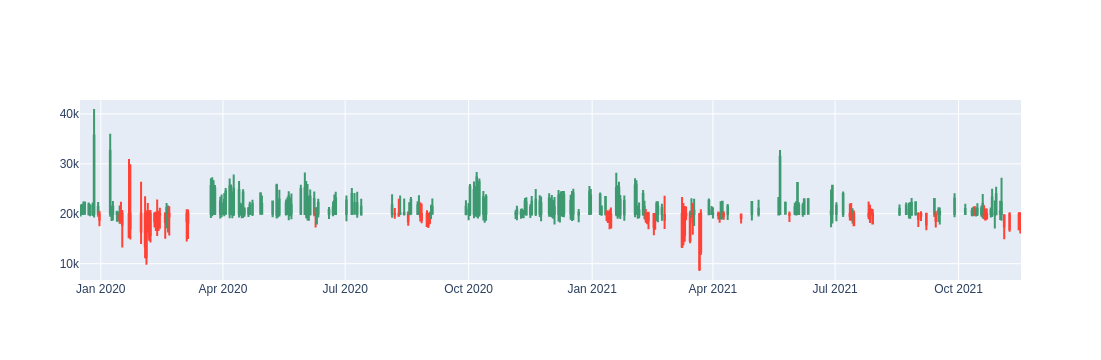

In [172]:
create_candle_stick(portfolio[ticker+[col for col in portfolio.columns if re.search(".*portfolio.*", col)]+ \
                    ["org_index","shift_index"]], date=portfolio.index[0].strftime("%Y-%m-%d"))

In [679]:
# portfolio.loc["2020-01-10"][["portfolio_buy","portfolio_curr","org_index","shift_index","portfolio"]]

In [525]:
# def create_candle_stick_rand(df_portfolio, date='2024-01-15', period=30):
#     # Backtest the tool for the last 30 days
#     df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
#     df_portfolio = df_portfolio.iloc[:20]
#     # print(df_portfolio.tail())
#     fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
#                 open=df_portfolio['portfolio_buy_rand'], high=df_portfolio['portfolio_max_rand'],
#                 low=df_portfolio['portfolio_min_rand'], close=df_portfolio['portfolio_curr_rand'])
#                      ])

#     fig.update_layout(xaxis_rangeslider_visible=False)
#     fig.show()

# def create_candle_stick(df_portfolio, date='2024-01-15', period=30):
#     # Backtest the tool for the last 30 days
#     df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
#     df_portfolio = df_portfolio.iloc[:252]
#     # print(df_portfolio.tail())
#     fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
#                 open=df_portfolio['portfolio_buy'], high=df_portfolio['portfolio_max'],
#                 low=df_portfolio['portfolio_min'], close=df_portfolio['portfolio_curr'],
#                 hovertext=["Buy Date: " + str(o) + "<br>Sell Date: " + str(h) + "<br>Recom Port: " + str(l) 
#                            for o, h, l in zip(df_portfolio["org_index"], df_portfolio["shift_index"], df_portfolio["portfolio"])])])

#     fig.update_layout(xaxis_rangeslider_visible=False)
#     fig.show()

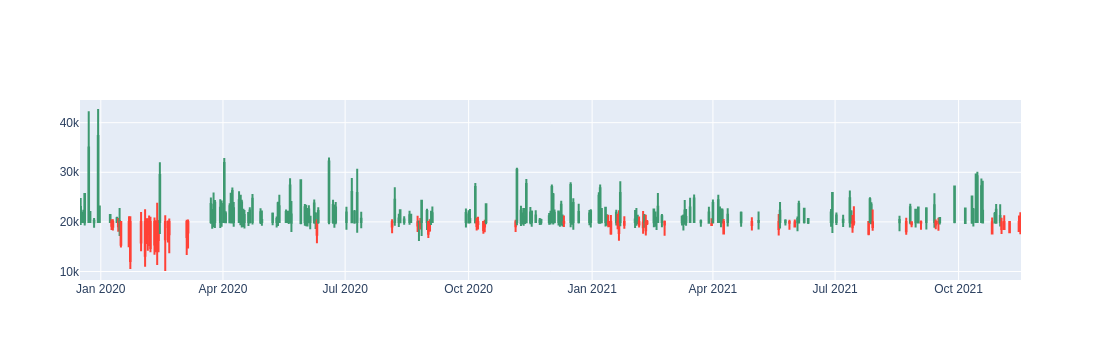

In [173]:
# create_candle_stick(portfolio_rand[ticker+[col for col in portfolio_rand.columns if re.search(".*portfolio.*", col)]], date='2024-11-07')
create_candle_stick(portfolio_rand[ticker+[col for col in portfolio_rand.columns if re.search(".*portfolio.*", col)]+ \
                    ["org_index","shift_index"]], date=portfolio_rand.index[0].strftime("%Y-%m-%d"))

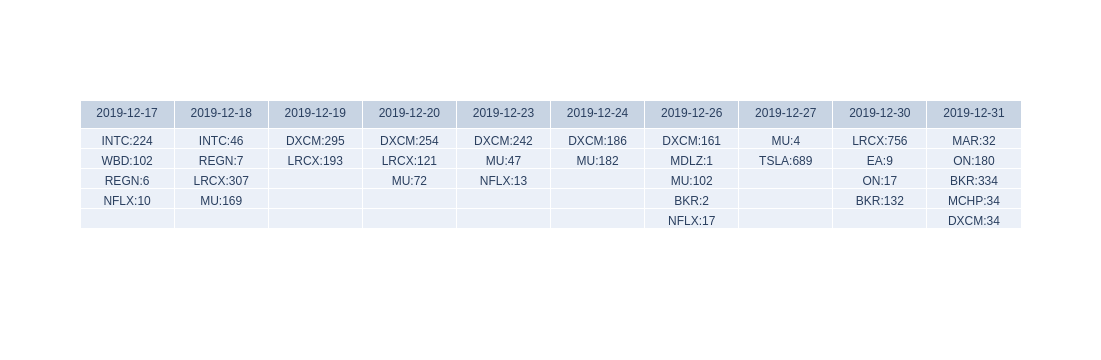

In [174]:
def list_of_list(window):
    # print(window.keys())
    return list(f"{k}:{v}" for k, v in window.items())

    
# Sample data
header_values = portfolio.iloc[:10].index.strftime("%Y-%m-%d")
cell_values = portfolio.iloc[:10]["portfolio"].apply(list_of_list).to_frame().values.tolist() #[['John', 25, 'New York'], ['Mary', 30, 'Los Angeles'], ['Bob', 35, 'Chicago']]
cell_values = [c[0] for c in cell_values]
# Create the table figure
fig = go.Figure(data=[go.Table(
    header=dict(values=header_values),
    cells=dict(values=cell_values)
)])

# Display the figure

fig.show()

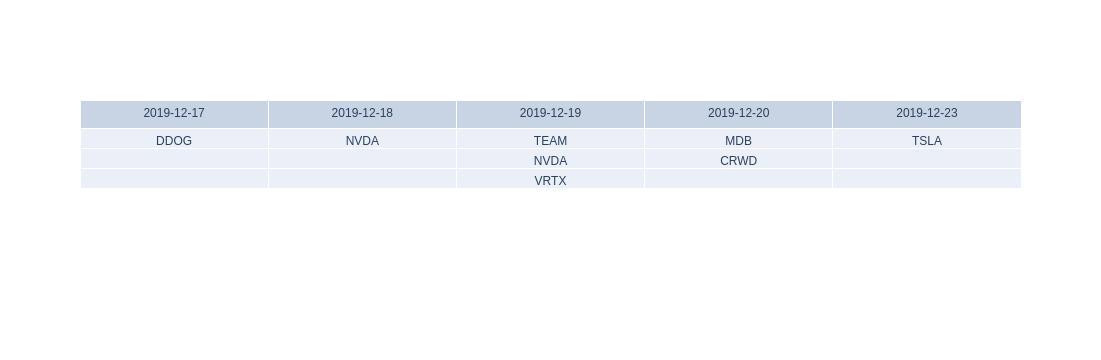

In [175]:
def list_of_list(window):
    # print(window.keys())
    return list(window.keys())

    
# Sample data
header_values = portfolio_rand[:5].index.strftime("%Y-%m-%d")
cell_values = portfolio_rand[:5]["portfolio"].apply(list_of_list).to_frame().values.tolist() #[['John', 25, 'New York'], ['Mary', 30, 'Los Angeles'], ['Bob', 35, 'Chicago']]
cell_values = [c[0] for c in cell_values]
# Create the table figure
fig = go.Figure(data=[go.Table(
    header=dict(values=header_values),
    cells=dict(values=cell_values)
)])

# Display the figure
fig.show()

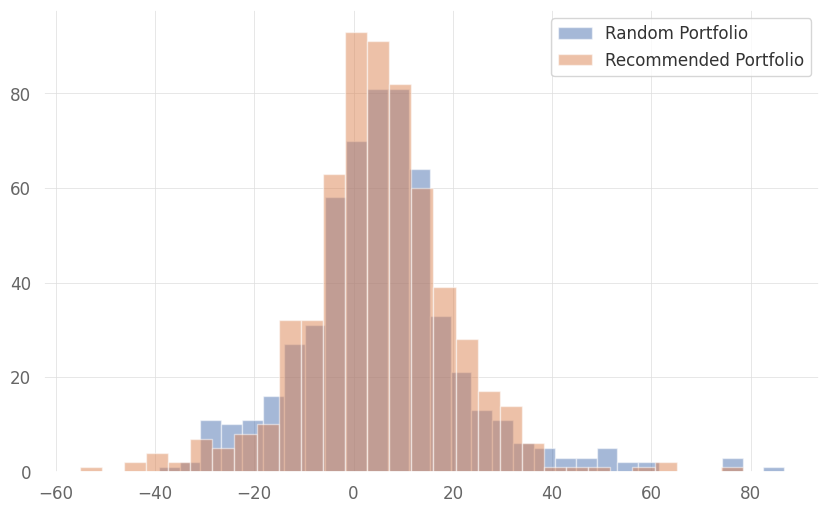

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data1 = ((portfolio_rand["portfolio_curr"] - portfolio_rand["portfolio_buy"])/portfolio_rand["portfolio_buy"])*100 #np.random.normal(0, 1, 1000)
data2 = ((portfolio["portfolio_curr"] - portfolio["portfolio_buy"])/portfolio["portfolio_buy"])*100 #np.random.normal(2, 1, 1000)
# data3 = np.random.normal(-2, 1, 1000)

# Plot the histograms
plt.hist(data1, bins=30, alpha=0.5, label='Random Portfolio')
plt.hist(data2, bins=30, alpha=0.5, label='Recommended Portfolio')
# plt.hist(data3, bins=30, alpha=0.5, label='Data 3')

plt.legend()
plt.show()

In [147]:
# import plotly.graph_objects as go
# x = [1, 2, 3, 4, 5]
# open_prices = [10, 12, 11, 13, 15]
# high_prices = [12, 14, 12, 15, 16]
# low_prices = [9, 10, 10, 12, 13]
# close_prices = [11, 13, 11.5, 14, 15]
# fig = go.Figure(data=[go.Candlestick(x=x, open=open_prices, high=high_prices, low=low_prices, close=close_prices,

#                                     hovertext=["Buy Date: " + "2024-05-01" + "<br>High: " + str(h) + "<br>Low: " + str(l) + "<br>Close: " + str(c) 

#                                               for o, h, l, c in zip(open_prices, high_prices, low_prices, close_prices)])])
# fig.show()

### Backtesting a portfolio using buy-hold for 20 days, then reinvesting for 1 year i.e 240-260 windows

In [462]:
portfolio = _pe.copy()
# portfolio_rand = _pe_ra.copy()

In [463]:
start_date = "2022-01-03"
end_date = "2023-01-03"

In [464]:
_portfolio['sequence'] = range(0, len(_portfolio) )

In [465]:
_portfolio = portfolio.loc[start_date:] #end_date]
_portfolio = _portfolio.iloc[:240]
print(_portfolio.shape)

(240, 100)


In [466]:
_portfolio.index

DatetimeIndex(['2022-01-03', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14',
               '2022-01-18', '2022-01-20',
               ...
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-22',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2024-01-02', '2024-01-11'],
              dtype='datetime64[ns]', name='Date', length=240, freq=None)

In [467]:
# _portfolio = pd.merge(_portfolio, portfolio_rand[["portfolio"]], left_index=True, right_index=True)

In [468]:
# _portfolio.rename(columns={"portfolio_x":"portfolio", "portfolio_y":"portfolio_rand"}, inplace=True)

In [469]:
start_portfolio = _portfolio.iloc[0]["portfolio"]
# start_portfolio_rand = _portfolio.iloc[0]["portfolio_rand"]

In [470]:
_portfolio["portfolio_temp"] = _portfolio.apply(lambda x: {})

In [296]:
def assign_value(window,i,j, curr_port):
    print(window)
    if window["sequence"]>=i and window["sequence"]<=j:
        print(curr_port)
        return curr_port
    else:
        return {}

In [472]:
# _portfolio = _portfolio.dropna(axis=0, subset=['portfolio'])
_portfolio['portfolio']

Date
2022-01-03                             {'AVGO': 316, 'META': 1}
2022-01-05                                          {'MU': 215}
2022-01-06                                          {'MU': 212}
2022-01-07                                          {'MU': 215}
2022-01-11                            {'WBD': 210, 'FANG': 132}
                                    ...                        
2023-12-27                   {'NXPI': 41, 'TMUS': 13, 'MU': 99}
2023-12-28    {'NXPI': 14, 'CSX': 1, 'FAST': 20, 'AMAT': 3, ...
2023-12-29    {'NXPI': 17, 'ZS': 16, 'ADI': 9, 'BKNG': 1, 'A...
2024-01-02    {'ADI': 18, 'QCOM': 24, 'MU': 77, 'INTC': 132,...
2024-01-11                  {'INTC': 229, 'MU': 73, 'TEAM': 13}
Name: portfolio, Length: 240, dtype: object

In [473]:
_portfolio.shape

(240, 101)

In [474]:
for i,j in zip(range(0,221, 20), range(19, 240, 20)):
    for k in range(i,j+1):
        curr_port = _portfolio.iloc[i]["portfolio"]
        # print(curr_port)
        # print(type(curr_port))
        if  curr_port != np.NaN:
            _portfolio.loc[_portfolio.index[i]:_portfolio.index[j],'portfolio_temp'] = \
                _portfolio.loc[_portfolio.index[i]:_portfolio.index[j],'portfolio_temp'].apply(lambda x: curr_port)
    else:
        continue

In [476]:
_portfolio.drop(columns=["portfolio"], inplace=True)
_portfolio = _portfolio.rename(columns={"portfolio_temp":"portfolio"})

In [477]:
_portfolio["portfolio"]

Date
2022-01-03                             {'AVGO': 316, 'META': 1}
2022-01-05                             {'AVGO': 316, 'META': 1}
2022-01-06                             {'AVGO': 316, 'META': 1}
2022-01-07                             {'AVGO': 316, 'META': 1}
2022-01-11                             {'AVGO': 316, 'META': 1}
                                    ...                        
2023-12-27    {'SBUX': 33, 'AMZN': 86, 'MU': 17, 'AMD': 21, ...
2023-12-28    {'SBUX': 33, 'AMZN': 86, 'MU': 17, 'AMD': 21, ...
2023-12-29    {'SBUX': 33, 'AMZN': 86, 'MU': 17, 'AMD': 21, ...
2024-01-02    {'SBUX': 33, 'AMZN': 86, 'MU': 17, 'AMD': 21, ...
2024-01-11    {'SBUX': 33, 'AMZN': 86, 'MU': 17, 'AMD': 21, ...
Name: portfolio, Length: 240, dtype: object

In [478]:
def evaluate_portfolio_val(window):
    try:
        port_val = 0
        print(window)
        for k,v in window["portfolio"].items():
            port_val = port_val + window[k]*v
        return port_val
    except Exception as err:
        return np.NaN

In [479]:
for i,j in zip(range(0,221, 20), range(19, 240, 20)):
    _portfolio.loc[_portfolio.index[i]]["portfolio_value"] = _portfolio.apply(evaluate_portfolio_val, axis=1)

NVDA                                                           30.073059
AAPL                                                          179.076614
MSFT                                                          326.940857
AMZN                                                          170.404495
GOOGL                                                         144.633362
                                             ...                        
portfolio_view_dict    {'AVGO': 0.025378262998198748, 'LIN': 0.011421...
portfolio_interval     {'AVGO': (0.0047143318762981265, 0.11400425758...
^OEX                                                         2219.439941
org_index                                            2022-01-03 00:00:00
portfolio                                       {'AVGO': 316, 'META': 1}
Name: 2022-01-03 00:00:00, Length: 100, dtype: object
NVDA                                                           27.560068
AAPL                                                          172.1008

ValueError: Cannot index with multidimensional key

In [481]:
_portfolio.iloc[-1]["portfolio_value"]

KeyError: 'portfolio_value'

In [754]:
_port = list(portfolio.loc["2020-01-22"]["portfolio"].keys())
_port_rand = list(portfolio_rand.loc["2020-01-22"]["portfolio_rand"].keys())

In [804]:
# Removing duplicate 
# df_result = df_result.loc[:,~df_result.columns.duplicated()].copy()

In [721]:
df_result = df_result[list(_port.keys())+list(_port_rand.keys())] #+["portfolio", "portfolio_rand"]]

In [805]:
df_result.isna().sum()[df_result.isna().sum() >0]

Series([], dtype: int64)

In [827]:
df_result.shape

(252, 10)

In [816]:
df_result = df_result.iloc[:252]

In [807]:
df_result["date"] = df_result.index.strftime("%Y-%m-%d")

In [821]:
def cagr(window, start_value, end_value, num_periods):
  return (end_value / start_value) ** (1 / num_periods) - 1

In [ ]:
def max_drawdown(window):
    return ((low - high)/high)*100

In [ ]:
def calmar_ratio(window):
    average_return / max_drawdown

In [811]:
def return_portfolio_value(window, col_name):
    value = 0
    try:
        for k,v in window[col_name].items():
            value = value + (window[k] * v)
        return value
    except Exception as err:
        print(err)
        return np.NaN

In [812]:
df_result["portfolio_value"] = df_result.apply(return_portfolio_value, args=("portfolio",), axis=1)
df_result["portfolio_rand_value"] = df_result.apply(return_portfolio_value, args=("portfolio_rand",), axis=1)

In [828]:
(df_result["portfolio_value"].iloc[-1]/df_result["portfolio_value"].iloc[0])-1

5.6812090687041135

In [837]:
df_result["portfolio_value"].min()

13105.450553894043

In [831]:
port_cagr=(df_result["portfolio_value"].iloc[-1]/df_result["portfolio_value"].iloc[0])-1
port_max_dd=((df_result["portfolio_value"].min()-df_result["portfolio_value"].max())/df_result["portfolio_value"].max())*100
port_calmar=(((df_result["portfolio_value"].iloc[-1]-df_result["portfolio_value"].iloc[0])/df_result["portfolio_value"].iloc[0])*100)/port_max_dd

In [832]:
port_calmar

-6.277527987245152

In [833]:
port_max_dd

-90.50073659961922

In [834]:
port_cagr_ra=(df_result["portfolio_rand_value"].iloc[-1]/df_result["portfolio_rand_value"].iloc[0])-1
port_max_dd_ra=((df_result["portfolio_rand_value"].min()-df_result["portfolio_rand_value"].max())/df_result["portfolio_rand_value"].max())*100
port_calmar_ra=(((df_result["portfolio_rand_value"].iloc[-1]-df_result["portfolio_rand_value"].iloc[0])/df_result["portfolio_rand_value"].iloc[0])*100)/port_max_dd

In [835]:
port_max_dd_ra

-82.8375751673186

In [836]:
port_calmar_ra

-2.3346816598285556

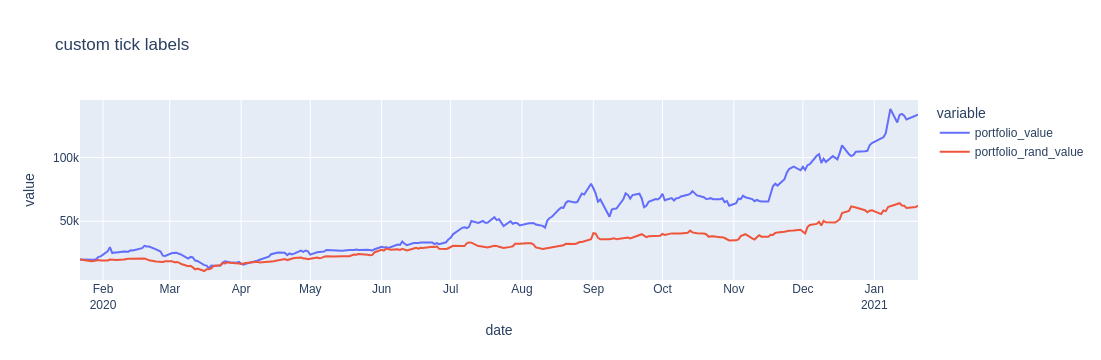

In [818]:
import plotly.express as px
fig = px.line(df_result, x="date", y=['portfolio_value', 'portfolio_rand_value'],
              hover_data={"date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()